In [2]:
import os
import cv2 as cv
import numpy as np
import random
from vectorQuantization import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [28]:
# First train your vector quantization model
root = "./RF_code/Caltech_101/101_ObjectCategories"
codebook_path = "./codebooks/"
vq = VectorQuantization(root, vocab_size= 310)
vq.fit_codebook()
# save codebook
# vq.save_codebook(os.path.join(codebook_path, "codebook.npy"))
# load codebook
# vq.load_codebook(os.path.join(codebook_path, "codebook.npy"))

# Encode the train and test images
vq.construct_train_histograms()
vq.construct_test_histograms()

# visualize the train and test images and their histograms
# cls = "water_lilly"  # ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick'
# idx = 5  # 0~14
# vq.visualization("train", cls, idx)
# vq.visualization("test", cls, idx)

# get pickle the vector quantization model
vq.save_as_file("./vq_q2_310/vq_310.pkl")

Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.65it/s]


Shape of descriptors:  (65371, 128)
Start constructing k-means codebook...


KeyboardInterrupt: 

In [26]:
# load the pickled vector quantization model
vq = load_from_file("./vq/vq.pkl")
train_X = vq.get_train_histograms()
train_y = vq.get_train_labels()

print(train_X.shape)
print(train_y.shape)

print("Start Random Forest Training")
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(train_X, train_y)

# test RF
test_X = vq.get_test_histograms()
test_y = vq.get_test_labels()

print("Test set shape")
print(test_X.shape)
print(test_y.shape)

print("Start Random Forest Testing")
pred_y = rf.predict(test_X)

# accuracy, confusion matrix
print("Accuracy: ", np.mean(pred_y == test_y))
print("Confusion Matrix: ")
cm = confusion_matrix(test_y, pred_y)

# plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq.get_class_list(),
    yticklabels=vq.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
plt.savefig("confusion_matrix_Q2.png")

Invalid path.


AttributeError: 'NoneType' object has no attribute 'get_train_histograms'

## Q2

In [37]:
# base_setting = {
#     "n_estimators": 300,
#     "max_depth": 10,
#     "max_features": "sqrt",
# }

base_setting = {
    "n_estimators": 460,
    "max_depth": 6,
    "max_features": "sqrt",
}



def perform_experiment(vq, independent_variable = "n_estimators", search_grid = range(10, 1000, 50), num_trials = 10, return_example = True, visualize_result = True, export_dir = "./Q2/"):
    """
    This function performs the experiment for the given independent variable and search grid.
    It returns the results as a pandas dataframe.

    Parameters:
    independent_variable (str): The variable to be varied in the experiment
    search_grid (list or iterable): The values of the independent variable to be used in the experiment
    num_trials (int): The number of trials to be run for each value of the independent variable
    return_example (bool): Whether to return example success and failure images index of the best model. 
    visualize_result (bool): Whether to visualize the results of the experiment
    Returns:
    result_df (pandas dataframe): The results of the experiment. It has 
            - experiment_variable: search_grid
            - mean accuracy
            - std accuracy
            - mean train time
            - std train time
            - mean test time
            - std test time
    confusion_matrix(list): The confusion matrix of the best model
    example_images (list): A list of example images for each value of the independent variable
    """
    if not os.path.exists(export_dir):
        os.makedirs(export_dir)
    else:
        ans = input(f"Directory {export_dir} already exists. Do you want to overwrite it? (y/n)")
        if ans == "y":
            pass
        else:
            raise ValueError("Directory already exists")
    
    if independent_variable not in base_setting:
        raise ValueError(f"Independent variable {independent_variable} not in base setting")
    
    train_X = vq.get_train_histograms()
    train_y = vq.get_train_labels()
    test_X = vq.get_test_histograms()
    test_y = vq.get_test_labels()

    
    accuracies = np.zeros((len(search_grid), num_trials))
    train_times = np.zeros((len(search_grid), num_trials))
    test_times = np.zeros((len(search_grid), num_trials))
    

    cms = []

    best_rf = None
    best_accuracy = 0
    best_model_idx = 0
    for i, param in enumerate(search_grid):
        setting = base_setting.copy()
        setting[independent_variable] = param
        
        for j in range(num_trials):
            # train
            start = time.time()
            
            
            rf = RandomForestClassifier(**setting)
            rf.fit(train_X, train_y)
            end = time.time()
            train_times[i, j] = end - start

            # test
            start = time.time()
            pred_y = rf.predict(test_X)
            end = time.time()
            test_times[i, j] = end - start

            # accuracy, confusion matrix
            accuracies[i, j] = np.mean(pred_y == test_y)
            if accuracies[i, j] > best_accuracy:
                best_accuracy = accuracies[i, j]
                best_rf = rf
                best_model_idx = i

        print(f"{independent_variable} = {param} || Accuracy: {np.mean(accuracies[i, :])} || Train Time: {np.mean(train_times[i, :])} || Test Time: {np.mean(test_times[i, :])} ")
        cms.append(confusion_matrix(test_y, pred_y))
    
    result_df = pd.DataFrame({
        f"{independent_variable}": search_grid,
        "mean accuracy": np.mean(accuracies, axis=1),
        "std accuracy": np.std(accuracies, axis=1),
        "mean train time": np.mean(train_times, axis=1),
        "std train time": np.std(train_times, axis=1),
        "mean test time": np.mean(test_times, axis=1),
        "std test time": np.std(test_times, axis=1),
    })

    result_df.to_csv(os.path.join(export_dir, f"result_{independent_variable}.csv"))

    print(f"Best model - {independent_variable} = {search_grid[best_model_idx]} || Accuracy: {result_df['mean accuracy'][best_model_idx]} || Train Time: {result_df['mean train time'][best_model_idx]} || Test Time: {result_df['mean test time'][best_model_idx]}")
    
    if return_example:
        example_success = []
        example_failure = []
        success = []
        failure = []
        pred_y = best_rf.predict(test_X)
        for i in range(len(test_y)):
            if pred_y[i] == test_y[i]:
                success.append(i)
                example_success.append( vq.get_test_images()[i])
            else:
                failure.append(i)
                example_failure.append(vq.get_test_images()[i])
        example_images = [example_success, example_failure]
        
    if visualize_result:
        
        # plot accuracy, train time, test time with 95% confidence interval
        plt.figure(0, figsize=(10, 10))
        plt.subplot(1,3,1)
        
        plt.errorbar(search_grid, result_df["mean accuracy"], yerr=1.96*result_df["std accuracy"], fmt='o')
        plt.plot(search_grid, result_df["mean accuracy"])
        plt.xlabel(independent_variable)
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs " + independent_variable)
        
        plt.subplot(1,3,2)
        plt.errorbar(search_grid, result_df["mean train time"], yerr=1.96*result_df["std train time"], fmt='o')
        plt.plot(search_grid, result_df["mean train time"])

        plt.xlabel(independent_variable)
        plt.ylabel("Train Time")
        plt.title("Train Time vs " + independent_variable)


        plt.subplot(1,3,3)
        plt.errorbar(search_grid, result_df["mean test time"], yerr=1.96*result_df["std test time"], fmt='o')
        plt.plot(search_grid, result_df["mean test time"])
        plt.xlabel(independent_variable)
        plt.ylabel("Test Time")
        plt.title("Test Time vs " + independent_variable)
        plt.savefig(os.path.join(export_dir, f"result_{independent_variable}.png"))
        plt.show()


        plt.figure(1, figsize=(10, 10))
        sns.heatmap(
            cms[best_model_idx],
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=vq.get_class_list(),
            yticklabels=vq.get_class_list(),
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
        plt.savefig(os.path.join(export_dir, f"confusion_matrix_{independent_variable}.png"))

        fig, axes = plt.subplots(2,3, figsize=(15, 10))
        success_1 = example_success[0]
        success_1 = cv.imread(success_1)
        success_1 = cv.cvtColor(success_1, cv.COLOR_BGR2RGB)
        axes[0,0].imshow(success_1)
        axes[0,0].set_title("Success 1")
        axes[0,0].axis("off")
        success_2 = example_success[1]
        success_2 = cv.imread(success_2)
        success_2 = cv.cvtColor(success_2, cv.COLOR_BGR2RGB)
        axes[1,0].imshow(success_2)
        axes[1,0].set_title("Success 2")
        axes[1,0].axis("off")

        failure_1 = example_failure[0]
        failure_1 = cv.imread(failure_1)
        failure_1 = cv.cvtColor(failure_1, cv.COLOR_BGR2RGB)
        axes[0,1].imshow(failure_1)
        axes[0,1].set_title("Failure 1")
        axes[0,1].axis("off")
        failure_2 = example_failure[1]
        failure_2 = cv.imread(failure_2)
        failure_2 = cv.cvtColor(failure_2, cv.COLOR_BGR2RGB)
        axes[1,1].imshow(failure_2)
        axes[1,1].set_title("Failure 2")
        axes[1,1].axis("off")
        
        failure_1_pred = pred_y[failure[0]]
        failure_1_pred = vq.get_test_images_dict()[failure_1_pred][0]
        failure_1_pred = cv.imread(failure_1_pred)
        failure_1_pred = cv.cvtColor(failure_1_pred, cv.COLOR_BGR2RGB)
        axes[0,2].imshow(failure_1_pred)
        axes[0,2].set_title("Failure 1 Prediction")
        axes[0,2].axis("off")
        
        failure_2_pred = pred_y[failure[1]]
        failure_2_pred = vq.get_test_images_dict()[failure_2_pred][0]
        failure_2_pred = cv.imread(failure_2_pred)
        failure_2_pred = cv.cvtColor(failure_2_pred, cv.COLOR_BGR2RGB)
        axes[1,2].imshow(failure_2_pred)
        axes[1,2].set_title("Failure 2 Prediction")
        axes[1,2].axis("off")
        plt.savefig(f"./Q2_results/example_images_{independent_variable}.png")

    if return_example:
        return result_df, cms[best_model_idx], example_images
    else:
        return result_df, cms[best_model_idx], None
    



        


        

        


## Num estimators

Loaded from vq/vq_310.pkl
n_estimators = 10 || Accuracy: 0.4993333333333334 || Train Time: 0.008518648147583009 || Test Time: 0.0006294727325439453 
n_estimators = 60 || Accuracy: 0.6433333333333333 || Train Time: 0.038621044158935545 || Test Time: 0.0020897388458251953 
n_estimators = 110 || Accuracy: 0.6846666666666668 || Train Time: 0.06719934940338135 || Test Time: 0.0036349058151245116 
n_estimators = 160 || Accuracy: 0.6966666666666667 || Train Time: 0.09681234359741211 || Test Time: 0.005247926712036133 
n_estimators = 210 || Accuracy: 0.6973333333333332 || Train Time: 0.12869503498077392 || Test Time: 0.006878185272216797 
n_estimators = 260 || Accuracy: 0.7 || Train Time: 0.1684135913848877 || Test Time: 0.008707666397094726 
n_estimators = 310 || Accuracy: 0.696 || Train Time: 0.1972058057785034 || Test Time: 0.01050260066986084 
n_estimators = 360 || Accuracy: 0.7046666666666667 || Train Time: 0.2367577075958252 || Test Time: 0.012239813804626465 
n_estimators = 410 || Accur

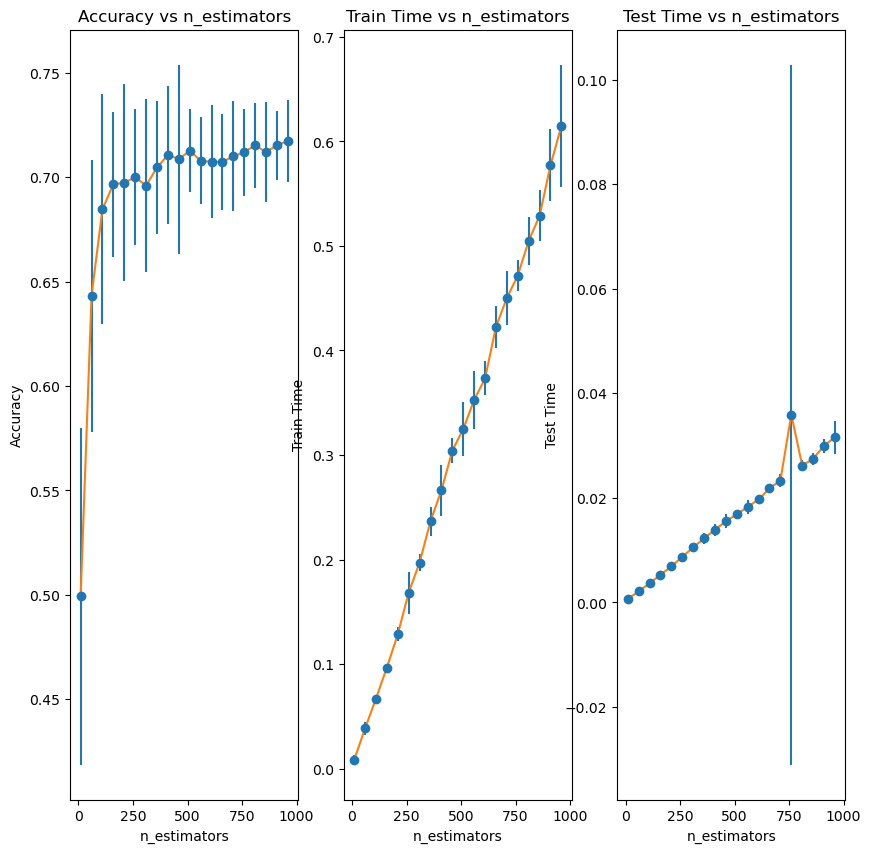

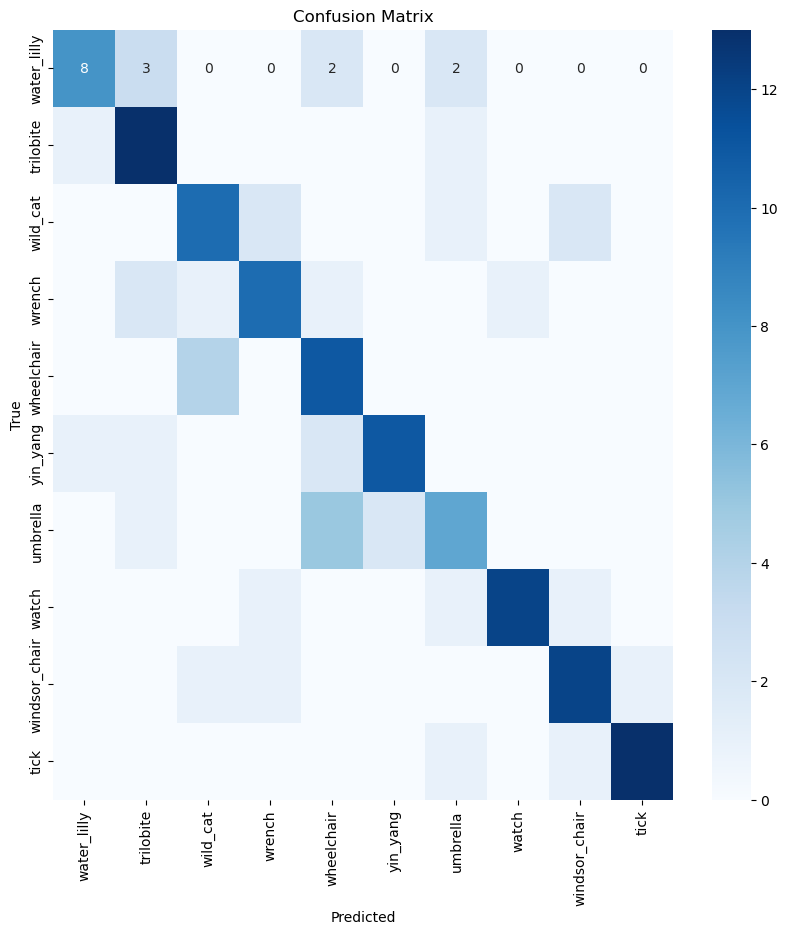

<Figure size 640x480 with 0 Axes>

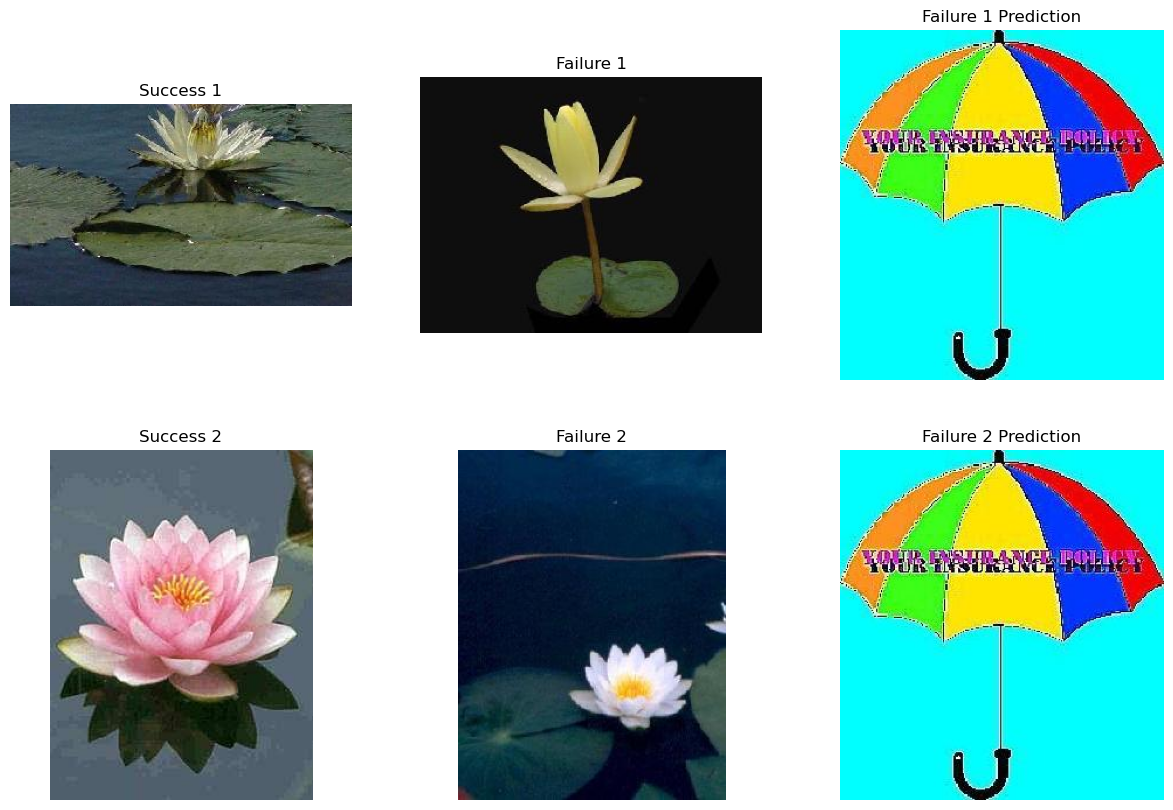

In [34]:
# Number of Trees
vq_opt = load_from_file("vq/vq_310.pkl")

n_estimators = range(10, 1000, 50)
result_df, cm, example_images = perform_experiment(vq_opt, "n_estimators", n_estimators, 10, True, True, "./Q2_results/")



## Max Depth

max_depth = 1 || Accuracy: 0.472 || Train Time: 0.11505849361419677 || Test Time: 0.0076923370361328125 
max_depth = 2 || Accuracy: 0.5966666666666667 || Train Time: 0.13193633556365966 || Test Time: 0.007897686958312989 
max_depth = 3 || Accuracy: 0.6766666666666667 || Train Time: 0.14415385723114013 || Test Time: 0.00851612091064453 
max_depth = 4 || Accuracy: 0.688 || Train Time: 0.1531514883041382 || Test Time: 0.009177684783935547 
max_depth = 5 || Accuracy: 0.7066666666666667 || Train Time: 0.16627614498138427 || Test Time: 0.009275174140930176 
max_depth = 6 || Accuracy: 0.7086666666666666 || Train Time: 0.18089580535888672 || Test Time: 0.009460949897766113 
max_depth = 7 || Accuracy: 0.7093333333333333 || Train Time: 0.1871201992034912 || Test Time: 0.009932804107666015 
max_depth = 8 || Accuracy: 0.706 || Train Time: 0.18948714733123778 || Test Time: 0.01004648208618164 
max_depth = 9 || Accuracy: 0.7153333333333334 || Train Time: 0.18881454467773437 || Test Time: 0.010019588

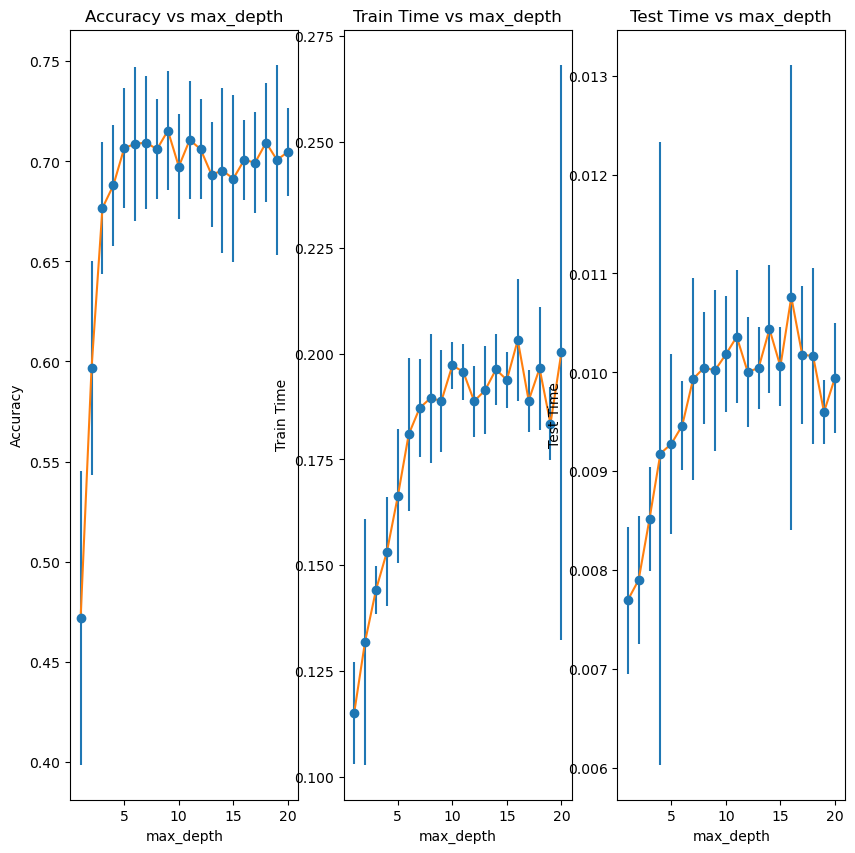

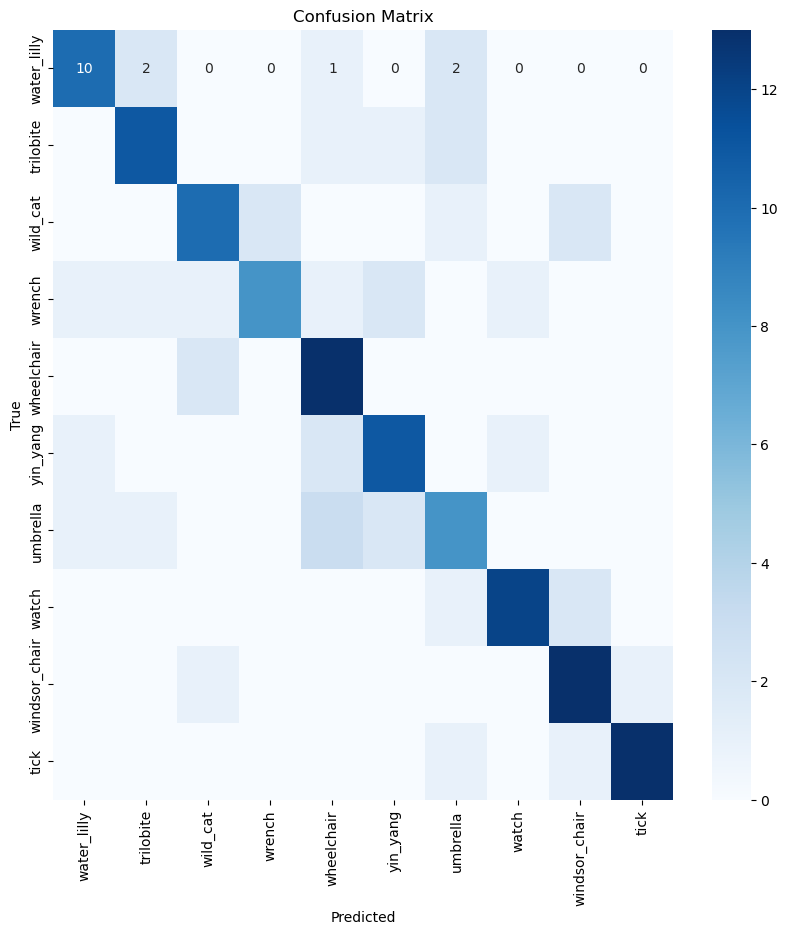

<Figure size 640x480 with 0 Axes>

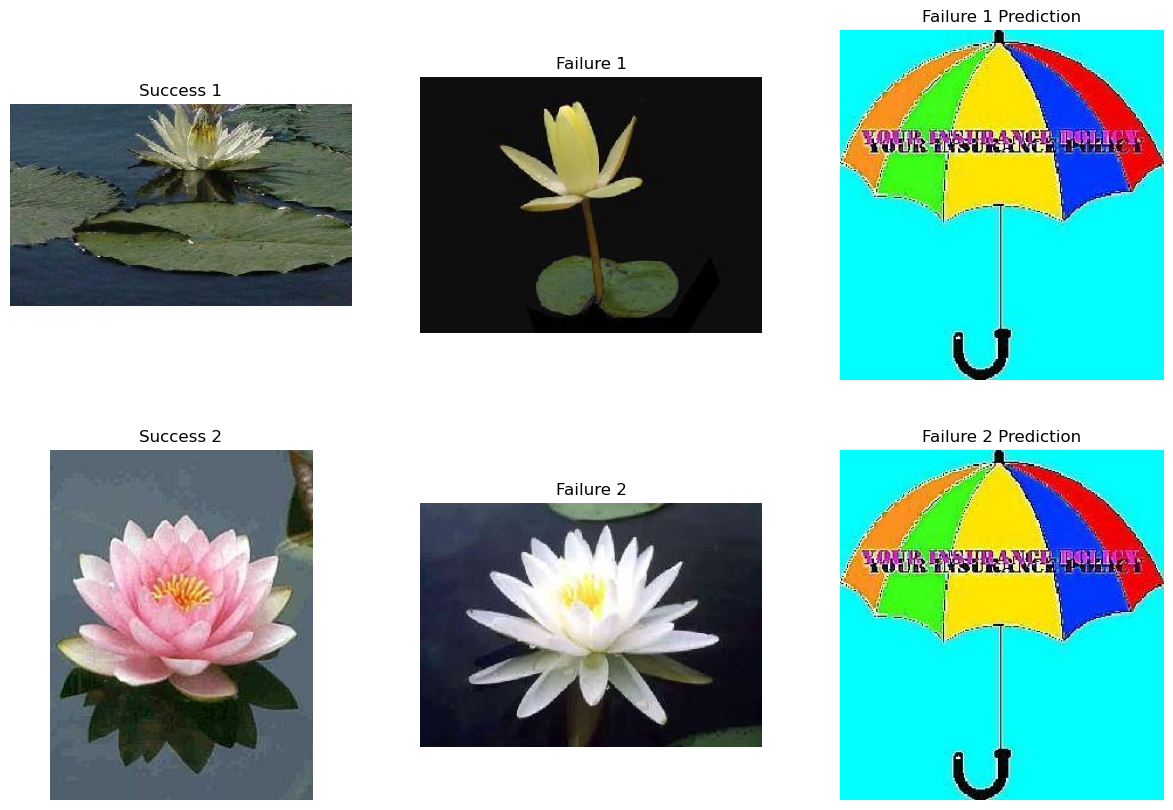

In [35]:
# Number of Trees
max_depth = range(1, 21, 1)
result_df, cm, example_images = perform_experiment(vq_opt, "max_depth", max_depth, 10, True, True, "./Q2_results/")

max_features = 0.05 || Accuracy: 0.7106666666666667 || Train Time: 0.2501091480255127 || Test Time: 0.014013671875 
max_features = 0.1 || Accuracy: 0.7186666666666667 || Train Time: 0.32994372844696046 || Test Time: 0.013928461074829101 
max_features = 0.15 || Accuracy: 0.7186666666666667 || Train Time: 0.39659459590911866 || Test Time: 0.013841462135314942 
max_features = 0.2 || Accuracy: 0.7106666666666668 || Train Time: 0.46476187705993655 || Test Time: 0.013608121871948242 
max_features = 0.25 || Accuracy: 0.712 || Train Time: 0.5343034982681274 || Test Time: 0.013621068000793457 
max_features = 0.3 || Accuracy: 0.7026666666666668 || Train Time: 0.6042534589767456 || Test Time: 0.013629436492919922 
max_features = 0.35 || Accuracy: 0.6980000000000001 || Train Time: 0.6681337356567383 || Test Time: 0.013448977470397949 
max_features = 0.39999999999999997 || Accuracy: 0.696 || Train Time: 0.7348270177841186 || Test Time: 0.01353905200958252 
max_features = 0.44999999999999996 || Accu

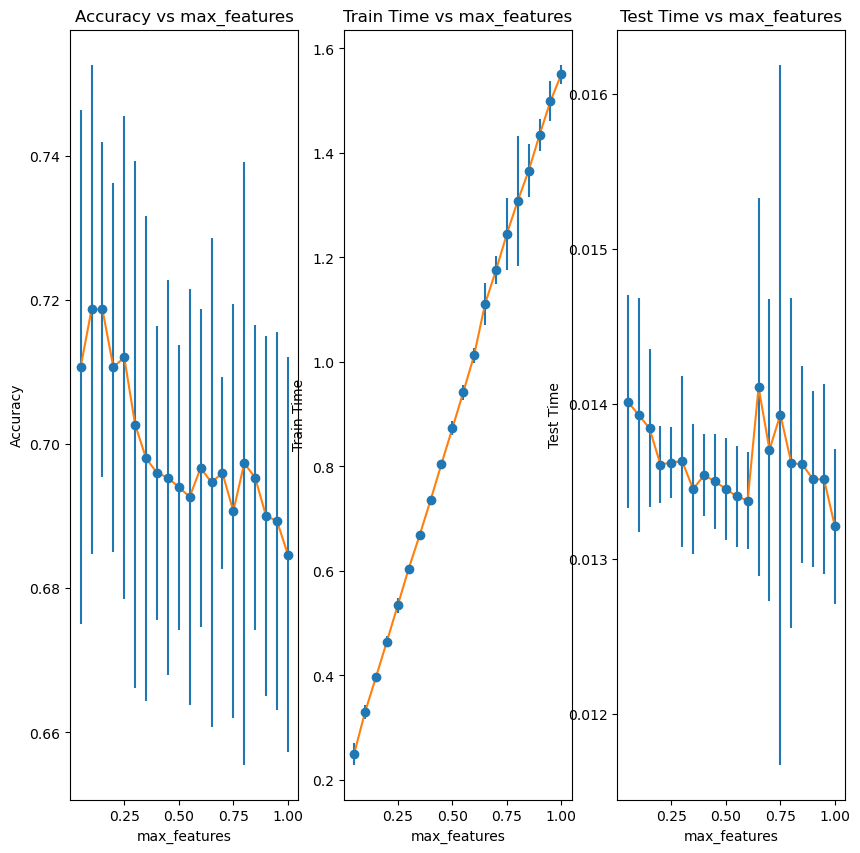

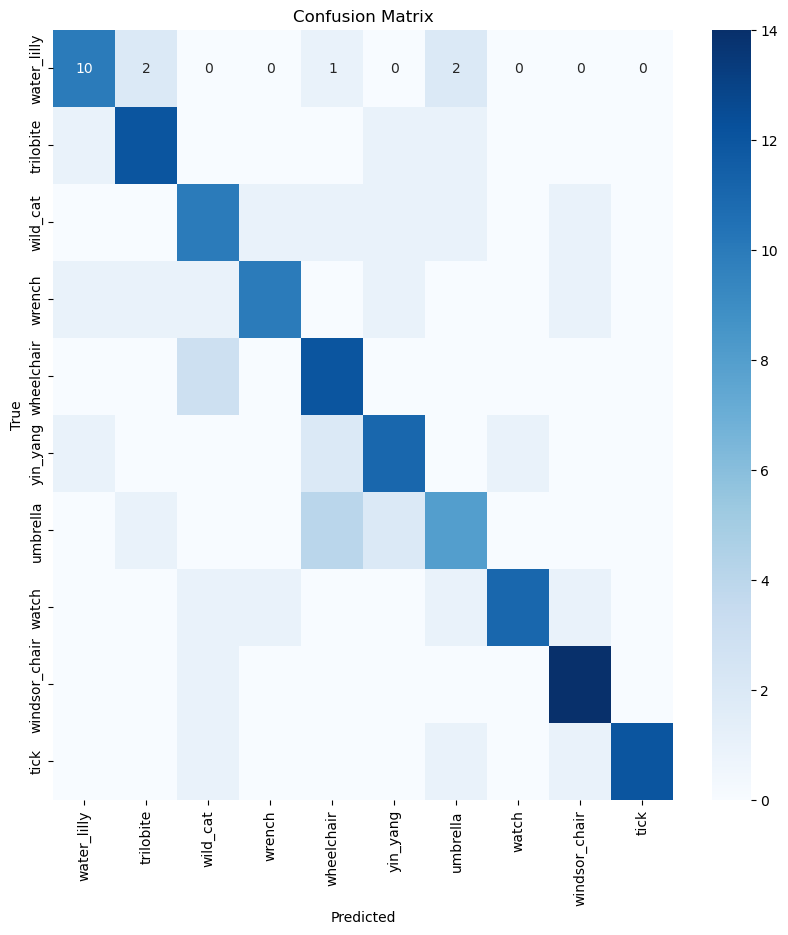

<Figure size 640x480 with 0 Axes>

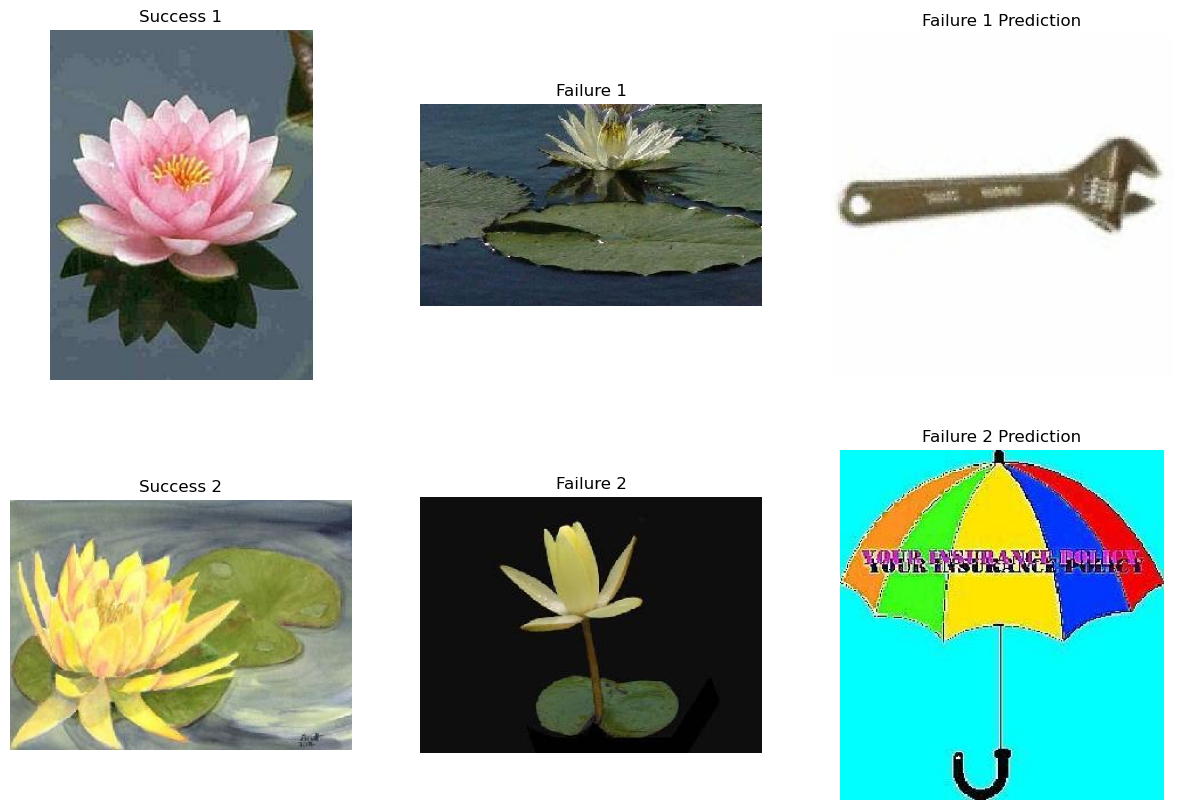

In [38]:
# The degree of randomness in each tree
max_features = np.linspace(0.05, 1, 20)
result_df, cm, example_images = perform_experiment(vq_opt, "max_features", max_features, 10, True, True, "./Q2_results/")

### Vocabulary Size

Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.51it/s]


Shape of descriptors:  (64152, 128)
Start constructing k-means codebook...
Shape of vocab:  (100, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 27.08s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 100)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 100)
Saved as ./vq/kmeans_time_test2/vq_100.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.29it/s]


Shape of descriptors:  (61161, 128)
Start constructing k-means codebook...
Shape of vocab:  (120, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 31.81s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 120)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 120)
Saved as ./vq/kmeans_time_test2/vq_120.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.10it/s]


Shape of descriptors:  (67284, 128)
Start constructing k-means codebook...
Shape of vocab:  (140, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 44.12s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 140)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 140)
Saved as ./vq/kmeans_time_test2/vq_140.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 100.56it/s]


Shape of descriptors:  (65585, 128)
Start constructing k-means codebook...
Shape of vocab:  (160, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 43.20s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 160)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 160)
Saved as ./vq/kmeans_time_test2/vq_160.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.05it/s]


Shape of descriptors:  (63468, 128)
Start constructing k-means codebook...
Shape of vocab:  (180, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 47.02s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 180)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 180)
Saved as ./vq/kmeans_time_test2/vq_180.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.78it/s]


Shape of descriptors:  (63137, 128)
Start constructing k-means codebook...
Shape of vocab:  (200, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 56.57s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 200)
Saved as ./vq/kmeans_time_test2/vq_200.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.65it/s]


Shape of descriptors:  (65748, 128)
Start constructing k-means codebook...
Shape of vocab:  (220, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 55.93s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 220)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 220)
Saved as ./vq/kmeans_time_test2/vq_220.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.03it/s]


Shape of descriptors:  (68826, 128)
Start constructing k-means codebook...
Shape of vocab:  (240, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 67.96s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 240)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 240)
Saved as ./vq/kmeans_time_test2/vq_240.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.17it/s]


Shape of descriptors:  (60758, 128)
Start constructing k-means codebook...
Shape of vocab:  (260, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 71.92s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 260)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 260)
Saved as ./vq/kmeans_time_test2/vq_260.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.34it/s]


Shape of descriptors:  (66786, 128)
Start constructing k-means codebook...
Shape of vocab:  (280, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 69.59s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 280)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 280)
Saved as ./vq/kmeans_time_test2/vq_280.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.24it/s]


Shape of descriptors:  (62018, 128)
Start constructing k-means codebook...
Shape of vocab:  (300, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 72.00s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 300)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 300)
Saved as ./vq/kmeans_time_test2/vq_300.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.35it/s]


Shape of descriptors:  (65998, 128)
Start constructing k-means codebook...
Shape of vocab:  (320, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 107.81s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 320)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 320)
Saved as ./vq/kmeans_time_test2/vq_320.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.68it/s]


Shape of descriptors:  (66271, 128)
Start constructing k-means codebook...
Shape of vocab:  (340, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 100.72s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 340)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 340)
Saved as ./vq/kmeans_time_test2/vq_340.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.36it/s]


Shape of descriptors:  (65255, 128)
Start constructing k-means codebook...
Shape of vocab:  (360, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 94.05s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 360)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 360)
Saved as ./vq/kmeans_time_test2/vq_360.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.08it/s]


Shape of descriptors:  (64046, 128)
Start constructing k-means codebook...
Shape of vocab:  (380, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 102.45s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 380)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 380)
Saved as ./vq/kmeans_time_test2/vq_380.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.88it/s]


Shape of descriptors:  (68988, 128)
Start constructing k-means codebook...
Shape of vocab:  (400, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 124.47s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
Saved as ./vq/kmeans_time_test2/vq_400.pkl


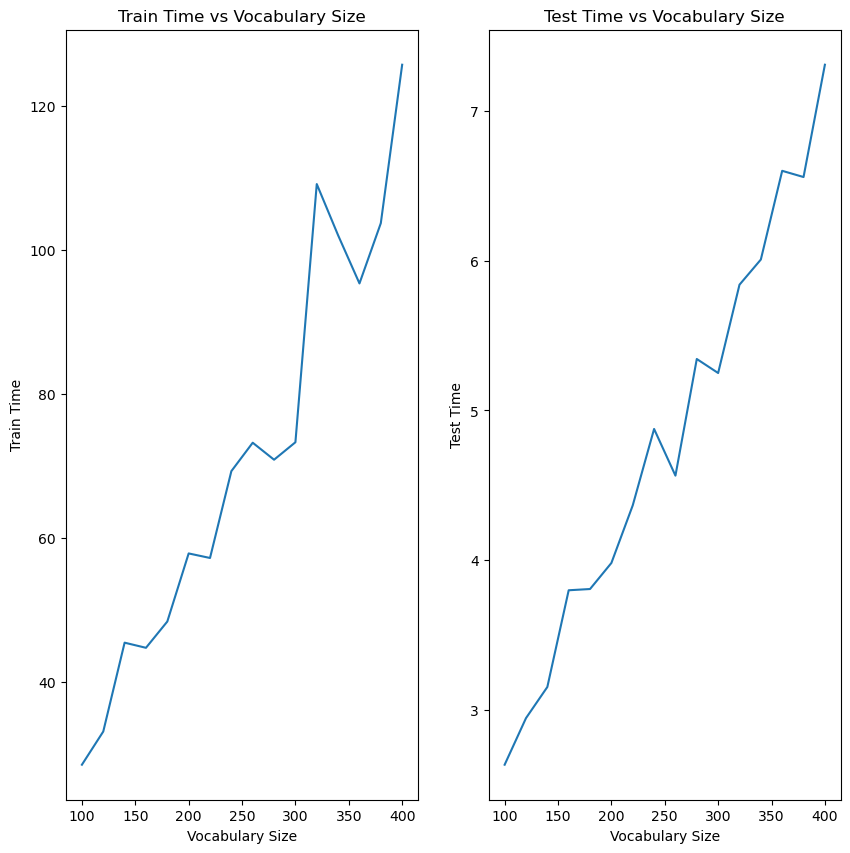

In [24]:
# First train your vector quantization model
import time
root = "./RF_code/Caltech_101/101_ObjectCategories"
codebook_path = "./codebooks/"

vocabulary_size = range(100, 401, 20)
train_times = []
test_times = []

for vocab_size in vocabulary_size:
    vq = VectorQuantization(root, vocab_size)
    start = time.time()
    vq.fit_codebook()
    end = time.time()
    train_times.append(end - start)

    # Encode the train and test images
    start = time.time()
    vq.construct_train_histograms()
    end = time.time()

    test_times.append(end - start)
    vq.construct_test_histograms()

    # get pickle the vector quantization model
    vq.save_as_file(f"./vq/kmeans_time_test2/vq_{vocab_size}.pkl")

plt.figure(0, figsize=(10, 10))
plt.subplot(1,2,1)
plt.plot(vocabulary_size, train_times)
plt.xlabel("Vocabulary Size")
plt.ylabel("Train Time")
plt.title("Train Time vs Vocabulary Size")

plt.subplot(1,2,2)
plt.plot(vocabulary_size, test_times)
plt.xlabel("Vocabulary Size")
plt.ylabel("Test Time")
plt.title("Test Time vs Vocabulary Size")

plt.savefig("./Q2_results/vocab_size.png")

df = pd.DataFrame({
    "vocabulary_size": vocabulary_size,
    "train_time": train_times,
    "test_time": test_times
})

df.to_csv("./Q2_results/vocab_size_2.csv")

In [40]:
vq = VectorQuantization(root, 310)
train_time = 0
test_time = 0

start = time.time()
vq.fit_codebook()
end = time.time()
train_time = end - start
start = time.time()
vq.construct_test_histograms()
end = time.time()
test_time = end - start

print(f"train time: {train_time}, test time: {test_time}")

Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 83.72it/s] 


Shape of descriptors:  (64994, 128)
Start constructing k-means codebook...
Shape of vocab:  (310, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 90.15s
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 310)
train time: 91.95271015167236, test time: 5.714565277099609


In [ ]:
import re

# Example string (you can replace this with your actual string)
text = """
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 97.47it/s] 
Shape of descriptors:  (62839, 128)
Start constructing k-means codebook...
Shape of vocab:  (10, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 14.02s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 10)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 10)
Saved as ./vq/vq_10.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 106.10it/s]
Shape of descriptors:  (70344, 128)
Start constructing k-means codebook...
Shape of vocab:  (60, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 87.69s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 60)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 60)
Saved as ./vq/vq_60.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.06it/s]
Shape of descriptors:  (64126, 128)
Start constructing k-means codebook...
Shape of vocab:  (110, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 122.82s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 110)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 110)
Saved as ./vq/vq_110.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.44it/s]
Shape of descriptors:  (65323, 128)
Start constructing k-means codebook...
Shape of vocab:  (160, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 183.67s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 160)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 160)
Saved as ./vq/vq_160.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 108.72it/s]
Shape of descriptors:  (64142, 128)
Start constructing k-means codebook...
Shape of vocab:  (210, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 257.35s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 210)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 210)
Saved as ./vq/vq_210.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 102.68it/s]
Shape of descriptors:  (64592, 128)
Start constructing k-means codebook...
Shape of vocab:  (260, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 301.80s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 260)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 260)
Saved as ./vq/vq_260.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.43it/s]
Shape of descriptors:  (64480, 128)
Start constructing k-means codebook...
Shape of vocab:  (310, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 324.88s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 310)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 310)
Saved as ./vq/vq_310.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.95it/s]
Shape of descriptors:  (68440, 128)
Start constructing k-means codebook...
Shape of vocab:  (360, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 291.12s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 360)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 360)
Saved as ./vq/vq_360.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.33it/s]
Shape of descriptors:  (64328, 128)
Start constructing k-means codebook...
Shape of vocab:  (410, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 335.12s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 410)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 410)
Saved as ./vq/vq_410.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.92it/s]
Shape of descriptors:  (63715, 128)
Start constructing k-means codebook...
Shape of vocab:  (460, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 495.16s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 460)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 460)
Saved as ./vq/vq_460.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 100.79it/s]
Shape of descriptors:  (63972, 128)
Start constructing k-means codebook...
Shape of vocab:  (510, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 527.10s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 510)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 510)
Saved as ./vq/vq_510.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.04it/s]
Shape of descriptors:  (67759, 128)
Start constructing k-means codebook...
Shape of vocab:  (560, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 511.33s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 560)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 560)
Saved as ./vq/vq_560.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.41it/s]
Shape of descriptors:  (68191, 128)
Start constructing k-means codebook...
Shape of vocab:  (610, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 577.92s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 610)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 610)
Saved as ./vq/vq_610.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.46it/s]
Shape of descriptors:  (63291, 128)
Start constructing k-means codebook...
Shape of vocab:  (660, 128) (vocab_size, 128)
The codebook is constructed. You can use it with 'self.vocab' attribute.
Time taken constructing k-means codebook: 1118.59s
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 660)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 660)
Saved as ./vq/vq_660.pkl
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 105.89it/s]
Shape of descriptors:  (67378, 128)
Start constructing k-means codebook...

"""

# Regular expression pattern to find the time
pattern = r"Time taken constructing k-means codebook: (\d+\.\d+)s"

# Search for the pattern
match = re.findall(pattern, text)

if match:
    # Extract the time
    time_taken = match.group(1)
    print(f"Time taken to construct k-means codebook: {time_taken} seconds")
else:
    print("Time not found in the text.")


Loaded from ./vq/vq_740.pkl
Loaded from ./vq/vq_620.pkl
Loaded from ./vq/vq_780.pkl
Loaded from ./vq/vq_800.pkl
Loaded from ./vq/vq_380.pkl
Loaded from ./vq/vq_340.pkl
Loaded from ./vq/vq_220.pkl
Loaded from ./vq/vq_680.pkl
Loaded from ./vq/vq_720.pkl
Loaded from ./vq/vq_640.pkl
Loaded from ./vq/vq_320.pkl
Loaded from ./vq/vq_240.pkl
Loaded from ./vq/vq_860.pkl
Loaded from ./vq/vq_280.pkl
Loaded from ./vq/vq_10.pkl
Loaded from ./vq/vq_460.pkl
Loaded from ./vq/vq_110.pkl
Loaded from ./vq/vq_660.pkl
Loaded from ./vq/vq_310.pkl
Loaded from ./vq/vq_700.pkl
Loaded from ./vq/vq_260.pkl
Loaded from ./vq/vq_300.pkl
Loaded from ./vq/vq_880.pkl
Loaded from ./vq/vq_840.pkl
Loaded from ./vq/vq_510.pkl
Loaded from ./vq/vq_600.pkl
Loaded from ./vq/vq_210.pkl
Loaded from ./vq/vq_760.pkl
Loaded from ./vq/vq_560.pkl
Loaded from ./vq/vq_820.pkl
Loaded from ./vq/vq_160.pkl
Loaded from ./vq/vq_410.pkl
Loaded from ./vq/vq_60.pkl
Loaded from ./vq/vq_200.pkl
Loaded from ./vq/vq_360.pkl
Loaded from ./vq/vq_61

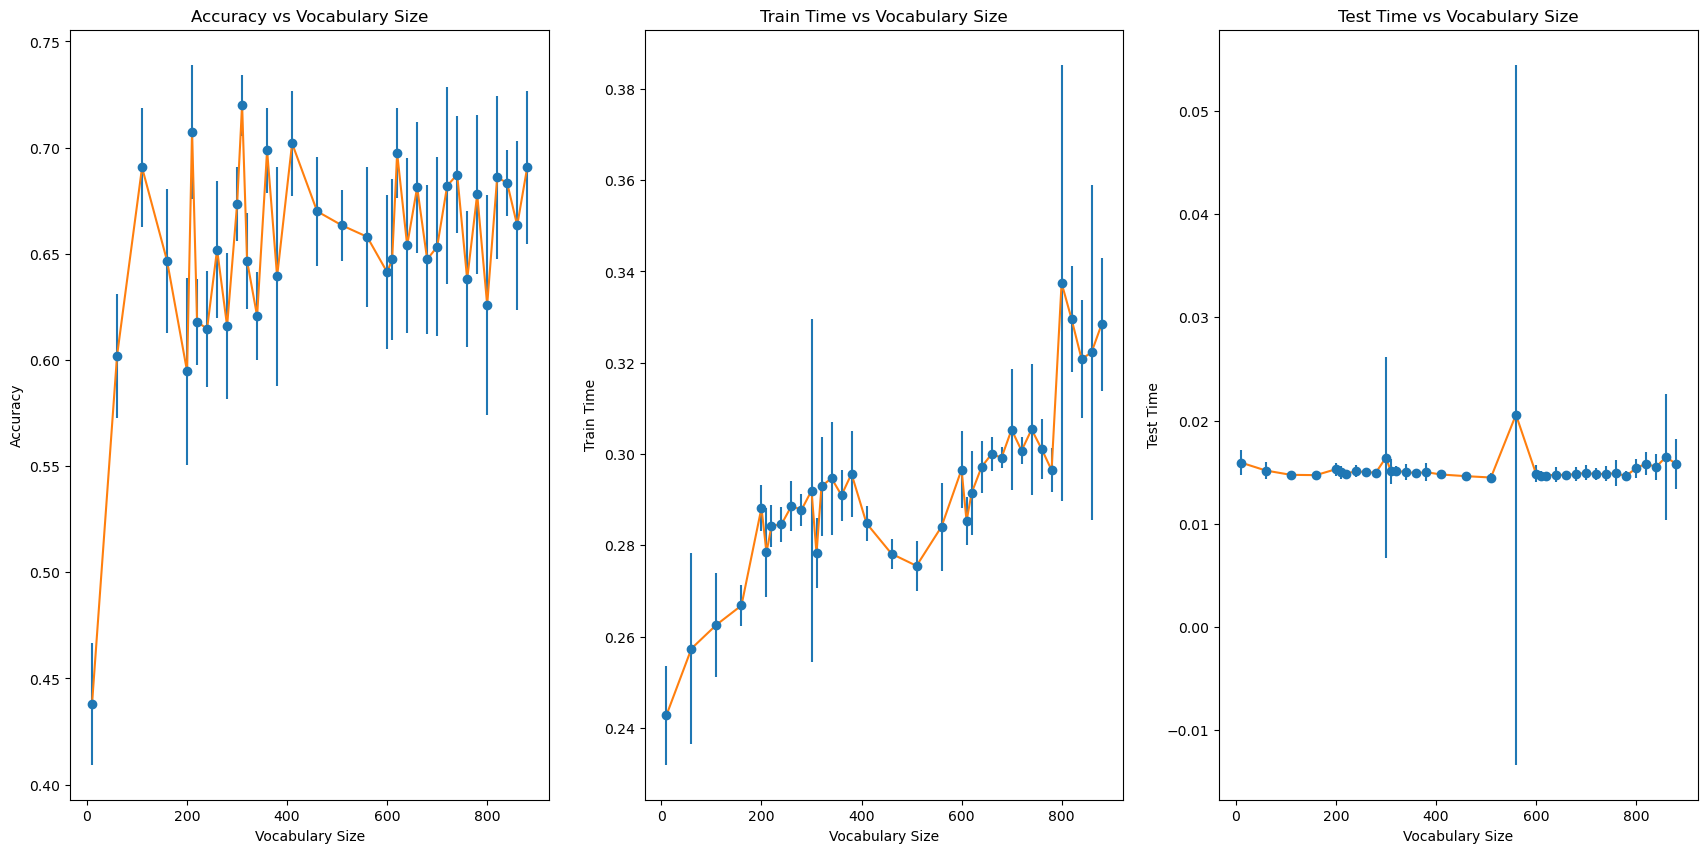

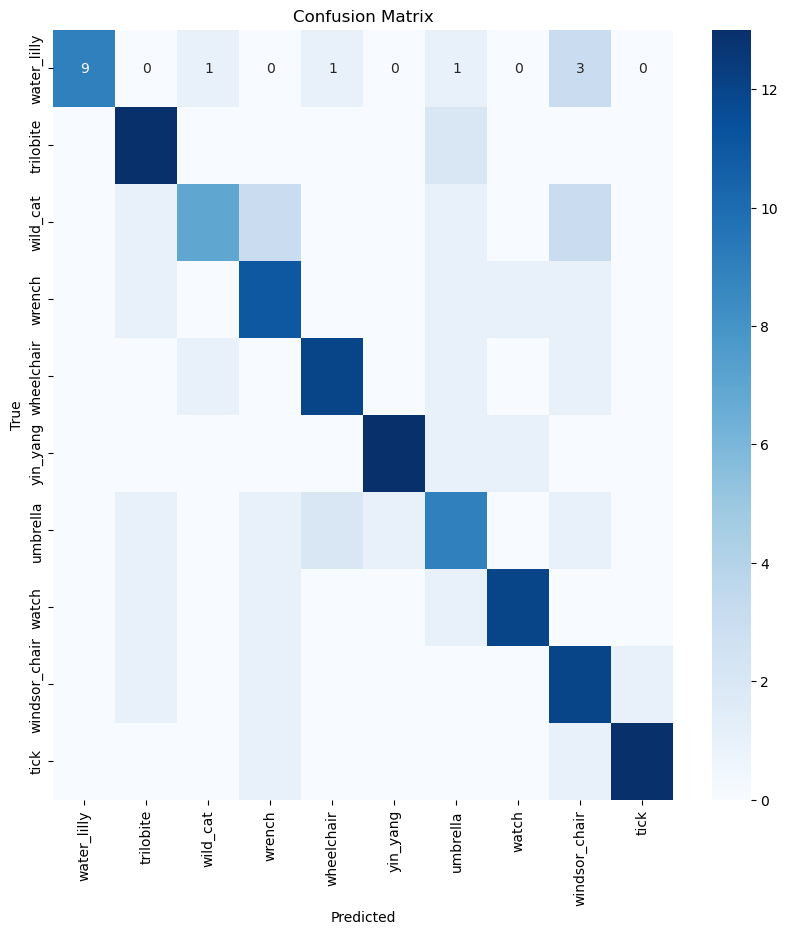

<Figure size 640x480 with 0 Axes>

In [3]:
import os
import numpy as np
vq_path = "./vq/"
vq_list = []

for vq_pkl in os.listdir(vq_path):
    if vq_pkl.endswith(".pkl"):
        vq = load_from_file(os.path.join(vq_path, vq_pkl))
        vq_list.append(vq)

vq_list.sort(key=lambda x: x.vocab_size)

accuracy = np.zeros((len(vq_list), 10))
train_time = np.zeros((len(vq_list), 10))
test_time = np.zeros((len(vq_list), 10))

num_trials = 10
best_accuracy = 0
best_model_idx = 0
vocab_size = []
cms = []
for i, vq in enumerate(vq_list):
    
    train_X = vq.get_train_histograms()
    train_y = vq.get_train_labels()
    test_X = vq.get_test_histograms()
    test_y = vq.get_test_labels()

    vocab_size.append(vq.vocab_size)
    for j in range(num_trials):
        rf = RandomForestClassifier(n_estimators=500, max_depth=6)
        start = time.time()
        rf.fit(train_X, train_y)
        end = time.time()
        train_time[i, j] = end - start

        start = time.time()
        pred_y = rf.predict(test_X)
        end = time.time()
        test_time[i, j] = end - start

        accuracy[i, j] = np.mean(pred_y == test_y)

        if accuracy[i, j] > best_accuracy:
            best_accuracy = accuracy[i, j]
            best_model_idx = i
    print(f"VQ {i} || Accuracy: {np.mean(accuracy[i, :])} || Train Time: {np.mean(train_time[i, :])} || Test Time: {np.mean(test_time[i, :])} ")
    cm = confusion_matrix(test_y, pred_y)
    cms.append(cm)
result_df = pd.DataFrame({
    "vocabulary_size": vocab_size,
    "mean accuracy": np.mean(accuracy, axis=1),
    "std accuracy": np.std(accuracy, axis=1),
    "mean train time": np.mean(train_time, axis=1),
    "std train time": np.std(train_time, axis=1),
    "mean test time": np.mean(test_time, axis=1),
    "std test time": np.std(test_time, axis=1),
})

result_df.to_csv("./Q2_results/result_vq.csv")

# plot accuracy, train time, test time with 95% confidence interval
plt.figure(0, figsize=(21, 10))
plt.subplot(1,3,1)
plt.errorbar(vocab_size, result_df["mean accuracy"], yerr=1.96*result_df["std accuracy"], fmt='o')
plt.plot(vocab_size, result_df["mean accuracy"])
plt.xlabel("Vocabulary Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Vocabulary Size")

plt.subplot(1,3,2)
plt.errorbar(vocab_size, result_df["mean train time"], yerr=1.96*result_df["std train time"], fmt='o')
plt.plot(vocab_size, result_df["mean train time"])

plt.xlabel("Vocabulary Size")
plt.ylabel("Train Time")
plt.title("Train Time vs Vocabulary Size")


plt.subplot(1,3,3)
plt.errorbar(vocab_size, result_df["mean test time"], yerr=1.96*result_df["std test time"], fmt='o')
plt.plot(vocab_size, result_df["mean test time"])
plt.xlabel("Vocabulary Size")
plt.ylabel("Test Time")
plt.title("Test Time vs Vocabulary Size")
plt.savefig("./Q2_results/result_vq.png")
plt.show()

# plot confusion matrix of the best model
plt.figure(figsize=(10, 10))
cm = cms[best_model_idx]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq.get_class_list(),
    yticklabels=vq.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.title("Confusion Matrix")
plt.show()
plt.savefig("./Q2_results/confusion_matrix_vq.png")

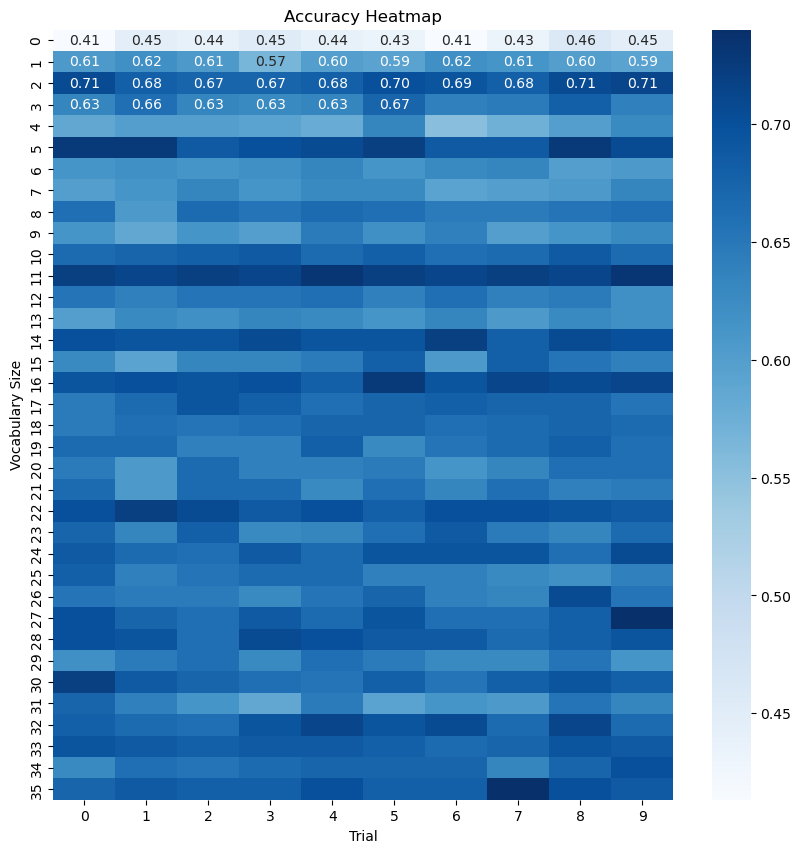

210
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.72666667 0.72666667 0.         0.         0.         0.
  0.         0.         0.72666667 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.       

In [21]:
# best model
best_accuracy 
vq_best = vq_list[best_model_idx]

# accuracy heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    accuracy,
    annot=True,
    fmt=".2f",
    cmap="Blues",    
    )
plt.xlabel("Trial")
plt.ylabel("Vocabulary Size")  
plt.title("Accuracy Heatmap")
plt.savefig("./Q2_results/accuracy_heatmap.png")
plt.show()

wh = np.where(accuracy > 0.72, accuracy, 0)
vq_5 = vq_list[5]
print(vq_5.vocab_size)
print(wh)

mean_accs = np.mean(accuracy, axis=1)
maximum_mean_acc = np.max(mean_accs)
best_vq_idx = np.argmax(mean_accs)
best_vq = vq_list[best_vq_idx]
print(maximum_mean_acc)
print(best_vq.vocab_size)

## RF Codebook

In [1]:
import os
import cv2 as cv
import numpy as np
import random
from vectorQuantization import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import time

root = "./RF_code/Caltech_101/101_ObjectCategories"
rf_vq_path = "./RF_vq/pickles/"
vq = VectorQuantization(root, vocab_size= 2560, use_RF_codebook=True, vq_n_estimators= 160)
vq.fit_codebook()
vq.construct_train_histograms()
vq.construct_test_histograms()
vq.save_as_file(os.path.join(rf_vq_path, "vq.pkl"))

Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 103.21it/s]


Shape of descriptors:  (63122, 128)
Shape of descriptor_labels:  (63122,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 160, total number of leaves: 2560
Time taken constructing Random Forest codebook: 10.34s
Total number of codewords: 2560
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2560)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2560)
File already exists.
Saved as ./RF_vq/pickles/vq.pkl


Start Random Forest Training
Start Random Forest Testing
Accuracy:  0.5666666666666667


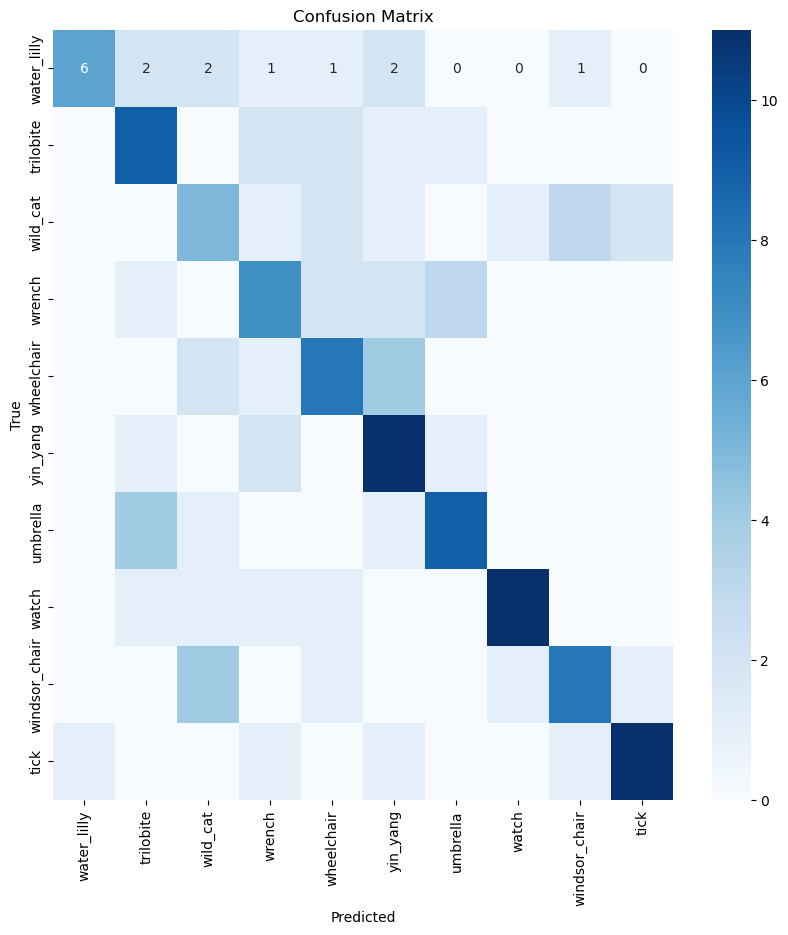

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
train_X = vq.get_train_histograms()
train_y = vq.get_train_labels()

test_X = vq.get_test_histograms()
test_y = vq.get_test_labels()

print("Start Random Forest Training")
rf = RandomForestClassifier(n_estimators=800, max_depth=10, )
rf.fit(train_X, train_y)

# test RF
print("Start Random Forest Testing")
pred_y = rf.predict(test_X)
accuracy = np.mean(pred_y == test_y)
print("Accuracy: ", accuracy)
cm = confusion_matrix(test_y, pred_y)

# plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq.get_class_list(),
    yticklabels=vq.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### RF codebook: vocabulary size = 2048으로 고정

 max_depth를 1부터 11까지 증가, num_estimators를 $2^{10}$에서 $2^0$까지 감소시킨다. RF classifier는 num_estimators = 600, max_depth = 8로 고정한다.

In [9]:
import sys
root = "./RF_code/Caltech_101/101_ObjectCategories"
vq_export_dir = "./RF_vq_1206/"
os.makedirs(vq_export_dir, exist_ok=True)

vocab_size = 2**11
num_trials = 5
max_depth = range(1, 12)
num_estimators = [vocab_size // 2**n for n in max_depth]
accuracy = np.zeros((len(max_depth), num_trials))
train_time = np.zeros((len(max_depth), num_trials))
test_time = np.zeros((len(max_depth), num_trials))
cms = []
best_accuracy = 0
best_model_idx = 0

class SuppressPrint:
    def __enter__(self):
        # self._original_stdout = sys.stdout
        pass
        # sys.stdout = open(os.devnull, 'w')
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        # sys.stdout.close()
        # sys.stdout = self._original_stdout
        pass

for i, (n_estimators, depth) in enumerate(zip(num_estimators, max_depth)):
    for j in range(num_trials):
        with SuppressPrint():
            vq_rf = VectorQuantization(root, vocab_size= vocab_size, use_RF_codebook=True, vq_n_estimators= n_estimators)
            
            start = time.time()
            vq_rf.fit_codebook()
            end = time.time()
            train_time[i, j] = end - start

            # VQ test time: time to encode the images
            start = time.time()
            vq_rf.construct_train_histograms()
            end = time.time()
            test_time[i, j] = end - start
            vq_rf.construct_test_histograms()
            rf_classifier = RandomForestClassifier(n_estimators=600, max_depth=8)
            train_X = vq_rf.get_train_histograms()
            train_y = vq_rf.get_train_labels()
            test_X = vq_rf.get_test_histograms()
            test_y = vq_rf.get_test_labels()

            rf_classifier.fit(train_X, train_y)
            pred_y = rf_classifier.predict(test_X)

            accuracy[i, j] = np.mean(pred_y == test_y)
            if accuracy[i, j] > best_accuracy:
                best_accuracy = accuracy[i, j]
                best_model_idx = i
    
    cm = confusion_matrix(test_y, pred_y)
    cms.append(cm)
    print(f"VQ RF {i} || Accuracy: {np.mean(accuracy[i, :])} || Train Time: {np.mean(train_time[i, :])} || Test Time: {np.mean(test_time[i, :])} ")

result_df = pd.DataFrame({
    "max_depth": max_depth,
    "num_estimators": num_estimators,
    "mean accuracy": np.mean(accuracy, axis=1),
    "std accuracy": np.std(accuracy, axis=1),
    "mean train time": np.mean(train_time, axis=1),
    "std train time": np.std(train_time, axis=1),
    "mean test time": np.mean(test_time, axis=1),
    "std test time": np.std(test_time, axis=1),
})

result_df.to_csv(os.path.join(vq_export_dir, "result_vq_rf_fixed_num_vocab.csv"))

# plot accuracy, train time, test time with 95% confidence interval
plt.figure(0, figsize=(21, 10))
plt.subplot(1,3,1)
plt.errorbar(max_depth, result_df["mean accuracy"], yerr=1.96*result_df["std accuracy"], fmt='o')
plt.plot(max_depth, result_df["mean accuracy"])
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Depth")

plt.subplot(1,3,2)
plt.errorbar(max_depth, result_df["mean train time"], yerr=1.96*result_df["std train time"], fmt='o')
plt.plot(max_depth, result_df["mean train time"])

plt.xlabel("Max Depth")
plt.ylabel("Train Time")
plt.title("Train Time vs Max Depth")


plt.subplot(1,3,3)
plt.errorbar(max_depth, result_df["mean test time"], yerr=1.96*result_df["std test time"], fmt='o')
plt.plot(max_depth, result_df["mean test time"])
plt.xlabel("Max Depth")
plt.ylabel("Test Time")
plt.title("Test Time vs Max Depth")
plt.savefig(os.path.join(vq_export_dir, "result_vq_rf_fixed_num_vocab.png"))
plt.show()

# plot confusion matrix of the best model
plt.figure(figsize=(10, 10))
cm = cms[best_model_idx]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq_rf.get_class_list(),
    yticklabels=vq_rf.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.title("Confusion Matrix")
plt.show()
plt.savefig(os.path.join(vq_export_dir, "confusion_matrix_vq_rf_fixed_num_vocab.png"))

# report the best model
print(f"Best model - Max Depth = {max_depth[best_model_idx]} || Accuracy: {result_df['mean accuracy'][best_model_idx]} || Train Time: {result_df['mean train time'][best_model_idx]} || Test Time: {result_df['mean test time'][best_model_idx]}")



        

Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.86it/s]


Shape of descriptors:  (68413, 128)
Shape of descriptor_labels:  (68413,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 1024, total number of leaves: 2048
Time taken constructing Random Forest codebook: 21.09s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # o

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.01it/s]


Shape of descriptors:  (63350, 128)
Shape of descriptor_labels:  (63350,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 1024, total number of leaves: 2048
Time taken constructing Random Forest codebook: 18.45s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # o

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.42it/s]


Shape of descriptors:  (64847, 128)
Shape of descriptor_labels:  (64847,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 1024, total number of leaves: 2048
Time taken constructing Random Forest codebook: 18.88s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # o

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.88it/s]


Shape of descriptors:  (67992, 128)
Shape of descriptor_labels:  (67992,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 1024, total number of leaves: 2048
Time taken constructing Random Forest codebook: 20.76s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # o

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.05it/s]


Shape of descriptors:  (59072, 128)
Shape of descriptor_labels:  (59072,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 1024, total number of leaves: 2048
Time taken constructing Random Forest codebook: 17.05s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
VQ RF 0 || Accuracy: 0.4066666666666666 || Train Time: 20.543820095062255 || Test Time: 168.2906123161316 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images fou

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 124.54it/s]


Shape of descriptors:  (64034, 128)
Shape of descriptor_labels:  (64034,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 512, total number of leaves: 2048
Time taken constructing Random Forest codebook: 24.63s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 125.17it/s]


Shape of descriptors:  (63959, 128)
Shape of descriptor_labels:  (63959,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 512, total number of leaves: 2048
Time taken constructing Random Forest codebook: 22.24s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 124.38it/s]


Shape of descriptors:  (68258, 128)
Shape of descriptor_labels:  (68258,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 512, total number of leaves: 2048
Time taken constructing Random Forest codebook: 287.42s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # o

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:16<00:00,  9.04it/s] 


Shape of descriptors:  (65576, 128)
Shape of descriptor_labels:  (65576,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 512, total number of leaves: 2048
Time taken constructing Random Forest codebook: 16.87s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.19it/s]


Shape of descriptors:  (63716, 128)
Shape of descriptor_labels:  (63716,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 512, total number of leaves: 2048
Time taken constructing Random Forest codebook: 32.67s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
VQ RF 1 || Accuracy: 0.5146666666666666 || Train Time: 81.06384091377258 || Test Time: 184.87815203666688 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images foun

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.68it/s]


Shape of descriptors:  (71462, 128)
Shape of descriptor_labels:  (71462,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 256, total number of leaves: 2048
Time taken constructing Random Forest codebook: 13.16s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.98it/s]


Shape of descriptors:  (68663, 128)
Shape of descriptor_labels:  (68663,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 256, total number of leaves: 2048
Time taken constructing Random Forest codebook: 870.45s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # o

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.95it/s]


Shape of descriptors:  (67343, 128)
Shape of descriptor_labels:  (67343,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 256, total number of leaves: 2048
Time taken constructing Random Forest codebook: 63.72s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.77it/s]


Shape of descriptors:  (64861, 128)
Shape of descriptor_labels:  (64861,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 256, total number of leaves: 2048
Time taken constructing Random Forest codebook: 11.50s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.57it/s]


Shape of descriptors:  (66828, 128)
Shape of descriptor_labels:  (66828,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 256, total number of leaves: 2048
Time taken constructing Random Forest codebook: 12.03s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
VQ RF 2 || Accuracy: 0.5359999999999999 || Train Time: 195.44047923088073 || Test Time: 258.2484320163727 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images foun

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.17it/s]


Shape of descriptors:  (68337, 128)
Shape of descriptor_labels:  (68337,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 128, total number of leaves: 2048
Time taken constructing Random Forest codebook: 7.97s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.63it/s]


Shape of descriptors:  (63259, 128)
Shape of descriptor_labels:  (63259,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 128, total number of leaves: 2048
Time taken constructing Random Forest codebook: 7.32s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.80it/s]


Shape of descriptors:  (68255, 128)
Shape of descriptor_labels:  (68255,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 128, total number of leaves: 2048
Time taken constructing Random Forest codebook: 44.86s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.31it/s]


Shape of descriptors:  (70266, 128)
Shape of descriptor_labels:  (70266,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 128, total number of leaves: 2048
Time taken constructing Random Forest codebook: 42.72s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.95it/s]


Shape of descriptors:  (62347, 128)
Shape of descriptor_labels:  (62347,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 128, total number of leaves: 2048
Time taken constructing Random Forest codebook: 1935.12s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
VQ RF 3 || Accuracy: 0.5519999999999999 || Train Time: 408.8626440048218 || Test Time: 3.8487071990966797 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images fo

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.66it/s]


Shape of descriptors:  (65208, 128)
Shape of descriptor_labels:  (65208,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 64, total number of leaves: 2048
Time taken constructing Random Forest codebook: 4.96s
Total number of codewords: 2047
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.26it/s]


Shape of descriptors:  (62908, 128)
Shape of descriptor_labels:  (62908,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 64, total number of leaves: 2048
Time taken constructing Random Forest codebook: 5.12s
Total number of codewords: 2047
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 102.43it/s]


Shape of descriptors:  (64578, 128)
Shape of descriptor_labels:  (64578,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 64, total number of leaves: 2048
Time taken constructing Random Forest codebook: 5.05s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.53it/s]


Shape of descriptors:  (69722, 128)
Shape of descriptor_labels:  (69722,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 64, total number of leaves: 2048
Time taken constructing Random Forest codebook: 5.41s
Total number of codewords: 2048
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.91it/s]


Shape of descriptors:  (65052, 128)
Shape of descriptor_labels:  (65052,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 64, total number of leaves: 2048
Time taken constructing Random Forest codebook: 4.95s
Total number of codewords: 2046
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
VQ RF 4 || Accuracy: 0.6053333333333335 || Train Time: 6.40996356010437 || Test Time: 101.73702483177185 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.24it/s]


Shape of descriptors:  (65182, 128)
Shape of descriptor_labels:  (65182,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 32, total number of leaves: 2048
Time taken constructing Random Forest codebook: 2.94s
Total number of codewords: 2045
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.09it/s]


Shape of descriptors:  (65407, 128)
Shape of descriptor_labels:  (65407,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 32, total number of leaves: 2048
Time taken constructing Random Forest codebook: 2.87s
Total number of codewords: 2043
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2048)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.76it/s]


Shape of descriptors:  (64149, 128)
Shape of descriptor_labels:  (64149,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 32, total number of leaves: 2048
Time taken constructing Random Forest codebook: 2.85s
Total number of codewords: 2045
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2048)
Constructing histogram of test set...


KeyboardInterrupt: 

### RF codebook: num_estimators = 50으로 고정

max_depth를 1부터 7까지 증가시킨다. RF Classifier는 아까와 똑같이 고정한다.

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 106.20it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.35it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.63it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.26it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 108.92it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 114.34it/s]

VQ RF 0 || Accuracy: 0.368 || Train Time: 2.3309317588806153 || Test Time: 2.2672227382659913 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.22it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.18it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.08it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.67it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.79it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 113.83it/s]

VQ RF 1 || Accuracy: 0.48933333333333334 || Train Time: 2.9148309230804443 || Test Time: 2.289437103271484 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.27it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.49it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.28it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.27it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.83it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 119.98it/s]

VQ RF 2 || Accuracy: 0.512 || Train Time: 3.640654134750366 || Test Time: 2.282967472076416 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.74it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.91it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.36it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.55it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.84it/s]
Computing SIFT descriptors. The number of images loaded::   9%|▊         | 13/150 [00:00<00:01, 124.66it/s]

VQ RF 3 || Accuracy: 0.5693333333333332 || Train Time: 4.312004423141479 || Test Time: 2.307995414733887 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.25it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.01it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.89it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.25it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.78it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 111.67it/s]

VQ RF 4 || Accuracy: 0.6306666666666667 || Train Time: 5.026393985748291 || Test Time: 2.468833827972412 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.54it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.33it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 126.60it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.06it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.38it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 116.94it/s]

VQ RF 5 || Accuracy: 0.612 || Train Time: 5.7097320556640625 || Test Time: 2.5640668869018555 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.96it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.26it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 126.15it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.98it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 125.15it/s]
Computing SIFT descriptors. The number of images loaded::   9%|▊         | 13/150 [00:00<00:01, 128.37it/s]

VQ RF 6 || Accuracy: 0.6173333333333334 || Train Time: 6.419616794586181 || Test Time: 2.7505953311920166 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 124.41it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.02it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 125.44it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.08it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.80it/s]
Computing SIFT descriptors. The number of images loaded::   9%|▊         | 13/150 [00:00<00:01, 118.66it/s]

VQ RF 7 || Accuracy: 0.6319999999999999 || Train Time: 7.431843566894531 || Test Time: 3.4714277744293214 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.38it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.61it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.46it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.79it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 106.93it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 119.65it/s]

VQ RF 8 || Accuracy: 0.6333333333333333 || Train Time: 8.362450456619262 || Test Time: 4.517526388168335 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.05it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.47it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.30it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.54it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.35it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 119.20it/s]

VQ RF 9 || Accuracy: 0.6053333333333333 || Train Time: 9.849384927749634 || Test Time: 7.247506332397461 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.94it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 103.58it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.28it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.03it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.85it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 112.70it/s]

VQ RF 10 || Accuracy: 0.6226666666666667 || Train Time: 10.634176445007324 || Test Time: 11.132046556472778 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.91it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.22it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.23it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.30it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.82it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 10/150 [00:00<00:01, 94.93it/s]

VQ RF 11 || Accuracy: 0.6413333333333334 || Train Time: 11.395668077468873 || Test Time: 19.57941393852234 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.29it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 98.37it/s] 
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.06it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 105.02it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.49it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 113.95it/s]

VQ RF 12 || Accuracy: 0.632 || Train Time: 12.110623216629028 || Test Time: 38.131272649765016 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 104.99it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.28it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.32it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.21it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.77it/s]


VQ RF 13 || Accuracy: 0.6506666666666667 || Train Time: 12.861844205856324 || Test Time: 74.20299620628357 


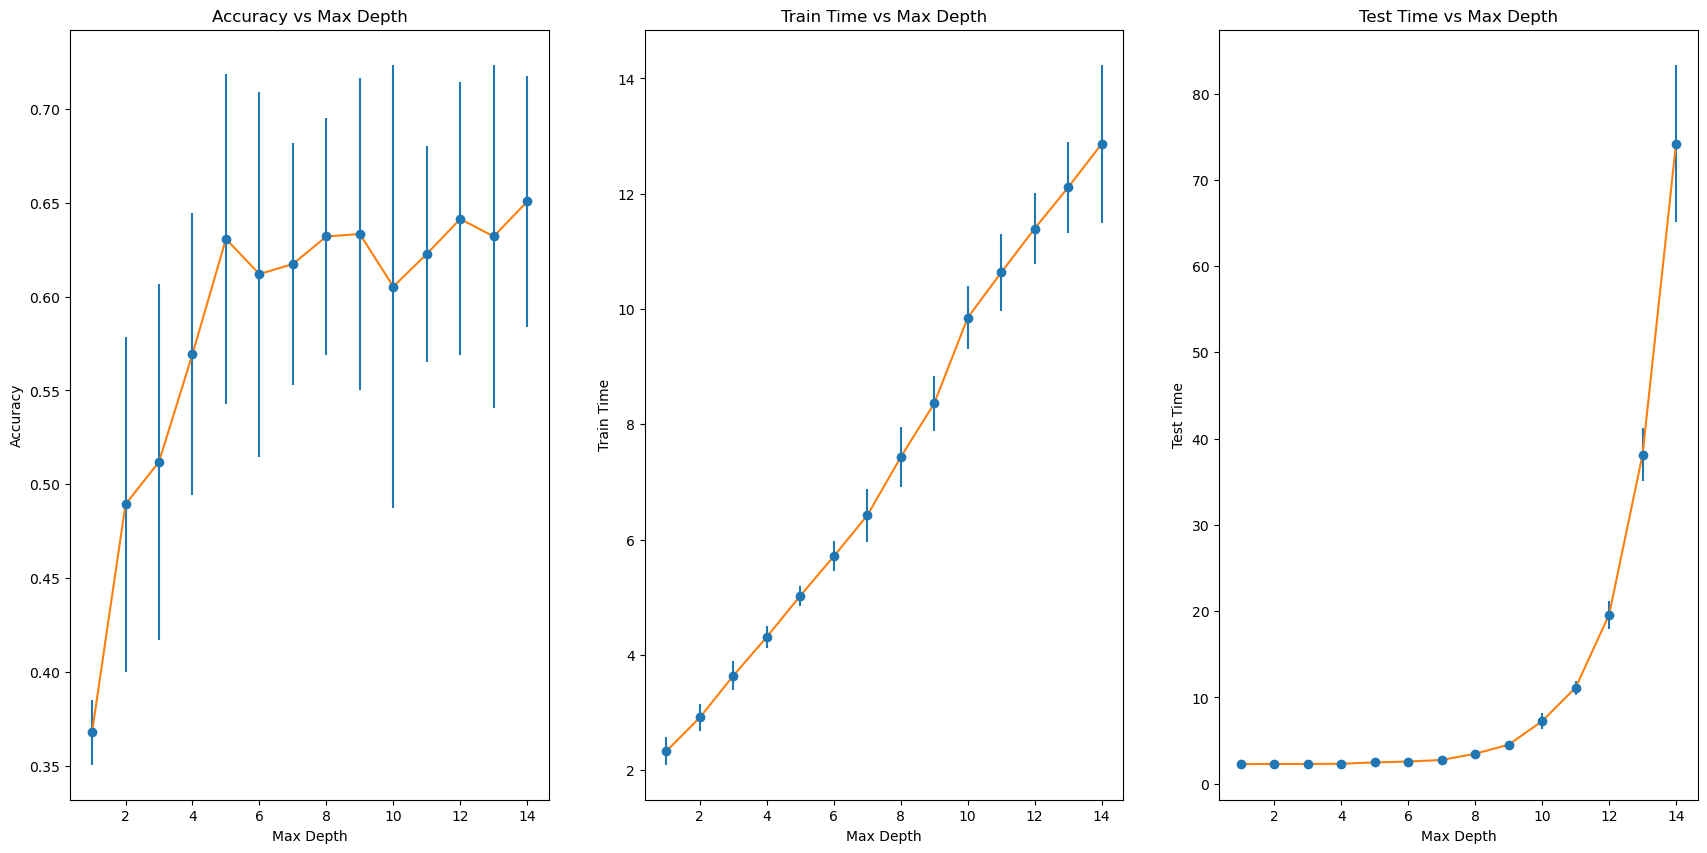

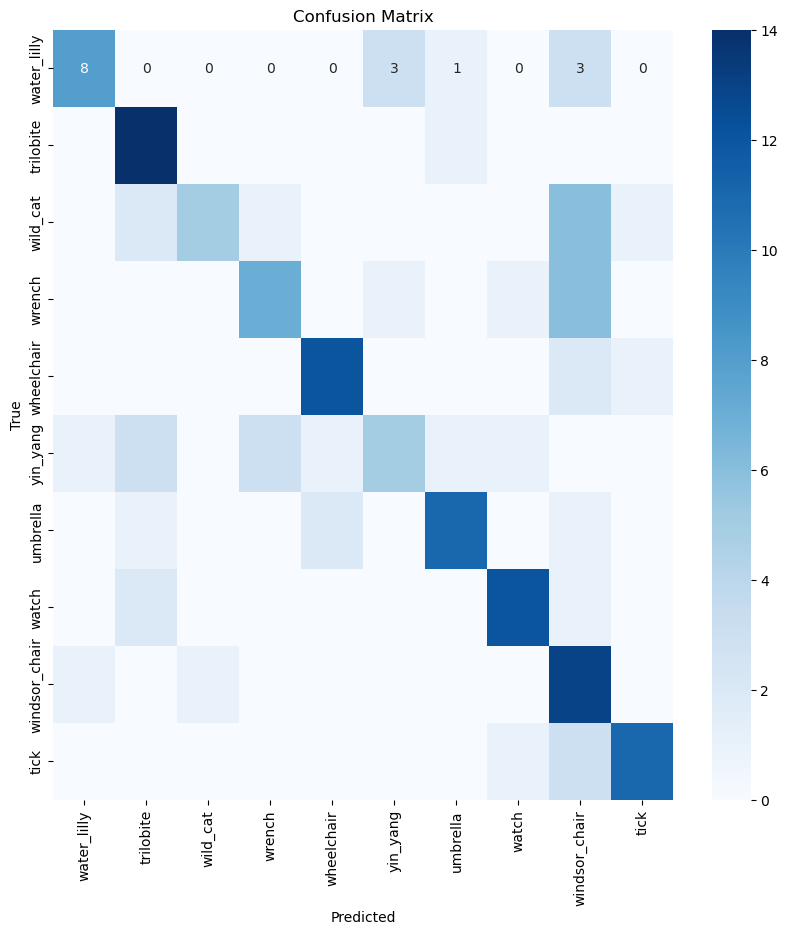

Best model - Max Depth = 14 || Accuracy: 0.6506666666666667 || Train Time: 12.861844205856324 || Test Time: 74.20299620628357


<Figure size 640x480 with 0 Axes>

In [42]:
import sys
root = "./RF_code/Caltech_101/101_ObjectCategories"
vq_export_dir = "./RF_vq_1206/exp2/"
os.makedirs(vq_export_dir, exist_ok=True)


num_trials = 5
rf_codebook_num_estimators = 50
max_depth = range(1, 15)

accuracy = np.zeros((len(max_depth), num_trials))
train_time = np.zeros((len(max_depth), num_trials))
test_time = np.zeros((len(max_depth), num_trials))
cms = []
best_accuracy = 0
best_model_idx = 0

class SuppressPrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

for i, depth in enumerate(max_depth):
    for j in range(num_trials):
        with SuppressPrint():
            vq_rf = VectorQuantization(root, vocab_size= (2**depth)*rf_codebook_num_estimators, use_RF_codebook=True, vq_n_estimators= rf_codebook_num_estimators)
            with SuppressPrint():
                start = time.time()
                vq_rf.fit_codebook()
                end = time.time()
                train_time[i, j] = end - start

                # VQ test time: time to encode the images
                start = time.time()
                vq_rf.construct_train_histograms()
                end = time.time()
                test_time[i, j] = end - start
                vq_rf.construct_test_histograms()
                rf_classifier = RandomForestClassifier(n_estimators=500, max_depth=6, )
                train_X = vq_rf.get_train_histograms()
                train_y = vq_rf.get_train_labels()
                test_X = vq_rf.get_test_histograms()
                test_y = vq_rf.get_test_labels()

                rf_classifier.fit(train_X, train_y)
                pred_y = rf_classifier.predict(test_X)

            accuracy[i, j] = np.mean(pred_y == test_y)
        if np.mean(accuracy[i, :]) > best_accuracy:
            best_accuracy = np.mean(accuracy[i, :])
            best_model_idx = i
    
    cm = confusion_matrix(test_y, pred_y)
    cms.append(cm)
    print(f"VQ RF {i} || Accuracy: {np.mean(accuracy[i, :])} || Train Time: {np.mean(train_time[i, :])} || Test Time: {np.mean(test_time[i, :])} ")

result_df = pd.DataFrame({
    "max_depth": max_depth,
    "num_estimators": np.full(len(max_depth), rf_codebook_num_estimators),
    "mean accuracy": np.mean(accuracy, axis=1),
    "std accuracy": np.std(accuracy, axis=1),
    "mean train time": np.mean(train_time, axis=1),
    "std train time": np.std(train_time, axis=1),
    "mean test time": np.mean(test_time, axis=1),
    "std test time": np.std(test_time, axis=1),
})

result_df.to_csv(os.path.join(vq_export_dir, "result_vq_rf_fixed_num_vocab.csv"))

# plot accuracy, train time, test time with 95% confidence interval
plt.figure(0, figsize=(21, 10))
plt.subplot(1,3,1)
plt.errorbar(max_depth, result_df["mean accuracy"], yerr=1.96*result_df["std accuracy"], fmt='o')
plt.plot(max_depth, result_df["mean accuracy"])
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Depth")

plt.subplot(1,3,2)
plt.errorbar(max_depth, result_df["mean train time"], yerr=1.96*result_df["std train time"], fmt='o')
plt.plot(max_depth, result_df["mean train time"])

plt.xlabel("Max Depth")
plt.ylabel("Train Time")
plt.title("Train Time vs Max Depth")


plt.subplot(1,3,3)
plt.errorbar(max_depth, result_df["mean test time"], yerr=1.96*result_df["std test time"], fmt='o')
plt.plot(max_depth, result_df["mean test time"])
plt.xlabel("Max Depth")
plt.ylabel("Test Time")
plt.title("Test Time vs Max Depth")
plt.savefig(os.path.join(vq_export_dir, "result_vq_rf_fixed_num_vocab.png"))
plt.show()

# plot confusion matrix of the best model
plt.figure(figsize=(10, 10))
cm = cms[best_model_idx]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq_rf.get_class_list(),
    yticklabels=vq_rf.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.title("Confusion Matrix")
plt.show()
plt.savefig(os.path.join(vq_export_dir, "confusion_matrix_vq_rf_fixed_num_vocab.png"))

# report the best model
print(f"Best model - Max Depth = {max_depth[best_model_idx]} || Accuracy: {result_df['mean accuracy'][best_model_idx]} || Train Time: {result_df['mean train time'][best_model_idx]} || Test Time: {result_df['mean test time'][best_model_idx]}")



        

### RF Codebook: max_depth = 4로 고정

num_estimators를 1부터 500까지 증가시킨다. RF classifier는 아까와 같이 고정한다.

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.15it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.46it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.44it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.55it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 125.18it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 116.60it/s]

VQ RF 0 || Accuracy: 0.6159999999999999 || Train Time: 6.531781911849976 || Test Time: 2.8796693325042724 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.90it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.24it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.31it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.37it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.20it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 11/150 [00:00<00:01, 108.91it/s]

VQ RF 1 || Accuracy: 0.6413333333333334 || Train Time: 11.926562356948853 || Test Time: 4.679663562774659 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.11it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.91it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.67it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 106.51it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.07it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 10/150 [00:00<00:01, 93.42it/s]

VQ RF 2 || Accuracy: 0.6266666666666667 || Train Time: 17.024012994766235 || Test Time: 6.280788373947144 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.82it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.63it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.35it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.40it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.22it/s]
Computing SIFT descriptors. The number of images loaded::   9%|▊         | 13/150 [00:00<00:01, 123.34it/s]

VQ RF 3 || Accuracy: 0.624 || Train Time: 22.704897689819337 || Test Time: 7.883557605743408 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.60it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.77it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.18it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.22it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.32it/s]
Computing SIFT descriptors. The number of images loaded::   8%|▊         | 12/150 [00:00<00:01, 115.26it/s]

VQ RF 4 || Accuracy: 0.616 || Train Time: 28.69714221954346 || Test Time: 9.526015043258667 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.84it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.90it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.35it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.54it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.50it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 11/150 [00:00<00:01, 105.22it/s]

VQ RF 5 || Accuracy: 0.6546666666666667 || Train Time: 33.87062697410583 || Test Time: 11.064316463470458 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.53it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.09it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.68it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.10it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.02it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 10/150 [00:00<00:01, 98.71it/s]

VQ RF 6 || Accuracy: 0.624 || Train Time: 39.5732138633728 || Test Time: 12.967149448394775 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.92it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.64it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.12it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 108.94it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.08it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 11/150 [00:00<00:01, 107.80it/s]

VQ RF 7 || Accuracy: 0.6573333333333332 || Train Time: 44.679181432724 || Test Time: 14.263623046875 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.80it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.65it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.62it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.15it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.43it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 11/150 [00:00<00:01, 103.19it/s]

VQ RF 8 || Accuracy: 0.6279999999999999 || Train Time: 50.32202582359314 || Test Time: 15.958416843414307 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.11it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.88it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.87it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.57it/s]
Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.74it/s]


VQ RF 9 || Accuracy: 0.6519999999999999 || Train Time: 54.54562811851501 || Test Time: 17.40549793243408 


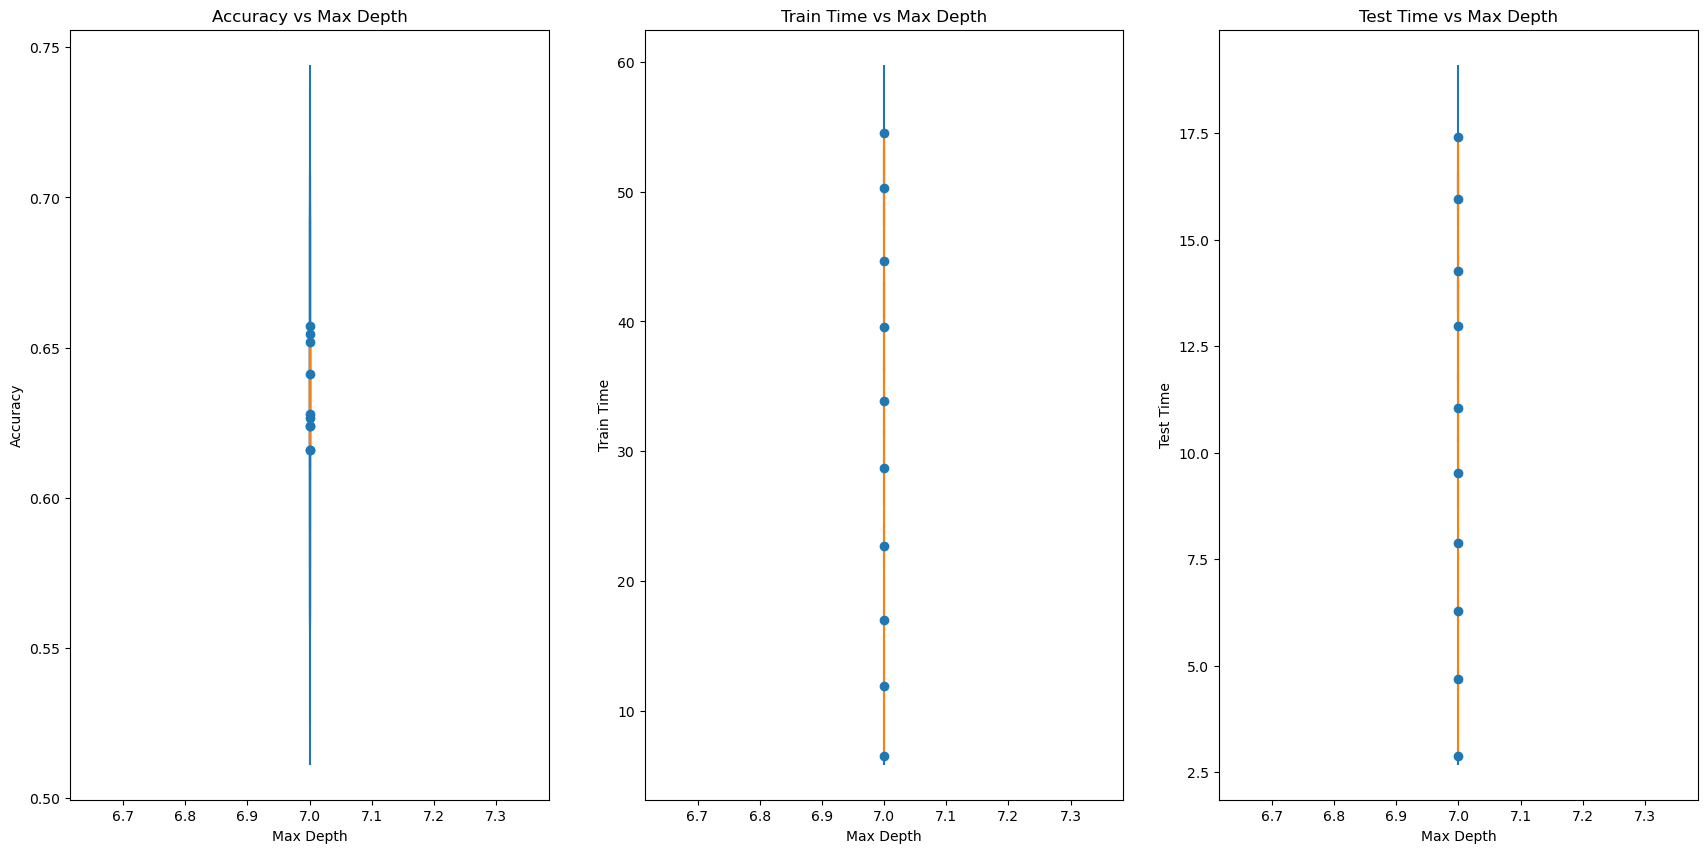

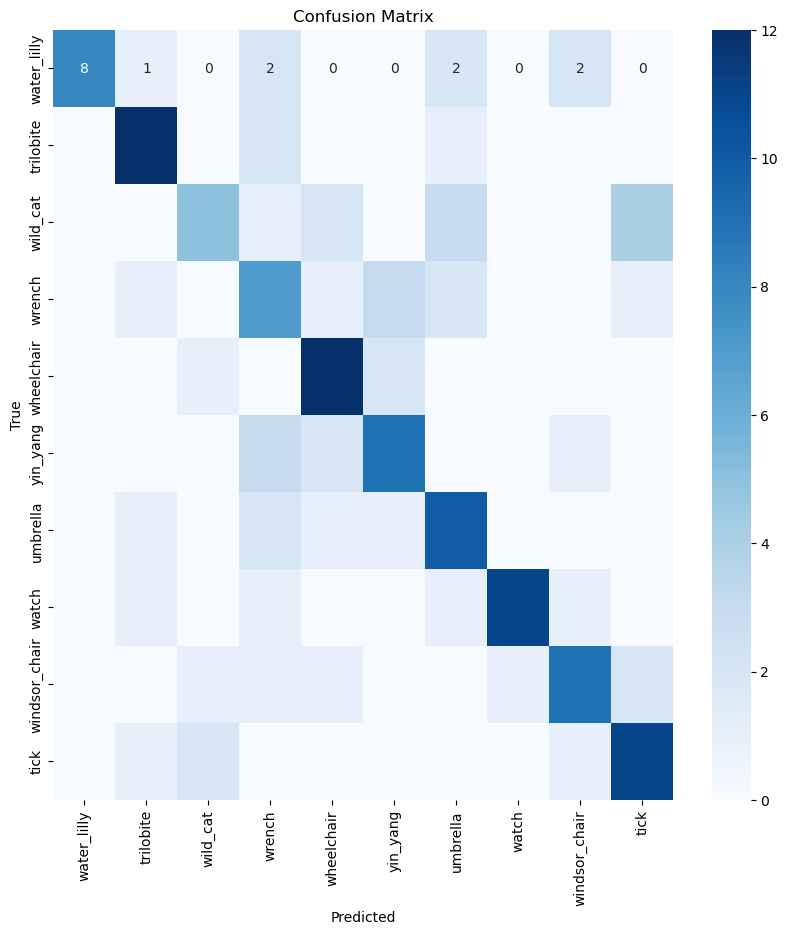

Best model - Max Depth = 7 || Accuracy: 0.6573333333333332 || Train Time: 44.679181432724 || Test Time: 14.263623046875


<Figure size 640x480 with 0 Axes>

In [12]:
import sys
root = "./RF_code/Caltech_101/101_ObjectCategories"
vq_export_dir = "./RF_vq/test4_D_7/"
os.makedirs(vq_export_dir, exist_ok=True)

vocab_size = 2**11
num_trials = 5
num_estimators = range(50,501, 50)
max_depth = np.full(len(num_estimators), 7)
vocab_size = [ n*(2**7) for n in num_estimators]

accuracy = np.zeros((len(max_depth), num_trials))
train_time = np.zeros((len(max_depth), num_trials))
test_time = np.zeros((len(max_depth), num_trials))
cms = []
best_accuracy = 0
best_model_idx = 0

class SuppressPrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

for i, (n_estimators, depth) in enumerate(zip(num_estimators, max_depth)):
    for j in range(num_trials):
        with SuppressPrint():
            vq_rf = VectorQuantization(root, vocab_size= vocab_size[i], use_RF_codebook=True, vq_n_estimators= n_estimators)
            
            start = time.time()
            vq_rf.fit_codebook()
            end = time.time()
            train_time[i, j] = end - start

            # VQ test time: time to encode the images
            start = time.time()
            vq_rf.construct_train_histograms()
            end = time.time()
            test_time[i, j] = end - start
            vq_rf.construct_test_histograms()
            rf_classifier = RandomForestClassifier(n_estimators=600, max_depth=8,  )
            train_X = vq_rf.get_train_histograms()
            train_y = vq_rf.get_train_labels()
            test_X = vq_rf.get_test_histograms()
            test_y = vq_rf.get_test_labels()

            rf_classifier.fit(train_X, train_y)
            pred_y = rf_classifier.predict(test_X)

            accuracy[i, j] = np.mean(pred_y == test_y)
            if accuracy[i, j] > best_accuracy:
                best_accuracy = accuracy[i, j]
                best_model_idx = i
    
    cm = confusion_matrix(test_y, pred_y)
    cms.append(cm)
    print(f"VQ RF {i} || Accuracy: {np.mean(accuracy[i, :])} || Train Time: {np.mean(train_time[i, :])} || Test Time: {np.mean(test_time[i, :])} ")

result_df = pd.DataFrame({
    "max_depth": max_depth,
    "num_estimators": num_estimators,
    "mean accuracy": np.mean(accuracy, axis=1),
    "std accuracy": np.std(accuracy, axis=1),
    "mean train time": np.mean(train_time, axis=1),
    "std train time": np.std(train_time, axis=1),
    "mean test time": np.mean(test_time, axis=1),
    "std test time": np.std(test_time, axis=1),
})

result_df.to_csv(os.path.join(vq_export_dir, "result_vq_rf_fixed_num_vocab.csv"))

# plot accuracy, train time, test time with 95% confidence interval vs num estimators
plt.figure(0, figsize=(21, 10))
plt.subplot(1,3,1)
plt.errorbar(num_estimators, result_df["mean accuracy"], yerr=1.96*result_df["std accuracy"], fmt='o')
plt.plot(num_estimators, result_df["mean accuracy"])
plt.xlabel("Num Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Num Estimators")

plt.subplot(1,3,2)
plt.errorbar(num_estimators, result_df["mean train time"], yerr=1.96*result_df["std train time"], fmt='o')
plt.plot(num_estimators, result_df["mean train time"])
plt.xlabel("Num Estimators")
plt.ylabel("Train Time")
plt.title("Train Time vs Num Estimators")

plt.subplot(1,3,3)
plt.errorbar(num_estimators, result_df["mean test time"], yerr=1.96*result_df["std test time"], fmt='o')
plt.plot(num_estimators, result_df["mean test time"])
plt.xlabel("Num Estimators")
plt.ylabel("Test Time")
plt.title("Test Time vs Num Estimators")

plt.savefig(os.path.join(vq_export_dir, "result_vq_rf_fixed_depth2.png"))
plt.show()
# plot confusion matrix of the best model
plt.figure(figsize=(10, 10))
cm = cms[best_model_idx]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq_rf.get_class_list(),
    yticklabels=vq_rf.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.title("Confusion Matrix")
plt.show()
plt.savefig(os.path.join(vq_export_dir, "confusion_matrix_vq_rf_fixed_num_vocab.png"))

# report the best model
print(f"Best model - Max Depth = {max_depth[best_model_idx]} || Accuracy: {result_df['mean accuracy'][best_model_idx]} || Train Time: {result_df['mean train time'][best_model_idx]} || Test Time: {result_df['mean test time'][best_model_idx]}")



ValueError: 'x' and 'y' must have the same size

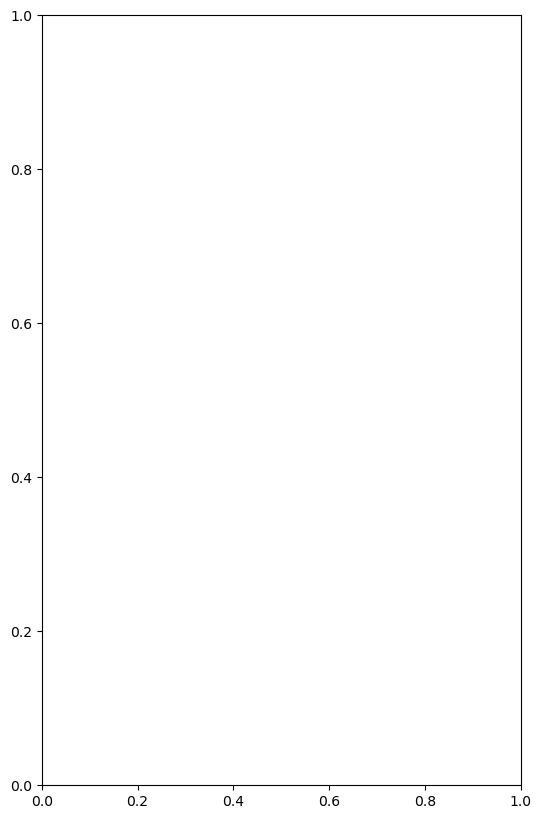

In [44]:

# plot accuracy, train time, test time with 95% confidence interval vs num estimators
plt.figure(0, figsize=(21, 10))
plt.subplot(1,3,1)
plt.errorbar(num_estimators, result_df["mean accuracy"], yerr=1.96*result_df["std accuracy"], fmt='o')
plt.plot(num_estimators, result_df["mean accuracy"])
plt.xlabel("Num Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Num Estimators")

plt.subplot(1,3,2)
plt.errorbar(num_estimators, result_df["mean train time"], yerr=1.96*result_df["std train time"], fmt='o')
plt.plot(num_estimators, result_df["mean train time"])
plt.xlabel("Num Estimators")
plt.ylabel("Train Time")
plt.title("Train Time vs Num Estimators")

plt.subplot(1,3,3)
plt.errorbar(num_estimators, result_df["mean test time"], yerr=1.96*result_df["std test time"], fmt='o')
plt.plot(num_estimators, result_df["mean test time"])
plt.xlabel("Num Estimators")
plt.ylabel("Test Time")
plt.title("Test Time vs Num Estimators")

plt.savefig(os.path.join(vq_export_dir, "result_vq_rf_fixed_depth2.png"))
plt.show()
# plot confusion matrix of the best model
plt.figure(figsize=(10, 10))
cm = cms[best_model_idx]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq_rf.get_class_list(),
    yticklabels=vq_rf.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.title("Confusion Matrix")
plt.show()
plt.savefig(os.path.join(vq_export_dir, "confusion_matrix_vq_rf_fixed_num_vocab.png"))

# report the best model
print(f"Best model - Max Depth = {max_depth[best_model_idx]} || Accuracy: {result_df['mean accuracy'][best_model_idx]} || Train Time: {result_df['mean train time'][best_model_idx]} || Test Time: {result_df['mean test time'][best_model_idx]}")



In [ ]:
# plot accuracy, train time, test time with 95% confidence interval Vs n_estimators
plt.figure(0, figsize=(21, 10))
plt.subplot(1,3,1)
plt.errorbar(num_estimators, result_df["mean accuracy"], yerr=1.96*result_df["std accuracy"], fmt='o')
plt.plot(num_estimators, result_df["mean accuracy"])
plt.xlabel("num_estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs num_estimators")

plt.subplot(1,3,2)
plt.errorbar(num_estimators, result_df["mean train time"], yerr=1.96*result_df["std train time"], fmt='o')
plt.plot(num_estimators, result_df["mean train time"])

plt.xlabel("num_estimators")
plt.ylabel("Train Time")
plt.title("Train Time vs num_estimators")


plt.subplot(1,3,3)
plt.errorbar(num_estimators, result_df["mean test time"], yerr=1.96*result_df["std test time"], fmt='o')
plt.plot(num_estimators, result_df["mean test time"])
plt.xlabel("num_estimators")
plt.ylabel("Test Time")
plt.title("Test Time vs num_estimators")
plt.savefig(os.path.join(vq_export_dir, "result_vq_rf_fixed_num_vocab.png"))
plt.show()

# plot confusion matrix of the best model
plt.figure(figsize=(10, 10))
cm = cms[best_model_idx]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq_rf.get_class_list(),
    yticklabels=vq_rf.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.title("Confusion Matrix")
plt.show()
plt.savefig(os.path.join(vq_export_dir, "confusion_matrix_vq_rf_fixed_maxdepth.png"))

# report the best model
print(f"Best model - num_estimators = {num_estimators[best_model_idx]} || Accuracy: {result_df['mean accuracy'][best_model_idx]} || Train Time: {result_df['mean train time'][best_model_idx]} || Test Time: {result_df['mean test time'][best_model_idx]}")


### RF Codebook: max_depth, num_estimator를 고정

max_features를 0.1부터 1까지 증가시킨다. RF classifier는 아까와 같이 고정한다.

In [ ]:
import sys
root = "./RF_code/Caltech_101/101_ObjectCategories"
vq_export_dir = "./RF_vq/test3/"
os.makedirs(vq_export_dir, exist_ok=True)


num_trials = 5
num_estimators= 32
max_depth = 5
vocab_size = num_estimators * (2**max_depth)
max_features = np.linspace(0.1, 1, 10)
accuracy = np.zeros((len(max_features), num_trials))
train_time = np.zeros((len(max_features), num_trials))
test_time = np.zeros((len(max_features), num_trials))
cms = []
best_accuracy = 0
best_model_idx = 0

class SuppressPrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

for i, max_feature in enumerate(max_features):
    for j in range(num_trials):
        with SuppressPrint():
            vq_rf = VectorQuantization(root, vocab_size= vocab_size, use_RF_codebook=True, vq_n_estimators= num_estimators, rf_keyword_args={"max_features": max_feature})
            
            start = time.time()
            vq_rf.fit_codebook()
            end = time.time()
            train_time[i, j] = end - start

            # VQ test time: time to encode the images
            start = time.time()
            vq_rf.construct_train_histograms()
            end = time.time()
            test_time[i, j] = end - start
            vq_rf.construct_test_histograms()
            rf_classifier = RandomForestClassifier(n_estimators=600, max_depth=8, )
            train_X = vq_rf.get_train_histograms()
            train_y = vq_rf.get_train_labels()
            test_X = vq_rf.get_test_histograms()
            test_y = vq_rf.get_test_labels()

            rf_classifier.fit(train_X, train_y)
            pred_y = rf_classifier.predict(test_X)

            accuracy[i, j] = np.mean(pred_y == test_y)
            if accuracy[i, j] > best_accuracy:
                best_accuracy = accuracy[i, j]
                best_model_idx = i
    
    cm = confusion_matrix(test_y, pred_y)
    cms.append(cm)
    print(f"VQ RF {i} || Accuracy: {np.mean(accuracy[i, :])} || Train Time: {np.mean(train_time[i, :])} || Test Time: {np.mean(test_time[i, :])} ")


In [ ]:

result_df = pd.DataFrame({
    "max_depth": np.full(len(max_features), max_depth),
    "num_estimators": np.full(len(max_features), num_estimators),
    "max_features": max_features,
    "mean accuracy": np.mean(accuracy, axis=1),
    "std accuracy": np.std(accuracy, axis=1),
    "mean train time": np.mean(train_time, axis=1),
    "std train time": np.std(train_time, axis=1),
    "mean test time": np.mean(test_time, axis=1),
    "std test time": np.std(test_time, axis=1),
})

result_df.to_csv(os.path.join(vq_export_dir, "result_vq_rf_fixed_num_vocab.csv"))


max_depth = np.full(len(max_features), max_depth)
num_estimators = np.full(len(max_features), num_estimators)
# plot accuracy, train time, test time with 95% confidence interval

plt.figure(0, figsize=(21, 10))
plt.subplot(1,3,1)
plt.errorbar(max_features, result_df["mean accuracy"], yerr=1.96*result_df["std accuracy"], fmt='o')
plt.plot(max_features, result_df["mean accuracy"])
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs max_features")

plt.subplot(1,3,2)
plt.errorbar(max_features, result_df["mean train time"], yerr=1.96*result_df["std train time"], fmt='o')
plt.plot(max_features, result_df["mean train time"])

plt.xlabel("max_features")
plt.ylabel("Train Time")
plt.title("Train Time vs max_features")


plt.subplot(1,3,3)
plt.errorbar(max_features, result_df["mean test time"], yerr=1.96*result_df["std test time"], fmt='o')
plt.plot(max_features, result_df["mean test time"])
plt.xlabel("max_features")
plt.ylabel("Test Time")
plt.title("Test Time vs max_features")

plt.savefig(os.path.join(vq_export_dir, "result_vq_rf_fixed_maxdepth.png"))
plt.show()

# plot confusion matrix of the best model
plt.figure(figsize=(10, 10))
cm = cms[best_model_idx]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq_rf.get_class_list(),
    yticklabels=vq_rf.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.title("Confusion Matrix")
plt.show()
plt.savefig(os.path.join(vq_export_dir, "confusion_matrix_vq_rf_fixed_maxdepth.png"))

# report the best model

print(f"Best model - max_features = {max_features[best_model_idx]} || Accuracy: {result_df['mean accuracy'][best_model_idx]} || Train Time: {result_df['mean train time'][best_model_idx]} || Test Time: {result_df['mean test time'][best_model_idx]}")



### RF Classifier에 대한 실험

실험은 기본적으로 다 하되, 최고 성능 조합을 찾아서 K-means codebook의 최고 성능 모델과 비교한다.

In [ ]:
import os
import cv2 as cv
import numpy as np
import random
from vectorQuantization import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import time


In [13]:
# grid search
root = "./RF_code/Caltech_101/101_ObjectCategories"
vq_export_dir = "./RF_vq/test5/"
os.makedirs(vq_export_dir, exist_ok=True)
num_estimators_grid = range(50, 301, 50)
max_depth_grid = range(1, 9)
num_trials = 3
accuracy = np.zeros((len(num_estimators_grid), len(max_depth_grid)))
train_time = np.zeros((len(num_estimators_grid), len(max_depth_grid)))
test_time = np.zeros((len(num_estimators_grid), len(max_depth_grid)))

best_accuracy = 0
best_model_idx = 0

for i, num_estimators in enumerate(num_estimators_grid):
    for j, max_depth in enumerate(max_depth_grid):
        accs = []
        train_times = []
        test_times = []
        for k in range(num_trials):
            vq_rf = VectorQuantization(root, vocab_size = num_estimators*(2**max_depth), 
                                    use_RF_codebook=True, vq_n_estimators= num_estimators,)
            start = time.time()
            vq_rf.fit_codebook()
            end = time.time()
            train_times.append(end - start)

            # VQ test time: time to encode the images
            start = time.time()
            vq_rf.construct_train_histograms()
            end = time.time()
            test_times.append(end - start)

            vq_rf.construct_test_histograms()
            
            rf_classifier = RandomForestClassifier(n_estimators=num_estimators, max_depth=max_depth, )
            train_X = vq_rf.get_train_histograms()
            train_y = vq_rf.get_train_labels()
            test_X = vq_rf.get_test_histograms()
            test_y = vq_rf.get_test_labels()

            rf_classifier.fit(train_X, train_y)
            pred_y = rf_classifier.predict(test_X)
            acc = np.mean(pred_y == test_y)
            accs.append(acc)
            if acc > best_accuracy:
                best_accuracy = acc
                best_model_idx = (i, j)
        accuracy[i, j] = np.mean(accs)
        train_time[i, j] = np.mean(train_times)
        test_time[i, j] = np.mean(test_times)
    
        print(f"VQ RF {i}: || num_estimators: {num_estimators} || max_depth: {max_depth} || Accuracy: {np.mean(accs)} || Train Time: {np.mean(train_times)} || Test Time: {np.mean(test_times)} ")

result_df = pd.DataFrame({
    "num_estimators": num_estimators_grid,
    "max_depth": max_depth_grid,
    "mean accuracy": np.mean(accuracy, axis=1),
    "std accuracy": np.std(accuracy, axis=1),
    "mean train time": np.mean(train_time, axis=1),
    "std train time": np.std(train_time, axis=1),
    "mean test time": np.mean(test_time, axis=1),
    "std test time": np.std(test_time, axis=1),
})

result_df.to_csv(os.path.join(vq_export_dir, "result_vq_rf_grid_cll.csv"))

# plot heatmap of accuracy
plt.figure(figsize=(10, 10))
sns.heatmap(
    accuracy,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=max_depth_grid,
    yticklabels=num_estimators_grid,
)
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.title("Accuracy Heatmap")
plt.savefig(os.path.join(vq_export_dir, "accuracy_heatmap.png"))

# plot heatmap of train time
plt.figure(figsize=(10, 10))
sns.heatmap(
    train_time,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=max_depth_grid,
    yticklabels=num_estimators_grid,
)
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.title("Train Time Heatmap")
plt.savefig(os.path.join(vq_export_dir, "train_time_heatmap.png"))

# plot heatmap of test time
plt.figure(figsize=(10, 10))
sns.heatmap(
    test_time,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=max_depth_grid,
    yticklabels=num_estimators_grid,
)
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.title("Test Time Heatmap")
plt.savefig(os.path.join(vq_export_dir, "test_time_heatmap.png"))




Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.82it/s]


Shape of descriptors:  (65612, 128)
Shape of descriptor_labels:  (65612,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 50, total number of leaves: 100
Time taken constructing Random Forest codebook: 0.97s
Total number of codewords: 100
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 100)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 100)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.07it/s]


Shape of descriptors:  (66566, 128)
Shape of descriptor_labels:  (66566,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 50, total number of leaves: 100
Time taken constructing Random Forest codebook: 0.99s
Total number of codewords: 100
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 100)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 100)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.13it/s]


Shape of descriptors:  (62474, 128)
Shape of descriptor_labels:  (62474,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 50, total number of leaves: 100
Time taken constructing Random Forest codebook: 0.94s
Total number of codewords: 100
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 100)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 100)
VQ RF 0: || num_estimators: 50 || max_depth: 1 || Accuracy: 0.23111111111111113 || Train Time: 2.2907217343648276 || Test Time: 2.3026181856791177 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.55it/s]


Shape of descriptors:  (64676, 128)
Shape of descriptor_labels:  (64676,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 50, total number of leaves: 200
Time taken constructing Random Forest codebook: 1.62s
Total number of codewords: 200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.92it/s]


Shape of descriptors:  (64523, 128)
Shape of descriptor_labels:  (64523,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 50, total number of leaves: 200
Time taken constructing Random Forest codebook: 1.66s
Total number of codewords: 200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.58it/s]


Shape of descriptors:  (66027, 128)
Shape of descriptor_labels:  (66027,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 50, total number of leaves: 200
Time taken constructing Random Forest codebook: 1.74s
Total number of codewords: 200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 200)
VQ RF 0: || num_estimators: 50 || max_depth: 2 || Accuracy: 0.3844444444444444 || Train Time: 2.985541343688965 || Test Time: 2.6375030676523843 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 3

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.59it/s]


Shape of descriptors:  (62288, 128)
Shape of descriptor_labels:  (62288,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 50, total number of leaves: 400
Time taken constructing Random Forest codebook: 2.34s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.89it/s]


Shape of descriptors:  (66434, 128)
Shape of descriptor_labels:  (66434,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 50, total number of leaves: 400
Time taken constructing Random Forest codebook: 2.48s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.82it/s]


Shape of descriptors:  (63812, 128)
Shape of descriptor_labels:  (63812,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 50, total number of leaves: 400
Time taken constructing Random Forest codebook: 2.29s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
VQ RF 0: || num_estimators: 50 || max_depth: 3 || Accuracy: 0.46444444444444444 || Train Time: 3.656061808268229 || Test Time: 2.3819645245869956 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.68it/s]


Shape of descriptors:  (66587, 128)
Shape of descriptor_labels:  (66587,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 50, total number of leaves: 800
Time taken constructing Random Forest codebook: 3.15s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.08it/s]


Shape of descriptors:  (68540, 128)
Shape of descriptor_labels:  (68540,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 50, total number of leaves: 800
Time taken constructing Random Forest codebook: 3.25s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.88it/s]


Shape of descriptors:  (64125, 128)
Shape of descriptor_labels:  (64125,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 50, total number of leaves: 800
Time taken constructing Random Forest codebook: 2.98s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
VQ RF 0: || num_estimators: 50 || max_depth: 4 || Accuracy: 0.5622222222222222 || Train Time: 4.407800594965617 || Test Time: 2.386060873667399 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.31it/s]


Shape of descriptors:  (65753, 128)
Shape of descriptor_labels:  (65753,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 50, total number of leaves: 1600
Time taken constructing Random Forest codebook: 3.79s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.27it/s]


Shape of descriptors:  (64731, 128)
Shape of descriptor_labels:  (64731,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 50, total number of leaves: 1600
Time taken constructing Random Forest codebook: 3.66s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.38it/s]


Shape of descriptors:  (65353, 128)
Shape of descriptor_labels:  (65353,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 50, total number of leaves: 1600
Time taken constructing Random Forest codebook: 3.71s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
VQ RF 0: || num_estimators: 50 || max_depth: 5 || Accuracy: 0.5666666666666667 || Train Time: 4.974907477696736 || Test Time: 2.4527819951375327 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images foun

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.70it/s]


Shape of descriptors:  (63955, 128)
Shape of descriptor_labels:  (63955,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 50, total number of leaves: 3200
Time taken constructing Random Forest codebook: 4.36s
Total number of codewords: 3193
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.28it/s]


Shape of descriptors:  (67648, 128)
Shape of descriptor_labels:  (67648,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 50, total number of leaves: 3200
Time taken constructing Random Forest codebook: 4.74s
Total number of codewords: 3196
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.84it/s]


Shape of descriptors:  (65287, 128)
Shape of descriptor_labels:  (65287,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 50, total number of leaves: 3200
Time taken constructing Random Forest codebook: 4.49s
Total number of codewords: 3197
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
VQ RF 0: || num_estimators: 50 || max_depth: 6 || Accuracy: 0.5822222222222222 || Train Time: 5.792084296544393 || Test Time: 2.6435676415761313 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images foun

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 124.12it/s]


Shape of descriptors:  (63014, 128)
Shape of descriptor_labels:  (63014,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 50, total number of leaves: 6400
Time taken constructing Random Forest codebook: 5.08s
Total number of codewords: 6345
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 124.87it/s]


Shape of descriptors:  (66486, 128)
Shape of descriptor_labels:  (66486,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 50, total number of leaves: 6400
Time taken constructing Random Forest codebook: 5.35s
Total number of codewords: 6327
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of i

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.73it/s]


Shape of descriptors:  (66165, 128)
Shape of descriptor_labels:  (66165,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 50, total number of leaves: 6400
Time taken constructing Random Forest codebook: 5.37s
Total number of codewords: 6189
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
VQ RF 0: || num_estimators: 50 || max_depth: 7 || Accuracy: 0.6133333333333334 || Train Time: 6.492089907328288 || Test Time: 2.793450117111206 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.46it/s]


Shape of descriptors:  (66912, 128)
Shape of descriptor_labels:  (66912,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 50, total number of leaves: 12800
Time taken constructing Random Forest codebook: 6.29s
Total number of codewords: 12447
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.77it/s]


Shape of descriptors:  (68789, 128)
Shape of descriptor_labels:  (68789,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 50, total number of leaves: 12800
Time taken constructing Random Forest codebook: 6.46s
Total number of codewords: 12263
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.72it/s]


Shape of descriptors:  (66351, 128)
Shape of descriptor_labels:  (66351,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 50, total number of leaves: 12800
Time taken constructing Random Forest codebook: 6.21s
Total number of codewords: 12398
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
VQ RF 0: || num_estimators: 50 || max_depth: 8 || Accuracy: 0.58 || Train Time: 7.585402329762776 || Test Time: 3.420160929361979 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.37it/s]


Shape of descriptors:  (64544, 128)
Shape of descriptor_labels:  (64544,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 100, total number of leaves: 200
Time taken constructing Random Forest codebook: 1.81s
Total number of codewords: 200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.27it/s]


Shape of descriptors:  (62952, 128)
Shape of descriptor_labels:  (62952,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 100, total number of leaves: 200
Time taken constructing Random Forest codebook: 1.76s
Total number of codewords: 200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.69it/s]


Shape of descriptors:  (64060, 128)
Shape of descriptor_labels:  (64060,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 100, total number of leaves: 200
Time taken constructing Random Forest codebook: 1.75s
Total number of codewords: 200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 200)
VQ RF 1: || num_estimators: 100 || max_depth: 1 || Accuracy: 0.2733333333333334 || Train Time: 3.004376252492269 || Test Time: 3.0091374715169272 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.88it/s]


Shape of descriptors:  (64799, 128)
Shape of descriptor_labels:  (64799,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 100, total number of leaves: 400
Time taken constructing Random Forest codebook: 3.22s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.60it/s]


Shape of descriptors:  (69220, 128)
Shape of descriptor_labels:  (69220,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 100, total number of leaves: 400
Time taken constructing Random Forest codebook: 3.58s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.93it/s]


Shape of descriptors:  (62974, 128)
Shape of descriptor_labels:  (62974,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 100, total number of leaves: 400
Time taken constructing Random Forest codebook: 3.15s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
VQ RF 1: || num_estimators: 100 || max_depth: 2 || Accuracy: 0.3977777777777778 || Train Time: 4.564986228942871 || Test Time: 3.2958289782206216 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.89it/s]


Shape of descriptors:  (68815, 128)
Shape of descriptor_labels:  (68815,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 100, total number of leaves: 800
Time taken constructing Random Forest codebook: 5.21s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.26it/s]


Shape of descriptors:  (63586, 128)
Shape of descriptor_labels:  (63586,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 100, total number of leaves: 800
Time taken constructing Random Forest codebook: 4.68s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.58it/s]


Shape of descriptors:  (68238, 128)
Shape of descriptor_labels:  (68238,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 100, total number of leaves: 800
Time taken constructing Random Forest codebook: 5.02s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
VQ RF 1: || num_estimators: 100 || max_depth: 3 || Accuracy: 0.45555555555555555 || Train Time: 6.299128532409668 || Test Time: 3.4641942977905273 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.20it/s]


Shape of descriptors:  (63631, 128)
Shape of descriptor_labels:  (63631,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 100, total number of leaves: 1600
Time taken constructing Random Forest codebook: 6.18s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.63it/s]


Shape of descriptors:  (70229, 128)
Shape of descriptor_labels:  (70229,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 100, total number of leaves: 1600
Time taken constructing Random Forest codebook: 6.96s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 97.89it/s] 


Shape of descriptors:  (62372, 128)
Shape of descriptor_labels:  (62372,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 100, total number of leaves: 1600
Time taken constructing Random Forest codebook: 6.02s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
VQ RF 1: || num_estimators: 100 || max_depth: 4 || Accuracy: 0.5488888888888889 || Train Time: 7.788792769114177 || Test Time: 3.612091541290283 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fou

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.70it/s]


Shape of descriptors:  (64305, 128)
Shape of descriptor_labels:  (64305,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 100, total number of leaves: 3200
Time taken constructing Random Forest codebook: 7.43s
Total number of codewords: 3200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.93it/s]


Shape of descriptors:  (60047, 128)
Shape of descriptor_labels:  (60047,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 100, total number of leaves: 3200
Time taken constructing Random Forest codebook: 6.90s
Total number of codewords: 3200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.35it/s]


Shape of descriptors:  (65069, 128)
Shape of descriptor_labels:  (65069,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 100, total number of leaves: 3200
Time taken constructing Random Forest codebook: 7.47s
Total number of codewords: 3200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
VQ RF 1: || num_estimators: 100 || max_depth: 5 || Accuracy: 0.5800000000000001 || Train Time: 8.541278998057047 || Test Time: 3.597526709238688 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fou

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.85it/s]


Shape of descriptors:  (65792, 128)
Shape of descriptor_labels:  (65792,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 100, total number of leaves: 6400
Time taken constructing Random Forest codebook: 9.07s
Total number of codewords: 6390
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.60it/s]


Shape of descriptors:  (64940, 128)
Shape of descriptor_labels:  (64940,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 100, total number of leaves: 6400
Time taken constructing Random Forest codebook: 8.84s
Total number of codewords: 6393
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.34it/s]


Shape of descriptors:  (69065, 128)
Shape of descriptor_labels:  (69065,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 100, total number of leaves: 6400
Time taken constructing Random Forest codebook: 9.59s
Total number of codewords: 6388
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
VQ RF 1: || num_estimators: 100 || max_depth: 6 || Accuracy: 0.5911111111111111 || Train Time: 10.438481251398722 || Test Time: 3.885787089665731 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fo

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.43it/s]


Shape of descriptors:  (64870, 128)
Shape of descriptor_labels:  (64870,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 100, total number of leaves: 12800
Time taken constructing Random Forest codebook: 10.36s
Total number of codewords: 12651
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 125.44it/s]


Shape of descriptors:  (60484, 128)
Shape of descriptor_labels:  (60484,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 100, total number of leaves: 12800
Time taken constructing Random Forest codebook: 9.60s
Total number of codewords: 12712
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, #

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.68it/s]


Shape of descriptors:  (65894, 128)
Shape of descriptor_labels:  (65894,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 100, total number of leaves: 12800
Time taken constructing Random Forest codebook: 10.54s
Total number of codewords: 12723
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
VQ RF 1: || num_estimators: 100 || max_depth: 7 || Accuracy: 0.5777777777777778 || Train Time: 11.382337967554728 || Test Time: 4.313088655471802 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 128.12it/s]


Shape of descriptors:  (62328, 128)
Shape of descriptor_labels:  (62328,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 100, total number of leaves: 25600
Time taken constructing Random Forest codebook: 11.40s
Total number of codewords: 24725
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 25600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 25600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.81it/s]


Shape of descriptors:  (65549, 128)
Shape of descriptor_labels:  (65549,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 100, total number of leaves: 25600
Time taken constructing Random Forest codebook: 12.26s
Total number of codewords: 25033
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 25600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 25600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 124.40it/s]


Shape of descriptors:  (63104, 128)
Shape of descriptor_labels:  (63104,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 100, total number of leaves: 25600
Time taken constructing Random Forest codebook: 11.67s
Total number of codewords: 24599
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 25600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 25600)
VQ RF 1: || num_estimators: 100 || max_depth: 8 || Accuracy: 0.611111111111111 || Train Time: 12.98065193494161 || Test Time: 5.348967949549357 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.47it/s]


Shape of descriptors:  (62608, 128)
Shape of descriptor_labels:  (62608,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 150, total number of leaves: 300
Time taken constructing Random Forest codebook: 2.63s
Total number of codewords: 300
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 300)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 300)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.06it/s]


Shape of descriptors:  (62026, 128)
Shape of descriptor_labels:  (62026,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 150, total number of leaves: 300
Time taken constructing Random Forest codebook: 2.62s
Total number of codewords: 300
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 300)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 300)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.06it/s]


Shape of descriptors:  (66809, 128)
Shape of descriptor_labels:  (66809,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 150, total number of leaves: 300
Time taken constructing Random Forest codebook: 2.90s
Total number of codewords: 300
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 300)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 300)
VQ RF 2: || num_estimators: 150 || max_depth: 1 || Accuracy: 0.21777777777777776 || Train Time: 3.976734479268392 || Test Time: 3.9026711781819663 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.27it/s]


Shape of descriptors:  (67980, 128)
Shape of descriptor_labels:  (67980,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 150, total number of leaves: 600
Time taken constructing Random Forest codebook: 5.18s
Total number of codewords: 600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.35it/s]


Shape of descriptors:  (63025, 128)
Shape of descriptor_labels:  (63025,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 150, total number of leaves: 600
Time taken constructing Random Forest codebook: 4.69s
Total number of codewords: 600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.58it/s]


Shape of descriptors:  (66954, 128)
Shape of descriptor_labels:  (66954,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 150, total number of leaves: 600
Time taken constructing Random Forest codebook: 5.02s
Total number of codewords: 600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 600)
VQ RF 2: || num_estimators: 150 || max_depth: 2 || Accuracy: 0.4066666666666667 || Train Time: 6.2514433066050215 || Test Time: 4.304915110270183 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.53it/s]


Shape of descriptors:  (65775, 128)
Shape of descriptor_labels:  (65775,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 150, total number of leaves: 1200
Time taken constructing Random Forest codebook: 7.10s
Total number of codewords: 1200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.62it/s]


Shape of descriptors:  (67601, 128)
Shape of descriptor_labels:  (67601,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 150, total number of leaves: 1200
Time taken constructing Random Forest codebook: 7.47s
Total number of codewords: 1200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.98it/s]


Shape of descriptors:  (67748, 128)
Shape of descriptor_labels:  (67748,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 150, total number of leaves: 1200
Time taken constructing Random Forest codebook: 7.45s
Total number of codewords: 1200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1200)
VQ RF 2: || num_estimators: 150 || max_depth: 3 || Accuracy: 0.48888888888888893 || Train Time: 8.618474006652832 || Test Time: 4.310759703318278 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fo

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 99.74it/s] 


Shape of descriptors:  (71315, 128)
Shape of descriptor_labels:  (71315,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 150, total number of leaves: 2400
Time taken constructing Random Forest codebook: 10.42s
Total number of codewords: 2400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.08it/s]


Shape of descriptors:  (71014, 128)
Shape of descriptor_labels:  (71014,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 150, total number of leaves: 2400
Time taken constructing Random Forest codebook: 10.63s
Total number of codewords: 2400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 104.67it/s]


Shape of descriptors:  (67198, 128)
Shape of descriptor_labels:  (67198,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 150, total number of leaves: 2400
Time taken constructing Random Forest codebook: 10.19s
Total number of codewords: 2400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2400)
VQ RF 2: || num_estimators: 150 || max_depth: 4 || Accuracy: 0.5422222222222223 || Train Time: 11.864450375239054 || Test Time: 4.769592761993408 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images f

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.91it/s]


Shape of descriptors:  (63704, 128)
Shape of descriptor_labels:  (63704,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 150, total number of leaves: 4800
Time taken constructing Random Forest codebook: 11.17s
Total number of codewords: 4800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.65it/s]


Shape of descriptors:  (64655, 128)
Shape of descriptor_labels:  (64655,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 150, total number of leaves: 4800
Time taken constructing Random Forest codebook: 11.28s
Total number of codewords: 4800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.39it/s]


Shape of descriptors:  (64788, 128)
Shape of descriptor_labels:  (64788,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 150, total number of leaves: 4800
Time taken constructing Random Forest codebook: 11.41s
Total number of codewords: 4800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4800)
VQ RF 2: || num_estimators: 150 || max_depth: 5 || Accuracy: 0.5844444444444444 || Train Time: 12.597679297129313 || Test Time: 4.687829653422038 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images f

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.87it/s]


Shape of descriptors:  (60832, 128)
Shape of descriptor_labels:  (60832,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 150, total number of leaves: 9600
Time taken constructing Random Forest codebook: 12.45s
Total number of codewords: 9589
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 9600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 9600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.45it/s]


Shape of descriptors:  (64946, 128)
Shape of descriptor_labels:  (64946,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 150, total number of leaves: 9600
Time taken constructing Random Forest codebook: 13.30s
Total number of codewords: 9584
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 9600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 9600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.92it/s]


Shape of descriptors:  (64058, 128)
Shape of descriptor_labels:  (64058,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 150, total number of leaves: 9600
Time taken constructing Random Forest codebook: 13.17s
Total number of codewords: 9592
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 9600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 9600)
VQ RF 2: || num_estimators: 150 || max_depth: 6 || Accuracy: 0.6 || Train Time: 14.227563699086508 || Test Time: 5.018123388290405 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.62it/s]


Shape of descriptors:  (66328, 128)
Shape of descriptor_labels:  (66328,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 150, total number of leaves: 19200
Time taken constructing Random Forest codebook: 16.09s
Total number of codewords: 18793
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 19200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 19200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.57it/s]


Shape of descriptors:  (64095, 128)
Shape of descriptor_labels:  (64095,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 150, total number of leaves: 19200
Time taken constructing Random Forest codebook: 15.42s
Total number of codewords: 19086
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 19200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 19200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.71it/s]


Shape of descriptors:  (67648, 128)
Shape of descriptor_labels:  (67648,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 150, total number of leaves: 19200
Time taken constructing Random Forest codebook: 16.81s
Total number of codewords: 19005
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 19200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 19200)
VQ RF 2: || num_estimators: 150 || max_depth: 7 || Accuracy: 0.5933333333333334 || Train Time: 17.433586438496906 || Test Time: 6.075032075246175 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.37it/s]


Shape of descriptors:  (68634, 128)
Shape of descriptor_labels:  (68634,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 150, total number of leaves: 38400
Time taken constructing Random Forest codebook: 19.24s
Total number of codewords: 37133
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 38400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 38400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.86it/s]


Shape of descriptors:  (69188, 128)
Shape of descriptor_labels:  (69188,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 150, total number of leaves: 38400
Time taken constructing Random Forest codebook: 19.18s
Total number of codewords: 37396
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 38400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 38400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.07it/s]


Shape of descriptors:  (66145, 128)
Shape of descriptor_labels:  (66145,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 150, total number of leaves: 38400
Time taken constructing Random Forest codebook: 18.16s
Total number of codewords: 37241
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 38400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 38400)
VQ RF 2: || num_estimators: 150 || max_depth: 8 || Accuracy: 0.6022222222222222 || Train Time: 20.16733996073405 || Test Time: 7.758615891138713 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.06it/s]


Shape of descriptors:  (62433, 128)
Shape of descriptor_labels:  (62433,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 200, total number of leaves: 400
Time taken constructing Random Forest codebook: 3.51s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.78it/s]


Shape of descriptors:  (62695, 128)
Shape of descriptor_labels:  (62695,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 200, total number of leaves: 400
Time taken constructing Random Forest codebook: 3.54s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.04it/s]


Shape of descriptors:  (65017, 128)
Shape of descriptor_labels:  (65017,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 200, total number of leaves: 400
Time taken constructing Random Forest codebook: 3.70s
Total number of codewords: 400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 400)
VQ RF 3: || num_estimators: 200 || max_depth: 1 || Accuracy: 0.2733333333333334 || Train Time: 4.860334714253743 || Test Time: 4.776123762130737 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.59it/s]


Shape of descriptors:  (65955, 128)
Shape of descriptor_labels:  (65955,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 200, total number of leaves: 800
Time taken constructing Random Forest codebook: 6.68s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.39it/s]


Shape of descriptors:  (64408, 128)
Shape of descriptor_labels:  (64408,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 200, total number of leaves: 800
Time taken constructing Random Forest codebook: 6.30s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.85it/s]


Shape of descriptors:  (64156, 128)
Shape of descriptor_labels:  (64156,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 200, total number of leaves: 800
Time taken constructing Random Forest codebook: 6.34s
Total number of codewords: 800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 800)
VQ RF 3: || num_estimators: 200 || max_depth: 2 || Accuracy: 0.4022222222222222 || Train Time: 7.746453523635864 || Test Time: 5.205598433812459 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.62it/s]


Shape of descriptors:  (65539, 128)
Shape of descriptor_labels:  (65539,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 200, total number of leaves: 1600
Time taken constructing Random Forest codebook: 9.38s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.31it/s]


Shape of descriptors:  (62698, 128)
Shape of descriptor_labels:  (62698,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 200, total number of leaves: 1600
Time taken constructing Random Forest codebook: 8.84s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.03it/s]


Shape of descriptors:  (63889, 128)
Shape of descriptor_labels:  (63889,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 200, total number of leaves: 1600
Time taken constructing Random Forest codebook: 9.20s
Total number of codewords: 1600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1600)
VQ RF 3: || num_estimators: 200 || max_depth: 3 || Accuracy: 0.5266666666666667 || Train Time: 10.46543780962626 || Test Time: 5.184327681859334 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fou

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.00it/s]


Shape of descriptors:  (68629, 128)
Shape of descriptor_labels:  (68629,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 200, total number of leaves: 3200
Time taken constructing Random Forest codebook: 12.93s
Total number of codewords: 3200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.84it/s]


Shape of descriptors:  (66120, 128)
Shape of descriptor_labels:  (66120,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 200, total number of leaves: 3200
Time taken constructing Random Forest codebook: 12.31s
Total number of codewords: 3200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.32it/s]


Shape of descriptors:  (64640, 128)
Shape of descriptor_labels:  (64640,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 200, total number of leaves: 3200
Time taken constructing Random Forest codebook: 11.92s
Total number of codewords: 3200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3200)
VQ RF 3: || num_estimators: 200 || max_depth: 4 || Accuracy: 0.571111111111111 || Train Time: 13.676896572113037 || Test Time: 5.497018973032634 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fo

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.95it/s]


Shape of descriptors:  (71509, 128)
Shape of descriptor_labels:  (71509,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 200, total number of leaves: 6400
Time taken constructing Random Forest codebook: 16.38s
Total number of codewords: 6400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.69it/s]


Shape of descriptors:  (68215, 128)
Shape of descriptor_labels:  (68215,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 200, total number of leaves: 6400
Time taken constructing Random Forest codebook: 15.70s
Total number of codewords: 6399
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.22it/s]


Shape of descriptors:  (66151, 128)
Shape of descriptor_labels:  (66151,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 200, total number of leaves: 6400
Time taken constructing Random Forest codebook: 15.32s
Total number of codewords: 6399
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)
VQ RF 3: || num_estimators: 200 || max_depth: 5 || Accuracy: 0.6066666666666667 || Train Time: 17.086065689722698 || Test Time: 5.955768426259358 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images f

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.75it/s]


Shape of descriptors:  (64661, 128)
Shape of descriptor_labels:  (64661,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 200, total number of leaves: 12800
Time taken constructing Random Forest codebook: 17.69s
Total number of codewords: 12793
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 123.84it/s]


Shape of descriptors:  (61751, 128)
Shape of descriptor_labels:  (61751,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 200, total number of leaves: 12800
Time taken constructing Random Forest codebook: 16.85s
Total number of codewords: 12775
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.26it/s]


Shape of descriptors:  (63636, 128)
Shape of descriptor_labels:  (63636,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 200, total number of leaves: 12800
Time taken constructing Random Forest codebook: 17.35s
Total number of codewords: 12775
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
VQ RF 3: || num_estimators: 200 || max_depth: 6 || Accuracy: 0.6444444444444445 || Train Time: 18.573963403701782 || Test Time: 6.204708655675252 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.20it/s]


Shape of descriptors:  (63512, 128)
Shape of descriptor_labels:  (63512,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 200, total number of leaves: 25600
Time taken constructing Random Forest codebook: 20.34s
Total number of codewords: 25322
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 25600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 25600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.93it/s]


Shape of descriptors:  (66438, 128)
Shape of descriptor_labels:  (66438,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 200, total number of leaves: 25600
Time taken constructing Random Forest codebook: 21.09s
Total number of codewords: 25159
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 25600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 25600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.89it/s]


Shape of descriptors:  (70099, 128)
Shape of descriptor_labels:  (70099,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 200, total number of leaves: 25600
Time taken constructing Random Forest codebook: 22.38s
Total number of codewords: 25361
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 25600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 25600)
VQ RF 3: || num_estimators: 200 || max_depth: 7 || Accuracy: 0.6511111111111112 || Train Time: 22.556016047795612 || Test Time: 7.745410919189453 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.87it/s]


Shape of descriptors:  (64554, 128)
Shape of descriptor_labels:  (64554,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 200, total number of leaves: 51200
Time taken constructing Random Forest codebook: 23.61s
Total number of codewords: 48927
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 51200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 51200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.21it/s]


Shape of descriptors:  (63558, 128)
Shape of descriptor_labels:  (63558,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 200, total number of leaves: 51200
Time taken constructing Random Forest codebook: 23.55s
Total number of codewords: 49618
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 51200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 51200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.60it/s]


Shape of descriptors:  (62921, 128)
Shape of descriptor_labels:  (62921,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 200, total number of leaves: 51200
Time taken constructing Random Forest codebook: 23.04s
Total number of codewords: 48924
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 51200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 51200)
VQ RF 3: || num_estimators: 200 || max_depth: 8 || Accuracy: 0.64 || Train Time: 24.71886897087097 || Test Time: 9.4286630153656 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Clas

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.69it/s]


Shape of descriptors:  (68787, 128)
Shape of descriptor_labels:  (68787,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 250, total number of leaves: 500
Time taken constructing Random Forest codebook: 4.95s
Total number of codewords: 500
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 500)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 500)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.28it/s]


Shape of descriptors:  (65656, 128)
Shape of descriptor_labels:  (65656,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 250, total number of leaves: 500
Time taken constructing Random Forest codebook: 4.82s
Total number of codewords: 500
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 500)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 500)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.93it/s]


Shape of descriptors:  (65287, 128)
Shape of descriptor_labels:  (65287,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 250, total number of leaves: 500
Time taken constructing Random Forest codebook: 4.55s
Total number of codewords: 500
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 500)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 500)
VQ RF 4: || num_estimators: 250 || max_depth: 1 || Accuracy: 0.28 || Train Time: 6.100350618362427 || Test Time: 5.827940066655477 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wren

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.54it/s]


Shape of descriptors:  (64997, 128)
Shape of descriptor_labels:  (64997,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 250, total number of leaves: 1000
Time taken constructing Random Forest codebook: 8.09s
Total number of codewords: 1000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.66it/s]


Shape of descriptors:  (66337, 128)
Shape of descriptor_labels:  (66337,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 250, total number of leaves: 1000
Time taken constructing Random Forest codebook: 8.50s
Total number of codewords: 1000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.19it/s]


Shape of descriptors:  (63534, 128)
Shape of descriptor_labels:  (63534,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 250, total number of leaves: 1000
Time taken constructing Random Forest codebook: 7.87s
Total number of codewords: 1000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1000)
VQ RF 4: || num_estimators: 250 || max_depth: 2 || Accuracy: 0.40444444444444444 || Train Time: 9.466406424840292 || Test Time: 6.181145350138347 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fo

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.44it/s]


Shape of descriptors:  (64475, 128)
Shape of descriptor_labels:  (64475,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 250, total number of leaves: 2000
Time taken constructing Random Forest codebook: 11.48s
Total number of codewords: 2000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.14it/s]


Shape of descriptors:  (65706, 128)
Shape of descriptor_labels:  (65706,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 250, total number of leaves: 2000
Time taken constructing Random Forest codebook: 11.78s
Total number of codewords: 2000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.15it/s]


Shape of descriptors:  (66713, 128)
Shape of descriptor_labels:  (66713,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 250, total number of leaves: 2000
Time taken constructing Random Forest codebook: 12.03s
Total number of codewords: 2000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2000)
VQ RF 4: || num_estimators: 250 || max_depth: 3 || Accuracy: 0.48444444444444446 || Train Time: 13.06457249323527 || Test Time: 6.153467655181885 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images f

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.97it/s]


Shape of descriptors:  (66063, 128)
Shape of descriptor_labels:  (66063,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 250, total number of leaves: 4000
Time taken constructing Random Forest codebook: 15.45s
Total number of codewords: 4000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.02it/s]


Shape of descriptors:  (63922, 128)
Shape of descriptor_labels:  (63922,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 250, total number of leaves: 4000
Time taken constructing Random Forest codebook: 14.67s
Total number of codewords: 4000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.25it/s]


Shape of descriptors:  (64013, 128)
Shape of descriptor_labels:  (64013,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 250, total number of leaves: 4000
Time taken constructing Random Forest codebook: 14.83s
Total number of codewords: 4000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4000)
VQ RF 4: || num_estimators: 250 || max_depth: 4 || Accuracy: 0.54 || Train Time: 16.266610940297443 || Test Time: 6.4253294467926025 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Clas

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.38it/s]


Shape of descriptors:  (61054, 128)
Shape of descriptor_labels:  (61054,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 250, total number of leaves: 8000
Time taken constructing Random Forest codebook: 17.41s
Total number of codewords: 7999
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 8000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 8000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.19it/s]


Shape of descriptors:  (66046, 128)
Shape of descriptor_labels:  (66046,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 250, total number of leaves: 8000
Time taken constructing Random Forest codebook: 18.89s
Total number of codewords: 8000
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 8000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 8000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.00it/s]


Shape of descriptors:  (65872, 128)
Shape of descriptor_labels:  (65872,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 250, total number of leaves: 8000
Time taken constructing Random Forest codebook: 19.01s
Total number of codewords: 7999
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 8000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 8000)
VQ RF 4: || num_estimators: 250 || max_depth: 5 || Accuracy: 0.6066666666666666 || Train Time: 19.75123469034831 || Test Time: 6.854937235514323 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fo

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.69it/s]


Shape of descriptors:  (62217, 128)
Shape of descriptor_labels:  (62217,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 250, total number of leaves: 16000
Time taken constructing Random Forest codebook: 21.51s
Total number of codewords: 15982
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 16000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 16000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 114.64it/s]


Shape of descriptors:  (65338, 128)
Shape of descriptor_labels:  (65338,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 250, total number of leaves: 16000
Time taken constructing Random Forest codebook: 22.54s
Total number of codewords: 15946
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 16000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 16000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.34it/s]


Shape of descriptors:  (64034, 128)
Shape of descriptor_labels:  (64034,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 250, total number of leaves: 16000
Time taken constructing Random Forest codebook: 21.91s
Total number of codewords: 15964
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 16000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 16000)
VQ RF 4: || num_estimators: 250 || max_depth: 6 || Accuracy: 0.6288888888888889 || Train Time: 23.286171356836956 || Test Time: 7.637894630432129 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.45it/s]


Shape of descriptors:  (66618, 128)
Shape of descriptor_labels:  (66618,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 250, total number of leaves: 32000
Time taken constructing Random Forest codebook: 26.72s
Total number of codewords: 31793
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 32000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 32000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.67it/s]


Shape of descriptors:  (67861, 128)
Shape of descriptor_labels:  (67861,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 250, total number of leaves: 32000
Time taken constructing Random Forest codebook: 27.27s
Total number of codewords: 31708
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 32000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 32000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.64it/s]


Shape of descriptors:  (64802, 128)
Shape of descriptor_labels:  (64802,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 250, total number of leaves: 32000
Time taken constructing Random Forest codebook: 25.86s
Total number of codewords: 31752
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 32000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 32000)
VQ RF 4: || num_estimators: 250 || max_depth: 7 || Accuracy: 0.6533333333333333 || Train Time: 27.88887667655945 || Test Time: 9.100789864857992 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of image

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.91it/s]


Shape of descriptors:  (67928, 128)
Shape of descriptor_labels:  (67928,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 250, total number of leaves: 64000
Time taken constructing Random Forest codebook: 31.65s
Total number of codewords: 61487
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 64000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 64000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.32it/s]


Shape of descriptors:  (63636, 128)
Shape of descriptor_labels:  (63636,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 250, total number of leaves: 64000
Time taken constructing Random Forest codebook: 28.82s
Total number of codewords: 61689
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 64000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 64000)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.92it/s]


Shape of descriptors:  (64946, 128)
Shape of descriptor_labels:  (64946,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 250, total number of leaves: 64000
Time taken constructing Random Forest codebook: 29.76s
Total number of codewords: 62342
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 64000)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 64000)
VQ RF 4: || num_estimators: 250 || max_depth: 8 || Accuracy: 0.6244444444444445 || Train Time: 31.33503810564677 || Test Time: 11.258462826410929 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.10it/s]


Shape of descriptors:  (62705, 128)
Shape of descriptor_labels:  (62705,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 300, total number of leaves: 600
Time taken constructing Random Forest codebook: 5.18s
Total number of codewords: 600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.00it/s]


Shape of descriptors:  (67050, 128)
Shape of descriptor_labels:  (67050,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 300, total number of leaves: 600
Time taken constructing Random Forest codebook: 5.89s
Total number of codewords: 600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.90it/s]


Shape of descriptors:  (65182, 128)
Shape of descriptor_labels:  (65182,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 1, # of trees: 300, total number of leaves: 600
Time taken constructing Random Forest codebook: 5.62s
Total number of codewords: 600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 600)
VQ RF 5: || num_estimators: 300 || max_depth: 1 || Accuracy: 0.2733333333333334 || Train Time: 6.830423355102539 || Test Time: 6.556005398432414 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.76it/s]


Shape of descriptors:  (65360, 128)
Shape of descriptor_labels:  (65360,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 300, total number of leaves: 1200
Time taken constructing Random Forest codebook: 9.85s
Total number of codewords: 1200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.63it/s]


Shape of descriptors:  (64124, 128)
Shape of descriptor_labels:  (64124,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 300, total number of leaves: 1200
Time taken constructing Random Forest codebook: 9.66s
Total number of codewords: 1200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.60it/s]


Shape of descriptors:  (64738, 128)
Shape of descriptor_labels:  (64738,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 300, total number of leaves: 1200
Time taken constructing Random Forest codebook: 9.62s
Total number of codewords: 1200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1200)
VQ RF 5: || num_estimators: 300 || max_depth: 2 || Accuracy: 0.46 || Train Time: 11.005701462427774 || Test Time: 7.077233632405599 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class:

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.71it/s]


Shape of descriptors:  (66975, 128)
Shape of descriptor_labels:  (66975,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 300, total number of leaves: 2400
Time taken constructing Random Forest codebook: 14.46s
Total number of codewords: 2400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.48it/s]


Shape of descriptors:  (64324, 128)
Shape of descriptor_labels:  (64324,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 300, total number of leaves: 2400
Time taken constructing Random Forest codebook: 13.62s
Total number of codewords: 2400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.25it/s]


Shape of descriptors:  (64794, 128)
Shape of descriptor_labels:  (64794,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 3, # of trees: 300, total number of leaves: 2400
Time taken constructing Random Forest codebook: 13.80s
Total number of codewords: 2400
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 2400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 2400)
VQ RF 5: || num_estimators: 300 || max_depth: 3 || Accuracy: 0.48444444444444446 || Train Time: 15.246187686920166 || Test Time: 7.073092699050903 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.88it/s]


Shape of descriptors:  (64031, 128)
Shape of descriptor_labels:  (64031,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 300, total number of leaves: 4800
Time taken constructing Random Forest codebook: 17.90s
Total number of codewords: 4800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.36it/s]


Shape of descriptors:  (69477, 128)
Shape of descriptor_labels:  (69477,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 300, total number of leaves: 4800
Time taken constructing Random Forest codebook: 19.41s
Total number of codewords: 4800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.35it/s]


Shape of descriptors:  (66510, 128)
Shape of descriptor_labels:  (66510,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 300, total number of leaves: 4800
Time taken constructing Random Forest codebook: 19.10s
Total number of codewords: 4800
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 4800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 4800)
VQ RF 5: || num_estimators: 300 || max_depth: 4 || Accuracy: 0.5866666666666667 || Train Time: 20.09899663925171 || Test Time: 7.63675594329834 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images fou

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.25it/s]


Shape of descriptors:  (65346, 128)
Shape of descriptor_labels:  (65346,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 300, total number of leaves: 9600
Time taken constructing Random Forest codebook: 22.89s
Total number of codewords: 9600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 9600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 9600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.08it/s]


Shape of descriptors:  (67349, 128)
Shape of descriptor_labels:  (67349,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 300, total number of leaves: 9600
Time taken constructing Random Forest codebook: 23.29s
Total number of codewords: 9598
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 9600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 9600)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.12it/s]


Shape of descriptors:  (65366, 128)
Shape of descriptor_labels:  (65366,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 300, total number of leaves: 9600
Time taken constructing Random Forest codebook: 22.70s
Total number of codewords: 9600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 9600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 9600)
VQ RF 5: || num_estimators: 300 || max_depth: 5 || Accuracy: 0.5644444444444444 || Train Time: 24.235228061676025 || Test Time: 8.245680093765259 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images f

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 104.24it/s]


Shape of descriptors:  (63118, 128)
Shape of descriptor_labels:  (63118,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 300, total number of leaves: 19200
Time taken constructing Random Forest codebook: 25.90s
Total number of codewords: 19182
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 19200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 19200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.95it/s]


Shape of descriptors:  (66522, 128)
Shape of descriptor_labels:  (66522,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 300, total number of leaves: 19200
Time taken constructing Random Forest codebook: 28.00s
Total number of codewords: 19179
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 19200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 19200)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.12it/s]


Shape of descriptors:  (64993, 128)
Shape of descriptor_labels:  (64993,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 300, total number of leaves: 19200
Time taken constructing Random Forest codebook: 26.58s
Total number of codewords: 19124
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 19200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 19200)
VQ RF 5: || num_estimators: 300 || max_depth: 6 || Accuracy: 0.6444444444444445 || Train Time: 28.148379961649578 || Test Time: 8.965619325637817 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.77it/s]


Shape of descriptors:  (65138, 128)
Shape of descriptor_labels:  (65138,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 300, total number of leaves: 38400
Time taken constructing Random Forest codebook: 31.48s
Total number of codewords: 38228
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 38400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 38400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 120.28it/s]


Shape of descriptors:  (61604, 128)
Shape of descriptor_labels:  (61604,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 300, total number of leaves: 38400
Time taken constructing Random Forest codebook: 29.73s
Total number of codewords: 37924
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 38400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 38400)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.35it/s]


Shape of descriptors:  (68540, 128)
Shape of descriptor_labels:  (68540,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 300, total number of leaves: 38400
Time taken constructing Random Forest codebook: 32.95s
Total number of codewords: 37967
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 38400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 38400)
VQ RF 5: || num_estimators: 300 || max_depth: 7 || Accuracy: 0.6555555555555556 || Train Time: 32.70350440343221 || Test Time: 10.716768344243368 
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of imag

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 116.27it/s]


Shape of descriptors:  (66437, 128)
Shape of descriptor_labels:  (66437,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 37.35s
Total number of codewords: 75135
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 119.49it/s]


Shape of descriptors:  (60614, 128)
Shape of descriptor_labels:  (60614,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 33.66s
Total number of codewords: 74536
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 121.14it/s]


Shape of descriptors:  (66369, 128)
Shape of descriptor_labels:  (66369,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 37.23s
Total number of codewords: 74965
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
VQ RF 5: || num_estimators: 300 || max_depth: 8 || Accuracy: 0.6488888888888888 || Train Time: 37.35281642278036 || Test Time: 13.427480379740397 


ValueError: All arrays must be of the same length

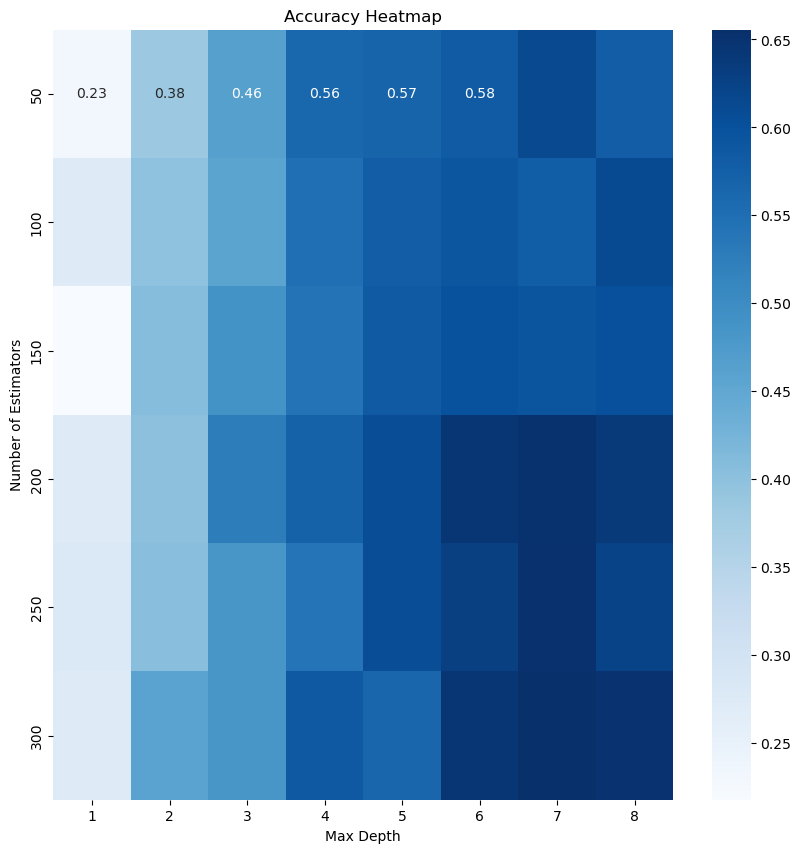

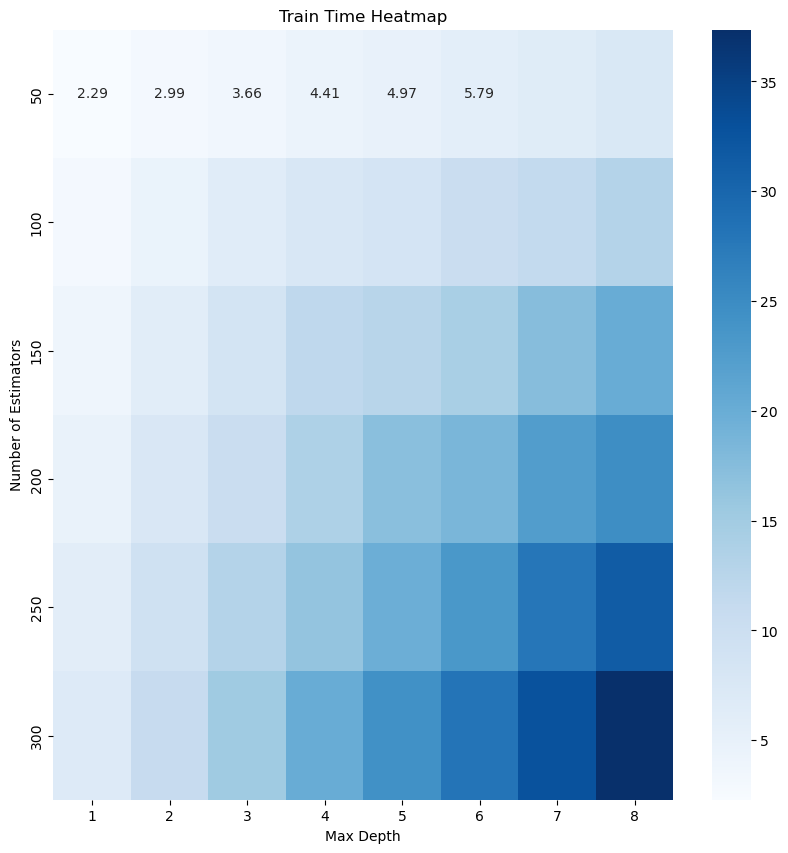

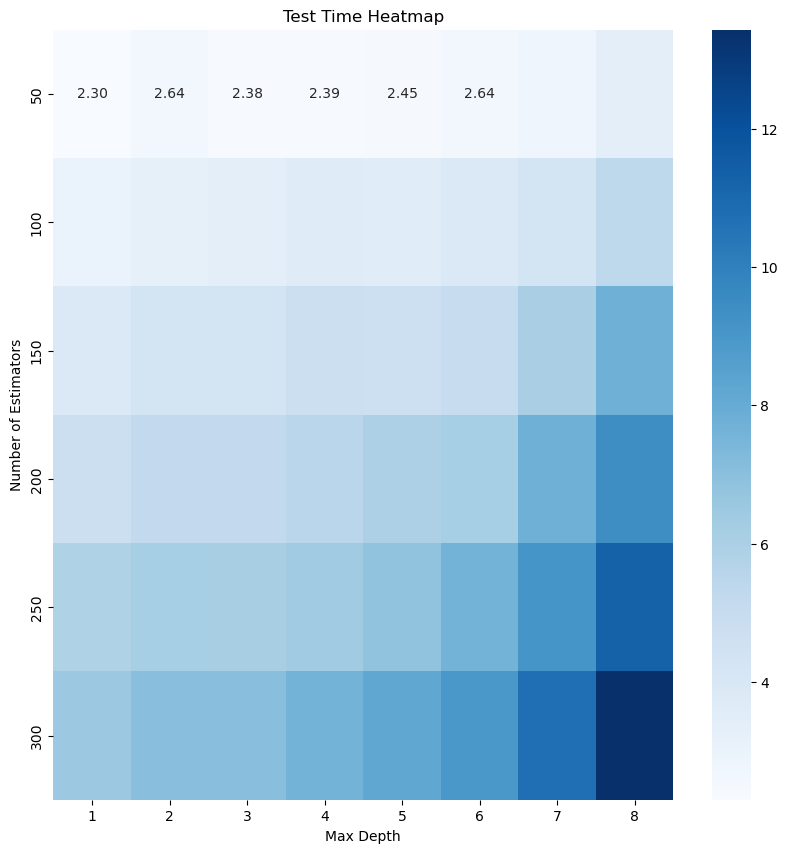

In [15]:
# result_df = pd.DataFrame({
#     "num_estimators": num_estimators_grid,
#     "max_depth": max_depth_grid,
#     "mean accuracy": accuracy,
#     "mean train time": train_time,
#     "mean test time": test_time,
# })

# result_df.to_csv(os.path.join(vq_export_dir, "result_vq_rf_grid_cll.csv"))

# plot heatmap of accuracy
plt.figure(figsize=(10, 10))
sns.heatmap(
    accuracy,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=max_depth_grid,
    yticklabels=num_estimators_grid,
)
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.title("Accuracy Heatmap")
plt.savefig(os.path.join(vq_export_dir, "accuracy_heatmap.png"))

# plot heatmap of train time
plt.figure(figsize=(10, 10))
sns.heatmap(
    train_time,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=max_depth_grid,
    yticklabels=num_estimators_grid,
)
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.title("Train Time Heatmap")
plt.savefig(os.path.join(vq_export_dir, "train_time_heatmap.png"))

# plot heatmap of test time
plt.figure(figsize=(10, 10))
sns.heatmap(
    test_time,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=max_depth_grid,
    yticklabels=num_estimators_grid,
)
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.title("Test Time Heatmap")
plt.savefig(os.path.join(vq_export_dir, "test_time_heatmap.png"))




In [35]:
ind = np.unravel_index(np.argmax(accuracy), accuracy.shape)
ind
list(num_estimators_grid)[ind[0]]

300

In [37]:
best_accuracy = np.max(accuracy)
best_model_idx = np.argmax(accuracy)
best_num_estimators = num_estimators_grid[ind[0]]
best_max_depth = max_depth_grid[ind[1]]
print(f"best model N: {best_num_estimators} || D: {best_max_depth} || Accuracy: {best_accuracy}")


best model N: 300 || D: 7 || Accuracy: 0.6555555555555556


In [87]:

root = "./RF_code/Caltech_101/101_ObjectCategories"
max_features = 0.3
num_estimators = 100
max_depth = 6
vocab_size = num_estimators * (2**max_depth)
vq_rf = VectorQuantization(root, vocab_size= vocab_size, use_RF_codebook=True, vq_n_estimators= num_estimators, rf_keyword_args={"max_features": max_features})

start = time.time()
vq_rf.fit_codebook()
end = time.time()

vq_train_time = end - start

start = time.time()
vq_rf.construct_train_histograms()
end = time.time()
vq_test_time = end - start

vq_rf.construct_test_histograms()

train_X = vq_rf.get_train_histograms()
train_y = vq_rf.get_train_labels()
test_X = vq_rf.get_test_histograms()
test_y = vq_rf.get_test_labels()


Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.71it/s]


Shape of descriptors:  (63611, 128)
Shape of descriptor_labels:  (63611,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 6, # of trees: 100, total number of leaves: 6400
Time taken constructing Random Forest codebook: 28.90s
Total number of codewords: 6384
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)


Accuracy:  0.6333333333333333


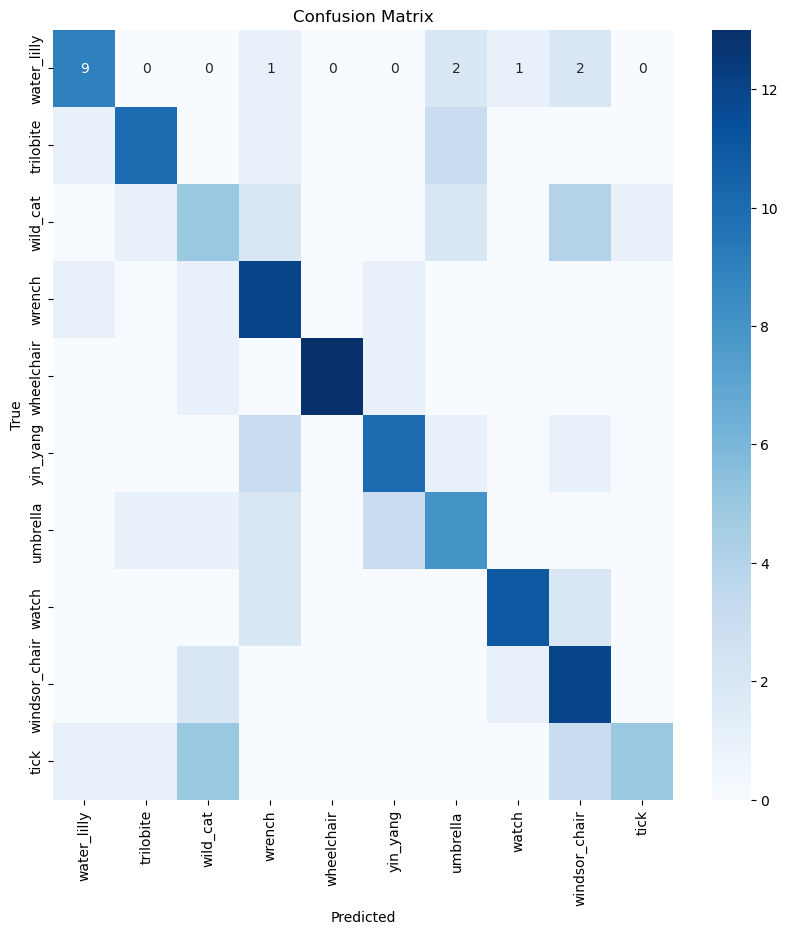

In [92]:


rf_classifier = RandomForestClassifier(n_estimators=700, max_depth=8,   max_features= 0.13)
rf_classifier.fit(train_X, train_y)
pred_y = rf_classifier.predict(test_X)
accuracy = np.mean(pred_y == test_y)
print("Accuracy: ", accuracy)

cm = confusion_matrix(test_y, pred_y)
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=vq_rf.get_class_list(),
    yticklabels=vq_rf.get_class_list(),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [93]:
example_success = []
example_failure = []
success = []
failure = []
pred_y = rf_classifier.predict(test_X)
for i in range(len(test_y)):
    if pred_y[i] == test_y[i]:
        success.append(i)
        example_success.append( vq_rf.get_test_images()[i])
    else:
        failure.append(i)
        example_failure.append(vq_rf.get_test_images()[i])
example_images = [example_success, example_failure]

NameError: name 'independent_variable' is not defined

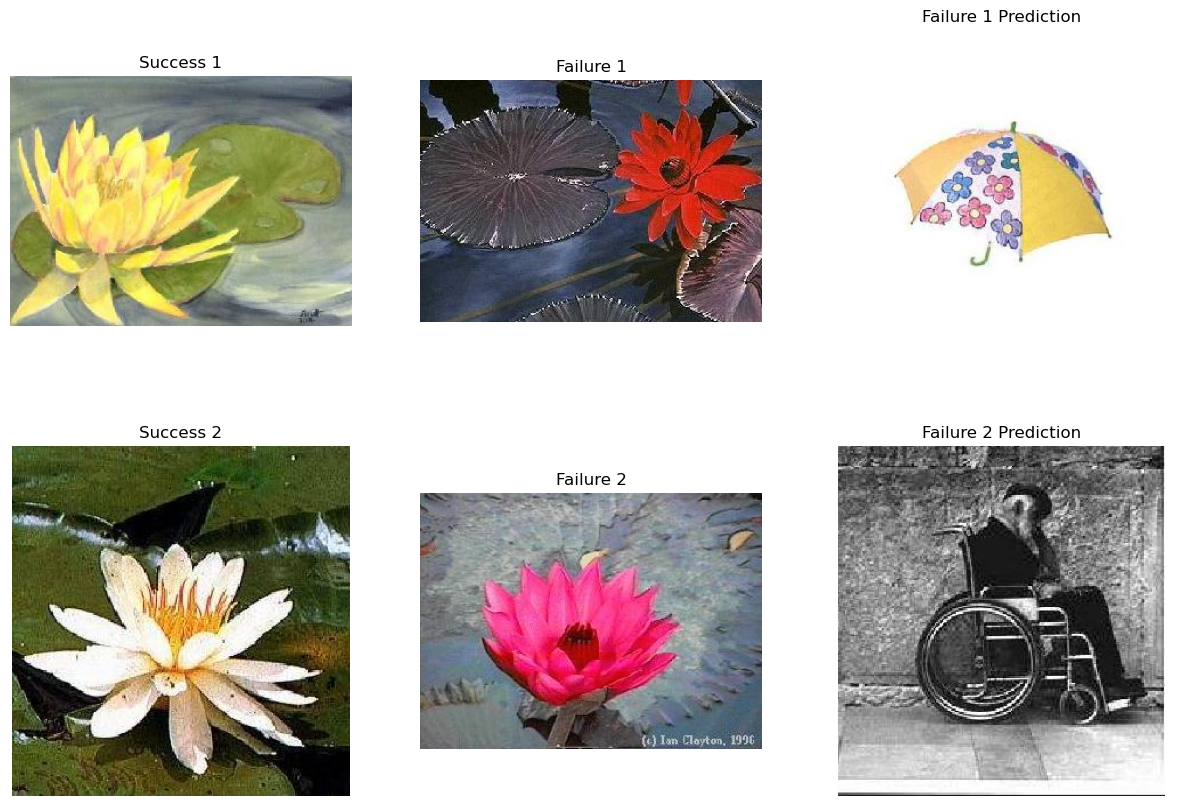

In [94]:
fig, axes = plt.subplots(2,3, figsize=(15, 10))
success_1 = example_success[0]
success_1 = cv.imread(success_1)
success_1 = cv.cvtColor(success_1, cv.COLOR_BGR2RGB)
axes[0,0].imshow(success_1)
axes[0,0].set_title("Success 1")
axes[0,0].axis("off")
success_2 = example_success[1]
success_2 = cv.imread(success_2)
success_2 = cv.cvtColor(success_2, cv.COLOR_BGR2RGB)
axes[1,0].imshow(success_2)
axes[1,0].set_title("Success 2")
axes[1,0].axis("off")

failure_1 = example_failure[0]
failure_1 = cv.imread(failure_1)
failure_1 = cv.cvtColor(failure_1, cv.COLOR_BGR2RGB)
axes[0,1].imshow(failure_1)
axes[0,1].set_title("Failure 1")
axes[0,1].axis("off")
failure_2 = example_failure[1]
failure_2 = cv.imread(failure_2)
failure_2 = cv.cvtColor(failure_2, cv.COLOR_BGR2RGB)
axes[1,1].imshow(failure_2)
axes[1,1].set_title("Failure 2")
axes[1,1].axis("off")

failure_1_pred = pred_y[failure[0]]
failure_1_pred = vq.get_test_images_dict()[failure_1_pred][0]
failure_1_pred = cv.imread(failure_1_pred)
failure_1_pred = cv.cvtColor(failure_1_pred, cv.COLOR_BGR2RGB)
axes[0,2].imshow(failure_1_pred)
axes[0,2].set_title("Failure 1 Prediction")
axes[0,2].axis("off")

failure_2_pred = pred_y[failure[1]]
failure_2_pred = vq.get_test_images_dict()[failure_2_pred][0]
failure_2_pred = cv.imread(failure_2_pred)
failure_2_pred = cv.cvtColor(failure_2_pred, cv.COLOR_BGR2RGB)
axes[1,2].imshow(failure_2_pred)
axes[1,2].set_title("Failure 2 Prediction")
axes[1,2].axis("off")
plt.savefig(f"./Q2_results/example_images_{independent_variable}.png")


BO search kmeans

In [4]:
import os
import cv2 as cv
import numpy as np
import random
from vectorQuantization import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import time
from skopt import gp_minimize
from sklearn.ensemble import RandomForestClassifier
from vectorQuantization import *
from skopt.space.space import Real, Integer, Categorical
import numpy as np
root = "./RF_code/Caltech_101/101_ObjectCategories"
import sys

class SuppressPrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


# Example using RandomForest on the Iris dataset
def objective(params):
    print("========================================")
    print(params)
    vocab_size  = params
    with SuppressPrint():
        
        vq = VectorQuantization(vocab_size= vocab_size, datadir= root ,)
        res = vq.fit_codebook()

    if not res:
        print("Failed to fit codebook: no descriptor")
        return 0
    with SuppressPrint():
        vq.construct_train_histograms()
        vq.construct_test_histograms()
    
    vq.save_as_file("./vq/opt/vq_"+str(vocab_size)+".pkl")
    rf = RandomForestClassifier(n_estimators=600, max_depth=7, max_features= 0.14)
    
    train_X = vq.get_train_histograms()
    train_y = vq.get_train_labels()
    test_X = vq.get_test_histograms()
    test_y = vq.get_test_labels()

    rf.fit(train_X, train_y)
    pred_y = rf.predict(test_X)
    accuracy = np.mean(pred_y == test_y)

    return -accuracy

# Search space
space = [
    Integer(10, 1200, name = "vocab_size"),
]

# optimize
result = gp_minimize(objective, space, n_calls=100, random_state=0, verbose=True)
print("Best Accuracy: ", -result.fun)
print("Best Parameters: ", result.x)

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   9%|▊         | 13/150 [00:00<00:01, 124.37it/s]

Iteration No: 1 started. Evaluating function at random point.
[893, 0.8458230910952074, 12.870604808165128]
Failed to fit codebook: no descriptor
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0115
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 2 started. Evaluating function at random point.
[1272, 0.6273280598181127, 5.771881792317572]
Failed to fit codebook: no descriptor
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0106
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 3 started. Evaluating function at random point.
[453, 0.06614584754426876, 4.097117855755897]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 122.13it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::  10%|█         | 15/150 [00:00<00:00, 143.33it/s]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 58.3744
Function value obtained: -0.6467
Current minimum: -0.6467
Iteration No: 4 started. Evaluating function at random point.
[722, 0.8140470414877384, 7.204857813902111]
Failed to fit codebook: no descriptor
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0097
Function value obtained: 0.0000
Current minimum: -0.6467
Iteration No: 5 started. Evaluating function at random point.
[595, 0.837717975902004, 5.067568444654854]
Failed to fit codebook: no descriptor
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0085
Function value obtained: 0.0000
Current minimum: -0.6467
Iteration No: 6 started. Evaluating function at random point.
[976, 0.37455912444214257, 14.357755832706168]
Failed to fit codebook: no descriptor
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.0092
Function value obtained: 0.0000
Current minimum: -0.6467
Iteration No: 7 started. Evaluatin

Computing SIFT descriptors. The number of images loaded::  81%|████████▏ | 122/150 [00:00<00:00, 132.11it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 1.0446
Function value obtained: 0.0000
Current minimum: -0.6467
Iteration No: 11 started. Searching for the next optimal point.
[10, 0.01, 0.010000000000000024]


Computing SIFT descriptors. The number of images loaded::  87%|████████▋ | 130/150 [00:01<00:00, 97.86it/s] 
Computing SIFT descriptors. The number of images loaded::   5%|▌         | 8/150 [00:00<00:02, 69.02it/s]

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 10.1660
Function value obtained: -0.4933
Current minimum: -0.6467
Iteration No: 12 started. Searching for the next optimal point.
[405, 0.015173186612954755, 2.782161066587434]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 103.67it/s]
Computing SIFT descriptors. The number of images loaded::   6%|▌         | 9/150 [00:00<00:01, 73.58it/s]

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 78.0478
Function value obtained: -0.5467
Current minimum: -0.6467
Iteration No: 13 started. Searching for the next optimal point.
[256, 0.21351187819265396, 15.0]
Failed to fit codebook: no descriptor



Computing SIFT descriptors. The number of images loaded::   5%|▍         | 7/150 [00:00<00:02, 68.17it/s]

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.2337
Function value obtained: 0.0000
Current minimum: -0.6467
Iteration No: 14 started. Searching for the next optimal point.
[456, 0.01, 3.972466778402579]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 104.71it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 10/150 [00:00<00:01, 99.33it/s]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 133.8825
Function value obtained: -0.4933
Current minimum: -0.6467
Iteration No: 15 started. Searching for the next optimal point.
[272, 0.05951688704953949, 2.1246857677163375]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 126.35it/s]
Computing SIFT descriptors. The number of images loaded::   4%|▍         | 6/150 [00:00<00:01, 72.93it/s]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 23.7781
Function value obtained: -0.5600
Current minimum: -0.6467
Iteration No: 16 started. Searching for the next optimal point.
[423, 0.20168324087670067, 0.01]
Failed to fit codebook: no descriptor



Computing SIFT descriptors. The number of images loaded::   6%|▌         | 9/150 [00:00<00:01, 82.18it/s]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4102
Function value obtained: 0.0000
Current minimum: -0.6467
Iteration No: 17 started. Searching for the next optimal point.
[526, 0.07370769673099117, 13.615067927181755]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.45it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 105.2562
Function value obtained: -0.6667
Current minimum: -0.6667
Iteration No: 18 started. Searching for the next optimal point.
[1019, 1.0, 5.320356347055874]
Failed to fit codebook: no descriptor
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.1574
Function value obtained: 0.0000
Current minimum: -0.6667
Iteration No: 19 started. Searching for the next optimal point.
[1423, 0.07108122041195877, 0.01]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.87it/s]
Computing SIFT descriptors. The number of images loaded::   3%|▎         | 5/150 [00:00<00:03, 45.24it/s]

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 333.5018
Function value obtained: -0.7000
Current minimum: -0.7000
Iteration No: 20 started. Searching for the next optimal point.
[360, 0.07460429757607313, 0.01]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 108.61it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 89.6604
Function value obtained: -0.6733
Current minimum: -0.7000
Iteration No: 21 started. Searching for the next optimal point.
[231, 0.7201934933341703, 12.471819734988257]
Failed to fit codebook: no descriptor
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.1488
Function value obtained: 0.0000
Current minimum: -0.7000
Iteration No: 22 started. Searching for the next optimal point.
[1251, 0.29333034965777516, 0.47993598501069673]
Failed to fit codebook: no descriptor



Computing SIFT descriptors. The number of images loaded::   6%|▌         | 9/150 [00:00<00:01, 84.29it/s]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.2150
Function value obtained: 0.0000
Current minimum: -0.7000
Iteration No: 23 started. Searching for the next optimal point.
[1500, 0.07382346298795005, 0.01]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.04it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 10/150 [00:00<00:01, 90.96it/s]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 322.6825
Function value obtained: -0.6133
Current minimum: -0.7000
Iteration No: 24 started. Searching for the next optimal point.
[1187, 0.03343945919244981, 10.726908293540838]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 107.79it/s]
Computing SIFT descriptors. The number of images loaded::   6%|▌         | 9/150 [00:00<00:01, 81.23it/s]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 381.2180
Function value obtained: -0.6133
Current minimum: -0.7000
Iteration No: 25 started. Searching for the next optimal point.
[10, 0.07716347147896656, 15.0]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 106.45it/s]
Computing SIFT descriptors. The number of images loaded::   7%|▋         | 10/150 [00:00<00:01, 93.18it/s]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 7.4784
Function value obtained: -0.4667
Current minimum: -0.7000
Iteration No: 26 started. Searching for the next optimal point.
[1500, 0.05704603965184485, 2.5658466095547516]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 117.49it/s]
Computing SIFT descriptors. The number of images loaded::   5%|▌         | 8/150 [00:00<00:01, 72.63it/s]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 144.8454
Function value obtained: -0.4867
Current minimum: -0.7000
Iteration No: 27 started. Searching for the next optimal point.
[10, 0.047504879957836296, 0.01]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 106.11it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]
Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 8.7058
Function value obtained: -0.4867
Current minimum: -0.7000
Iteration No: 28 started. Searching for the next optimal point.
[71, 0.45017085105328875, 0.012478961016234481]
Failed to fit codebook: no descriptor
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.1781
Function value obtained: 0.0000
Current minimum: -0.7000
Iteration No: 29 started. Searching for the next optimal point.
[1183, 0.9360231860860473, 12.542889773569984]
Failed to fit codebook: no descriptor



Computing SIFT descriptors. The number of images loaded::   5%|▌         | 8/150 [00:00<00:01, 75.44it/s]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.1882
Function value obtained: 0.0000
Current minimum: -0.7000
Iteration No: 30 started. Searching for the next optimal point.
[1312, 0.04262702677802464, 14.98585877368405]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.45it/s]
Computing SIFT descriptors. The number of images loaded::   6%|▌         | 9/150 [00:00<00:01, 85.85it/s]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 320.1864
Function value obtained: -0.6267
Current minimum: -0.7000
Iteration No: 31 started. Searching for the next optimal point.
[1500, 0.05650813835882224, 15.0]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.86it/s]
Computing SIFT descriptors. The number of images loaded::   4%|▍         | 6/150 [00:00<00:02, 58.55it/s]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 228.1324
Function value obtained: -0.6400
Current minimum: -0.7000
Iteration No: 32 started. Searching for the next optimal point.
[1500, 0.056684630307889505, 15.0]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.94it/s]
Computing SIFT descriptors. The number of images loaded::   5%|▍         | 7/150 [00:00<00:02, 69.30it/s]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 363.9543
Function value obtained: -0.6600
Current minimum: -0.7000
Iteration No: 33 started. Searching for the next optimal point.
[1500, 0.057655696975353124, 13.161263925995787]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.44it/s]
Computing SIFT descriptors. The number of images loaded::   6%|▌         | 9/150 [00:00<00:01, 81.07it/s]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 337.9463
Function value obtained: -0.6800
Current minimum: -0.7000
Iteration No: 34 started. Searching for the next optimal point.
[1500, 0.059901391132076445, 15.0]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 118.50it/s]
Computing SIFT descriptors. The number of images loaded::   3%|▎         | 5/150 [00:00<00:02, 49.92it/s]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 290.1424
Function value obtained: -0.6067
Current minimum: -0.7000
Iteration No: 35 started. Searching for the next optimal point.
[1500, 0.04353313873045815, 14.40863258013091]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 105.39it/s]
Computing SIFT descriptors. The number of images loaded::   5%|▌         | 8/150 [00:00<00:01, 75.11it/s]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 376.2948
Function value obtained: -0.6733
Current minimum: -0.7000
Iteration No: 36 started. Searching for the next optimal point.
[1500, 0.056881449210663584, 0.01]


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 108.41it/s]
Computing SIFT descriptors. The number of images loaded::   4%|▍         | 6/150 [00:00<00:02, 51.80it/s]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 340.1439
Function value obtained: -0.5933
Current minimum: -0.7000
Iteration No: 37 started. Searching for the next optimal point.
[1500, 0.01, 15.0]


Computing SIFT descriptors. The number of images loaded::  96%|█████████▌| 144/150 [00:01<00:00, 99.99it/s] 


KeyboardInterrupt: 

BO Search

In [1]:
import os
import cv2 as cv
import numpy as np
import random
from vectorQuantization import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import time
from skopt import gp_minimize
from sklearn.ensemble import RandomForestClassifier
from vectorQuantization import *
from skopt.space.space import Real, Integer, Categorical
import numpy as np
root = "./RF_code/Caltech_101/101_ObjectCategories"
# Example using RandomForest on the Iris dataset

class SuppressPrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def objective(params):
    print("==========================================")
    print(params)
    print("------------------------------------------")
    vq_n_estimators, vq_max_features, vq_max_depth   = params
    vocab_size = vq_n_estimators * (2**vq_max_depth)
    with SuppressPrint():
        vq = VectorQuantization(vq_n_estimators=vq_n_estimators, vocab_size= vocab_size, use_RF_codebook= True, datadir= root , 
                                rf_keyword_args={"max_features": vq_max_features})
        res = vq.fit_codebook()
    if not res:
        print("Failed to fit codebook: no descriptor")
        return 0
    
    with SuppressPrint():
        vq.construct_train_histograms()
        vq.construct_test_histograms()
        vq.save_as_file("./vq_rf/opt/vq_"+str(vocab_size)+".pkl")
    rf = RandomForestClassifier(n_estimators=600, max_depth=7, max_features= 0.14)
    
    train_X = vq.get_train_histograms()
    train_y = vq.get_train_labels()
    test_X = vq.get_test_histograms()
    test_y = vq.get_test_labels()

    rf.fit(train_X, train_y)
    pred_y = rf.predict(test_X)
    accuracy = np.mean(pred_y == test_y)

    return -accuracy

# Search space
space = [
    Integer(50, 300, name = "n_estimators"),
    Real(0.1, 0.5, name = "max_features"),
    Integer(2, 8, name = "max_depth"),
    
]

# optimize
result = gp_minimize(objective, space, n_calls=100, random_state=0, verbose=True)
print("Best Accuracy: ", -result.fun)
print("Best Parameters: ", result.x)

Iteration No: 1 started. Evaluating function at random point.
[198, 0.4236902168046986, 7, 0.8487792213962844, 9.357219814821727]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0202
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 2 started. Evaluating function at random point.
[146, 0.15579195720679145, 2, 0.2799297316343121, 7.170200108647036]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start 

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0097
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 3 started. Evaluating function at random point.
[253, 0.24518881446377816, 4, 0.837717975902004, 5.067568444654854]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start c

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0098
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 4 started. Evaluating function at random point.
[212, 0.19043835452186855, 8, 0.14894727260851873, 13.052608002792965]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Star

Computing SIFT descriptors. The number of images loaded::  17%|█▋        | 26/150 [00:00<00:00, 144.93it/s]


Failed to fit codebook: no descriptor
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1820
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 5 started. Evaluating function at random point.
[168, 0.4024462684700258, 5, 0.6820907348177708, 10.812283494341493]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start 

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0095
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 6 started. Evaluating function at random point.
[196, 0.2733128824300153, 7, 0.11484853111591423, 7.109270286006396]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start 

Computing SIFT descriptors. The number of images loaded::  81%|████████▏ | 122/150 [00:00<00:00, 137.71it/s]


Failed to fit codebook: no descriptor
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.8886
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 7 started. Evaluating function at random point.
[97, 0.37108990679318954, 3, 0.14386599167139758, 4.868873706820279]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start 

Computing SIFT descriptors. The number of images loaded::  10%|█         | 15/150 [00:00<00:00, 140.63it/s]


Failed to fit codebook: no descriptor
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.1095
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 8 started. Evaluating function at random point.
[87, 0.11893748024327797, 4, 0.9035724907741108, 6.754750348769303]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start c

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.0079
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 9 started. Evaluating function at random point.
[203, 0.4521508057552524, 3, 0.9701109770692815, 9.800569136611088]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start c

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.0082
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 10 started. Evaluating function at random point.
[93, 0.1854945618150673, 7, 0.6117523620283132, 4.882457962835204]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start c

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.1893
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 11 started. Searching for the next optimal point.
[297, 0.05940279951671984, 2, 0.046042012329305146, 14.611514237054298]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.34it/s]


Shape of descriptors:  (68825, 128)
Shape of descriptor_labels:  (68825,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 297, total number of leaves: 1188
Time taken constructing Random Forest codebook: 7.50s
Total number of codewords: 1188
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1188)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1188)
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 25.7260
Function value obtained: -0.5533
Current minimum: -0.5533
Iteration No: 12 started. Searching for the next optimal point.
[300, 0.025426695003912935, 2, 0.01, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella'

Computing SIFT descriptors. The number of images loaded::  93%|█████████▎| 139/150 [00:01<00:00, 98.21it/s] 


Total number of descriptors: 101183
Shape of descriptors:  (101183, 128)
Shape of descriptor_labels:  (101183,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 300, total number of leaves: 1200
Time taken constructing Random Forest codebook: 6.06s
Total number of codewords: 1200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 1200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 1200)
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 31.7076
Function value obtained: -0.4333
Current minimum: -0.5533
Iteration No: 13 started. Searching for the next optimal point.
[50, 0.5, 8, 0.9999999999999999, 14.292244254196186]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat'

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.2791
Function value obtained: 0.0000
Current minimum: -0.5533
Iteration No: 14 started. Searching for the next optimal point.
[289, 0.3707222767743403, 8, 0.32870194881394, 0.7102032765380855]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptor

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.1690
Function value obtained: 0.0000
Current minimum: -0.5533
Iteration No: 15 started. Searching for the next optimal point.
[300, 0.24413267439714995, 8, 0.6907258342929551, 12.081659224786584]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images f

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2297
Function value obtained: 0.0000
Current minimum: -0.5533
Iteration No: 16 started. Searching for the next optimal point.
[188, 0.19175589166645707, 2, 0.8837279097332054, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]


Failed to fit codebook: no descriptor
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.1637
Function value obtained: 0.0000
Current minimum: -0.5533
Iteration No: 17 started. Searching for the next optimal point.
[300, 0.4025826224648656, 2, 0.2470368885887985, 3.8093549987096127]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images fo

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2600
Function value obtained: 0.0000
Current minimum: -0.5533
Iteration No: 18 started. Searching for the next optimal point.
[50, 0.048798279272318675, 8, 1.0, 0.01]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2369
Function value obtained: 0.0000
Current minimum: -0.5533
Iteration No: 19 started. Searching for the next optimal point.
[300, 0.07244559171162686, 2, 0.9406895198607704, 0.01]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.2104
Function value obtained: 0.0000
Current minimum: -0.5533
Iteration No: 20 started. Searching for the next optimal point.
[246, 0.11096558166802634, 2, 0.05786500872293421, 13.444739722798436]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images 


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 113.19it/s]


Shape of descriptors:  (55055, 128)
Shape of descriptor_labels:  (55055,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 246, total number of leaves: 984
Time taken constructing Random Forest codebook: 8.69s
Total number of codewords: 984
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 984)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 984)
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 23.4281
Function value obtained: -0.4933
Current minimum: -0.5533
Iteration No: 21 started. Searching for the next optimal point.
[50, 0.5, 8, 0.03931512864318307, 0.01]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watc

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 106.22it/s]


Shape of descriptors:  (86485, 128)
Shape of descriptor_labels:  (86485,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 50, total number of leaves: 12800
Time taken constructing Random Forest codebook: 43.70s
Total number of codewords: 12647
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 62.2268
Function value obtained: -0.6600
Current minimum: -0.6600
Iteration No: 22 started. Searching for the next optimal point.
[50, 0.01, 2, 0.03386463959137221, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrell

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 102.63it/s]


Shape of descriptors:  (73826, 128)
Shape of descriptor_labels:  (73826,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 2, # of trees: 50, total number of leaves: 200
Time taken constructing Random Forest codebook: 0.44s
Total number of codewords: 200
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 200)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 200)
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.1441
Function value obtained: -0.5667
Current minimum: -0.6600
Iteration No: 23 started. Searching for the next optimal point.
[300, 0.37261727655135835, 8, 0.03397273315991266, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'u

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 101.04it/s]


Shape of descriptors:  (77283, 128)
Shape of descriptor_labels:  (77283,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 174.72s
Total number of codewords: 72937
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 261.6372
Function value obtained: -0.7067
Current minimum: -0.7067
Iteration No: 24 started. Searching for the next optimal point.
[300, 0.08511071822480212, 8, 0.026284059181021426, 0.01]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 97.92it/s] 


Shape of descriptors:  (94408, 128)
Shape of descriptor_labels:  (94408,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 47.27s
Total number of codewords: 75568
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 144.6941
Function value obtained: -0.6733
Current minimum: -0.7067
Iteration No: 25 started. Searching for the next optimal point.
[300, 0.22483431273575114, 8, 0.041339030292640015, 6.756431541641946]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'w

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.73it/s]


Shape of descriptors:  (54490, 128)
Shape of descriptor_labels:  (54490,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 74.78s
Total number of codewords: 73410
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 147.0189
Function value obtained: -0.6533
Current minimum: -0.7067
Iteration No: 26 started. Searching for the next optimal point.
[294, 0.35542560881752516, 2, 0.4704571213474219, 10.609960555922685]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wh

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3053
Function value obtained: 0.0000
Current minimum: -0.7067
Iteration No: 27 started. Searching for the next optimal point.
[50, 0.5, 8, 0.02939109639175287, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 102.50it/s]


Shape of descriptors:  (80272, 128)
Shape of descriptor_labels:  (80272,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 50, total number of leaves: 12800
Time taken constructing Random Forest codebook: 39.68s
Total number of codewords: 12425
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 57.0662
Function value obtained: -0.5800
Current minimum: -0.7067
Iteration No: 28 started. Searching for the next optimal point.
[300, 0.1466787354599827, 8, 0.03930144057207569, 2.490216647017915]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheel

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 110.01it/s]


Shape of descriptors:  (26835, 128)
Shape of descriptor_labels:  (26835,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 25.70s
Total number of codewords: 69110
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 77.7774
Function value obtained: -0.6267
Current minimum: -0.7067
Iteration No: 29 started. Searching for the next optimal point.
[117, 0.4420652067053773, 2, 0.7614039453167134, 6.698069682668565]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheel

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.2376
Function value obtained: 0.0000
Current minimum: -0.7067
Iteration No: 30 started. Searching for the next optimal point.
[64, 0.3680073145934775, 8, 0.046933876995260325, 0.7643963364008868]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descrip

Computing SIFT descriptors. The number of images loaded::   2%|▏         | 3/150 [00:00<00:02, 63.54it/s]

Failed to fit codebook: no descriptor


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3090
Function value obtained: 0.0000
Current minimum: -0.7067
Iteration No: 31 started. Searching for the next optimal point.
[50, 0.49089043301007157, 8, 0.06306863906918665, 5.731866424597874]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descript

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 106.01it/s]


Shape of descriptors:  (41059, 128)
Shape of descriptor_labels:  (41059,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 50, total number of leaves: 12800
Time taken constructing Random Forest codebook: 20.86s
Total number of codewords: 12065
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 12800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 12800)
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 34.0304
Function value obtained: -0.5733
Current minimum: -0.7067
Iteration No: 32 started. Searching for the next optimal point.
[292, 0.38465730998453596, 8, 0.01, 11.262344804688047]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_

Computing SIFT descriptors. The number of images loaded::  95%|█████████▌| 143/150 [00:01<00:00, 93.08it/s] 


Total number of descriptors: 100715
Shape of descriptors:  (100715, 128)
Shape of descriptor_labels:  (100715,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 292, total number of leaves: 74752
Time taken constructing Random Forest codebook: 227.45s
Total number of codewords: 72722
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 74752)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 74752)
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 324.7790
Function value obtained: -0.5400
Current minimum: -0.7067
Iteration No: 33 started. Searching for the next optimal point.
[258, 0.039818445517321395, 5, 0.01, 7.745463108591062]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 100.20it/s]


Shape of descriptors:  (96583, 128)
Shape of descriptor_labels:  (96583,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 258, total number of leaves: 8256
Time taken constructing Random Forest codebook: 14.68s
Total number of codewords: 8252
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 8256)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 8256)
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 47.3313
Function value obtained: -0.5600
Current minimum: -0.7067
Iteration No: 34 started. Searching for the next optimal point.
[259, 0.27226659612108545, 8, 0.14524535704330901, 13.212869564600958]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelc

Computing SIFT descriptors. The number of images loaded::  11%|█         | 16/150 [00:00<00:01, 91.36it/s]

Failed to fit codebook: no descriptor


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.6540
Function value obtained: 0.0000
Current minimum: -0.7067
Iteration No: 35 started. Searching for the next optimal point.
[300, 0.5, 5, 0.02499922139178863, 8.504607043700755]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 100.84it/s]


Shape of descriptors:  (76140, 128)
Shape of descriptor_labels:  (76140,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 5, # of trees: 300, total number of leaves: 9600
Time taken constructing Random Forest codebook: 141.17s
Total number of codewords: 9600
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 9600)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 9600)
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 174.5253
Function value obtained: -0.5800
Current minimum: -0.7067
Iteration No: 36 started. Searching for the next optimal point.
[300, 0.18585369044947528, 8, 0.01, 0.01]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrell

Computing SIFT descriptors. The number of images loaded::  89%|████████▊ | 133/150 [00:01<00:00, 92.11it/s] 


Total number of descriptors: 100558
Total number of descriptors: 101189
Shape of descriptors:  (101189, 128)
Shape of descriptor_labels:  (101189,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 110.95s
Total number of codewords: 75571
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 400.7808
Function value obtained: -0.5733
Current minimum: -0.7067
Iteration No: 37 started. Searching for the next optimal point.
[241, 0.4576740539506056, 8, 0.01, 0.5634500305761058]
------------------------------------------
Start loading data...
Found 10 cla

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.40it/s]


Shape of descriptors:  (23417, 128)
Shape of descriptor_labels:  (23417,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 241, total number of leaves: 61696
Time taken constructing Random Forest codebook: 57.35s
Total number of codewords: 45162
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 61696)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 61696)
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 92.3359
Function value obtained: -0.5067
Current minimum: -0.7067
Iteration No: 38 started. Searching for the next optimal point.
[300, 0.2906033883252161, 8, 0.01, 2.295147110160087]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_y

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.79it/s]


Shape of descriptors:  (37619, 128)
Shape of descriptor_labels:  (37619,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 69.46s
Total number of codewords: 65323
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 125.7791
Function value obtained: -0.5667
Current minimum: -0.7067
Iteration No: 39 started. Searching for the next optimal point.
[300, 0.5, 8, 0.07144768442765119, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbre

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 109.57it/s]


Shape of descriptors:  (53051, 128)
Shape of descriptor_labels:  (53051,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 161.17s
Total number of codewords: 73589
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 232.9065
Function value obtained: -0.6600
Current minimum: -0.7067
Iteration No: 40 started. Searching for the next optimal point.
[295, 0.5, 8, 0.06635595927364812, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbr

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 105.53it/s]


Shape of descriptors:  (54513, 128)
Shape of descriptor_labels:  (54513,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 295, total number of leaves: 75520
Time taken constructing Random Forest codebook: 164.99s
Total number of codewords: 72290
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 75520)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 75520)
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 233.6856
Function value obtained: -0.6400
Current minimum: -0.7067
Iteration No: 41 started. Searching for the next optimal point.
[50, 0.3302461957586199, 8, 0.30680150660166616, 11.710581240249105]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wh

Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Failed to fit codebook: no descriptor


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.4595
Function value obtained: 0.0000
Current minimum: -0.7067
Iteration No: 42 started. Searching for the next optimal point.
[300, 0.3667823323692082, 8, 0.04885137030537285, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.59it/s]


Shape of descriptors:  (65091, 128)
Shape of descriptor_labels:  (65091,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 300, total number of leaves: 76800
Time taken constructing Random Forest codebook: 143.57s
Total number of codewords: 74380
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 76800)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 76800)
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 223.6322
Function value obtained: -0.6000
Current minimum: -0.7067
Iteration No: 43 started. Searching for the next optimal point.
[188, 0.5, 4, 0.05950521218613908, 15.0]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbr

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 115.47it/s]


Shape of descriptors:  (57198, 128)
Shape of descriptor_labels:  (57198,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 4, # of trees: 188, total number of leaves: 3008
Time taken constructing Random Forest codebook: 52.08s
Total number of codewords: 3008
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 3008)
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 3008)
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 68.0917
Function value obtained: -0.5800
Current minimum: -0.7067
Iteration No: 44 started. Searching for the next optimal point.
[198, 0.01, 8, 0.08133073354115833, 0.01]
------------------------------------------
Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella'

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 111.47it/s]


Shape of descriptors:  (49093, 128)
Shape of descriptor_labels:  (49093,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 8, # of trees: 198, total number of leaves: 50688
Time taken constructing Random Forest codebook: 2.56s
Total number of codewords: 48233
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 50688)
Constructing histogram of test set...
No descriptor is found.
Constructed histogram of test set. Shape:  (149, 50688)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (149,) and arg 1 with shape (150,).

In [69]:
root= "./RF_code/Caltech_101/101_ObjectCategories"
n_estim = 50
max_depth = 7
vq_rf = VectorQuantization(root, vocab_size= n_estim*(2**max_depth), use_RF_codebook=True, vq_n_estimators= n_estim, rf_keyword_args={"max_features": 0.4})

start = time.time()
vq_rf.fit_codebook()
end = time.time()

vq_train_time = end - start

start = time.time()
vq_rf.construct_train_histograms()
end = time.time()
vq_test_time = end - start
print(f"vq Train time: {vq_train_time} || vq Test time: {vq_test_time}")
vq_rf.construct_test_histograms()


Start loading data...
Found 10 classes: ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
Class: water_lilly, # of images found: 37
Class: trilobite, # of images found: 86
Class: wild_cat, # of images found: 34
Class: wrench, # of images found: 39
Class: wheelchair, # of images found: 59
Class: yin_yang, # of images found: 60
Class: umbrella, # of images found: 75
Class: watch, # of images found: 239
Class: windsor_chair, # of images found: 56
Class: tick, # of images found: 49
Split the dataset into train and test set. (default: 15 images for train, 15 images for test).
Start computing SIFT descriptors...


Computing SIFT descriptors. The number of images loaded::   0%|          | 0/150 [00:00<?, ?it/s]

Computing SIFT descriptors. The number of images loaded:: 100%|██████████| 150/150 [00:01<00:00, 112.62it/s]


Shape of descriptors:  (64811, 128)
Shape of descriptor_labels:  (64811,)
Constructing codebook using Random Forest...
Start constructing Random Forest codebook...
Max depth of each tree: 7, # of trees: 50, total number of leaves: 6400
Time taken constructing Random Forest codebook: 23.15s
Total number of codewords: 6326
The RF codebook is constructed. You can now encode image with it.
Constructing histogram of train set...
Constructed histogram of train set. Shape:  (150, 6400)
vq Train time: 24.49421525001526 || vq Test time: 2.8084287643432617
Constructing histogram of test set...
Constructed histogram of test set. Shape:  (150, 6400)


In [82]:
rf_cl = RandomForestClassifier(n_estimators=600, max_depth=7, max_features= 0.20)
rf_cl.fit(vq_rf.get_train_histograms(), vq_rf.get_train_labels())
pred_y = rf_cl.predict(vq_rf.get_test_histograms())
accuracy = np.mean(pred_y == vq_rf.get_test_labels())
print("Accuracy: ", accuracy)


Accuracy:  0.66
